In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'reinclude'     : ['t1t2'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 100,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_100_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(792888, 828)
(792888, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


   1/7929 [..............................] - ETA: 2:29:00 - loss: 0.1022 - STD: 1.4159e-04 - MAE: 0.3052

  28/7929 [..............................] - ETA: 14s - loss: 0.0198 - STD: 1.2859e-04 - MAE: 0.1092    

  52/7929 [..............................] - ETA: 15s - loss: 0.0155 - STD: 1.2314e-04 - MAE: 0.0951

  74/7929 [..............................] - ETA: 16s - loss: 0.0136 - STD: 1.4272e-04 - MAE: 0.0889

 100/7929 [..............................] - ETA: 16s - loss: 0.0124 - STD: 1.9376e-04 - MAE: 0.0851

 127/7929 [..............................] - ETA: 15s - loss: 0.0117 - STD: 3.2382e-04 - MAE: 0.0829

 156/7929 [..............................] - ETA: 15s - loss: 0.0113 - STD: 7.2480e-04 - MAE: 0.0816

 181/7929 [..............................] - ETA: 15s - loss: 0.0109 - STD: 0.0020 - MAE: 0.0807    

 202/7929 [..............................] - ETA: 15s - loss: 0.0105 - STD: 0.0044 - MAE: 0.0794

 229/7929 [..............................] - ETA: 15s - loss: 0.0102 - STD: 0.0085 - MAE: 0.0780

 257/7929 [..............................] - ETA: 15s - loss: 0.0099 - STD: 0.0123 - MAE: 0.0767

 287/7929 [>.............................] - ETA: 15s - loss: 0.0096 - STD: 0.0154 - MAE: 0.0756

 316/7929 [>.............................] - ETA: 14s - loss: 0.0093 - STD: 0.0183 - MAE: 0.0744

 340/7929 [>.............................] - ETA: 14s - loss: 0.0091 - STD: 0.0207 - MAE: 0.0735

 367/7929 [>.............................] - ETA: 14s - loss: 0.0089 - STD: 0.0231 - MAE: 0.0723

 393/7929 [>.............................] - ETA: 14s - loss: 0.0087 - STD: 0.0252 - MAE: 0.0713

 416/7929 [>.............................] - ETA: 14s - loss: 0.0085 - STD: 0.0271 - MAE: 0.0705

 444/7929 [>.............................] - ETA: 14s - loss: 0.0083 - STD: 0.0289 - MAE: 0.0696

 468/7929 [>.............................] - ETA: 14s - loss: 0.0081 - STD: 0.0304 - MAE: 0.0689

 497/7929 [>.............................] - ETA: 14s - loss: 0.0080 - STD: 0.0321 - MAE: 0.0682

 526/7929 [>.............................] - ETA: 14s - loss: 0.0078 - STD: 0.0335 - MAE: 0.0675

 555/7929 [=>............................] - ETA: 14s - loss: 0.0077 - STD: 0.0347 - MAE: 0.0668

 585/7929 [=>............................] - ETA: 14s - loss: 0.0076 - STD: 0.0360 - MAE: 0.0663

 615/7929 [=>............................] - ETA: 13s - loss: 0.0075 - STD: 0.0372 - MAE: 0.0658

 645/7929 [=>............................] - ETA: 13s - loss: 0.0074 - STD: 0.0383 - MAE: 0.0652

 672/7929 [=>............................] - ETA: 13s - loss: 0.0073 - STD: 0.0393 - MAE: 0.0645

 699/7929 [=>............................] - ETA: 13s - loss: 0.0072 - STD: 0.0403 - MAE: 0.0641

 728/7929 [=>............................] - ETA: 13s - loss: 0.0071 - STD: 0.0410 - MAE: 0.0637

 758/7929 [=>............................] - ETA: 13s - loss: 0.0070 - STD: 0.0419 - MAE: 0.0632

 787/7929 [=>............................] - ETA: 13s - loss: 0.0069 - STD: 0.0426 - MAE: 0.0628

 816/7929 [==>...........................] - ETA: 13s - loss: 0.0068 - STD: 0.0433 - MAE: 0.0625

 844/7929 [==>...........................] - ETA: 13s - loss: 0.0068 - STD: 0.0441 - MAE: 0.0620

 873/7929 [==>...........................] - ETA: 13s - loss: 0.0067 - STD: 0.0448 - MAE: 0.0617

 903/7929 [==>...........................] - ETA: 13s - loss: 0.0066 - STD: 0.0456 - MAE: 0.0613

 932/7929 [==>...........................] - ETA: 13s - loss: 0.0065 - STD: 0.0462 - MAE: 0.0609

 960/7929 [==>...........................] - ETA: 12s - loss: 0.0065 - STD: 0.0468 - MAE: 0.0606

 987/7929 [==>...........................] - ETA: 12s - loss: 0.0064 - STD: 0.0475 - MAE: 0.0603

1014/7929 [==>...........................] - ETA: 12s - loss: 0.0064 - STD: 0.0481 - MAE: 0.0599

1044/7929 [==>...........................] - ETA: 12s - loss: 0.0063 - STD: 0.0486 - MAE: 0.0596

1074/7929 [===>..........................] - ETA: 12s - loss: 0.0062 - STD: 0.0491 - MAE: 0.0593

1103/7929 [===>..........................] - ETA: 12s - loss: 0.0062 - STD: 0.0496 - MAE: 0.0591

1133/7929 [===>..........................] - ETA: 12s - loss: 0.0061 - STD: 0.0502 - MAE: 0.0587

1161/7929 [===>..........................] - ETA: 12s - loss: 0.0061 - STD: 0.0506 - MAE: 0.0585

1186/7929 [===>..........................] - ETA: 12s - loss: 0.0060 - STD: 0.0510 - MAE: 0.0583

1215/7929 [===>..........................] - ETA: 12s - loss: 0.0060 - STD: 0.0515 - MAE: 0.0580

1246/7929 [===>..........................] - ETA: 12s - loss: 0.0060 - STD: 0.0519 - MAE: 0.0578

1274/7929 [===>..........................] - ETA: 12s - loss: 0.0059 - STD: 0.0523 - MAE: 0.0576

1301/7929 [===>..........................] - ETA: 12s - loss: 0.0059 - STD: 0.0527 - MAE: 0.0574

1328/7929 [====>.........................] - ETA: 12s - loss: 0.0058 - STD: 0.0530 - MAE: 0.0572

1355/7929 [====>.........................] - ETA: 12s - loss: 0.0058 - STD: 0.0533 - MAE: 0.0570

1384/7929 [====>.........................] - ETA: 12s - loss: 0.0058 - STD: 0.0537 - MAE: 0.0569

1413/7929 [====>.........................] - ETA: 11s - loss: 0.0058 - STD: 0.0539 - MAE: 0.0567

1442/7929 [====>.........................] - ETA: 11s - loss: 0.0057 - STD: 0.0542 - MAE: 0.0565

1468/7929 [====>.........................] - ETA: 11s - loss: 0.0057 - STD: 0.0545 - MAE: 0.0563

1496/7929 [====>.........................] - ETA: 11s - loss: 0.0057 - STD: 0.0548 - MAE: 0.0562

1523/7929 [====>.........................] - ETA: 11s - loss: 0.0056 - STD: 0.0551 - MAE: 0.0561

1550/7929 [====>.........................] - ETA: 11s - loss: 0.0056 - STD: 0.0553 - MAE: 0.0559

1578/7929 [====>.........................] - ETA: 11s - loss: 0.0056 - STD: 0.0555 - MAE: 0.0558

1604/7929 [=====>........................] - ETA: 11s - loss: 0.0056 - STD: 0.0558 - MAE: 0.0556

1628/7929 [=====>........................] - ETA: 11s - loss: 0.0055 - STD: 0.0561 - MAE: 0.0555

1655/7929 [=====>........................] - ETA: 11s - loss: 0.0055 - STD: 0.0563 - MAE: 0.0554

1681/7929 [=====>........................] - ETA: 11s - loss: 0.0055 - STD: 0.0565 - MAE: 0.0552

1709/7929 [=====>........................] - ETA: 11s - loss: 0.0055 - STD: 0.0567 - MAE: 0.0551

1737/7929 [=====>........................] - ETA: 11s - loss: 0.0054 - STD: 0.0569 - MAE: 0.0550

1765/7929 [=====>........................] - ETA: 11s - loss: 0.0054 - STD: 0.0572 - MAE: 0.0548

1791/7929 [=====>........................] - ETA: 11s - loss: 0.0054 - STD: 0.0573 - MAE: 0.0547

1816/7929 [=====>........................] - ETA: 11s - loss: 0.0054 - STD: 0.0575 - MAE: 0.0546

1839/7929 [=====>........................] - ETA: 11s - loss: 0.0054 - STD: 0.0576 - MAE: 0.0546

1860/7929 [======>.......................] - ETA: 11s - loss: 0.0053 - STD: 0.0578 - MAE: 0.0545

1883/7929 [======>.......................] - ETA: 11s - loss: 0.0053 - STD: 0.0579 - MAE: 0.0544

1909/7929 [======>.......................] - ETA: 11s - loss: 0.0053 - STD: 0.0581 - MAE: 0.0543

1938/7929 [======>.......................] - ETA: 11s - loss: 0.0053 - STD: 0.0583 - MAE: 0.0542

1965/7929 [======>.......................] - ETA: 11s - loss: 0.0053 - STD: 0.0585 - MAE: 0.0540

1991/7929 [======>.......................] - ETA: 11s - loss: 0.0052 - STD: 0.0587 - MAE: 0.0540

2015/7929 [======>.......................] - ETA: 11s - loss: 0.0052 - STD: 0.0589 - MAE: 0.0538

2042/7929 [======>.......................] - ETA: 11s - loss: 0.0052 - STD: 0.0591 - MAE: 0.0537

2069/7929 [======>.......................] - ETA: 10s - loss: 0.0052 - STD: 0.0593 - MAE: 0.0536

2093/7929 [======>.......................] - ETA: 10s - loss: 0.0052 - STD: 0.0594 - MAE: 0.0535

2119/7929 [=======>......................] - ETA: 10s - loss: 0.0052 - STD: 0.0596 - MAE: 0.0535

2139/7929 [=======>......................] - ETA: 10s - loss: 0.0051 - STD: 0.0597 - MAE: 0.0534

2165/7929 [=======>......................] - ETA: 10s - loss: 0.0051 - STD: 0.0598 - MAE: 0.0533

2193/7929 [=======>......................] - ETA: 10s - loss: 0.0051 - STD: 0.0600 - MAE: 0.0532

2219/7929 [=======>......................] - ETA: 10s - loss: 0.0051 - STD: 0.0602 - MAE: 0.0531

2242/7929 [=======>......................] - ETA: 10s - loss: 0.0051 - STD: 0.0603 - MAE: 0.0530

2268/7929 [=======>......................] - ETA: 10s - loss: 0.0051 - STD: 0.0604 - MAE: 0.0529

2296/7929 [=======>......................] - ETA: 10s - loss: 0.0050 - STD: 0.0606 - MAE: 0.0528

2323/7929 [=======>......................] - ETA: 10s - loss: 0.0050 - STD: 0.0607 - MAE: 0.0528

2347/7929 [=======>......................] - ETA: 10s - loss: 0.0050 - STD: 0.0608 - MAE: 0.0527

2375/7929 [=======>......................] - ETA: 10s - loss: 0.0050 - STD: 0.0609 - MAE: 0.0526

2402/7929 [========>.....................] - ETA: 10s - loss: 0.0050 - STD: 0.0610 - MAE: 0.0525

2430/7929 [========>.....................] - ETA: 10s - loss: 0.0050 - STD: 0.0611 - MAE: 0.0525

2459/7929 [========>.....................] - ETA: 10s - loss: 0.0050 - STD: 0.0613 - MAE: 0.0524

2487/7929 [========>.....................] - ETA: 10s - loss: 0.0050 - STD: 0.0614 - MAE: 0.0523

2514/7929 [========>.....................] - ETA: 10s - loss: 0.0049 - STD: 0.0615 - MAE: 0.0522

2545/7929 [========>.....................] - ETA: 10s - loss: 0.0049 - STD: 0.0617 - MAE: 0.0521

2572/7929 [========>.....................] - ETA: 10s - loss: 0.0049 - STD: 0.0618 - MAE: 0.0521

2599/7929 [========>.....................] - ETA: 10s - loss: 0.0049 - STD: 0.0620 - MAE: 0.0520

2616/7929 [========>.....................] - ETA: 10s - loss: 0.0049 - STD: 0.0620 - MAE: 0.0519

2636/7929 [========>.....................] - ETA: 10s - loss: 0.0049 - STD: 0.0620 - MAE: 0.0519

2660/7929 [=========>....................] - ETA: 9s - loss: 0.0049 - STD: 0.0621 - MAE: 0.0518 

2688/7929 [=========>....................] - ETA: 9s - loss: 0.0049 - STD: 0.0623 - MAE: 0.0517

2717/7929 [=========>....................] - ETA: 9s - loss: 0.0048 - STD: 0.0624 - MAE: 0.0517

2747/7929 [=========>....................] - ETA: 9s - loss: 0.0048 - STD: 0.0625 - MAE: 0.0516

2772/7929 [=========>....................] - ETA: 9s - loss: 0.0048 - STD: 0.0626 - MAE: 0.0516

2800/7929 [=========>....................] - ETA: 9s - loss: 0.0048 - STD: 0.0627 - MAE: 0.0515

2826/7929 [=========>....................] - ETA: 9s - loss: 0.0048 - STD: 0.0628 - MAE: 0.0514

2852/7929 [=========>....................] - ETA: 9s - loss: 0.0048 - STD: 0.0629 - MAE: 0.0514

2878/7929 [=========>....................] - ETA: 9s - loss: 0.0048 - STD: 0.0630 - MAE: 0.0513

2908/7929 [==========>...................] - ETA: 9s - loss: 0.0048 - STD: 0.0632 - MAE: 0.0512

2939/7929 [==========>...................] - ETA: 9s - loss: 0.0047 - STD: 0.0633 - MAE: 0.0511

2970/7929 [==========>...................] - ETA: 9s - loss: 0.0047 - STD: 0.0634 - MAE: 0.0511

3000/7929 [==========>...................] - ETA: 9s - loss: 0.0047 - STD: 0.0634 - MAE: 0.0510

3030/7929 [==========>...................] - ETA: 9s - loss: 0.0047 - STD: 0.0635 - MAE: 0.0510

3058/7929 [==========>...................] - ETA: 9s - loss: 0.0047 - STD: 0.0636 - MAE: 0.0509

3086/7929 [==========>...................] - ETA: 9s - loss: 0.0047 - STD: 0.0637 - MAE: 0.0508

3115/7929 [==========>...................] - ETA: 9s - loss: 0.0047 - STD: 0.0638 - MAE: 0.0508

3142/7929 [==========>...................] - ETA: 8s - loss: 0.0047 - STD: 0.0639 - MAE: 0.0507

3164/7929 [==========>...................] - ETA: 8s - loss: 0.0047 - STD: 0.0640 - MAE: 0.0507

3188/7929 [===========>..................] - ETA: 8s - loss: 0.0047 - STD: 0.0640 - MAE: 0.0506

3218/7929 [===========>..................] - ETA: 8s - loss: 0.0046 - STD: 0.0641 - MAE: 0.0506

3248/7929 [===========>..................] - ETA: 8s - loss: 0.0046 - STD: 0.0643 - MAE: 0.0505

3276/7929 [===========>..................] - ETA: 8s - loss: 0.0046 - STD: 0.0643 - MAE: 0.0505

3303/7929 [===========>..................] - ETA: 8s - loss: 0.0046 - STD: 0.0644 - MAE: 0.0504

3331/7929 [===========>..................] - ETA: 8s - loss: 0.0046 - STD: 0.0645 - MAE: 0.0504

3356/7929 [===========>..................] - ETA: 8s - loss: 0.0046 - STD: 0.0646 - MAE: 0.0504

3381/7929 [===========>..................] - ETA: 8s - loss: 0.0046 - STD: 0.0646 - MAE: 0.0503

3406/7929 [===========>..................] - ETA: 8s - loss: 0.0046 - STD: 0.0647 - MAE: 0.0503

3432/7929 [===========>..................] - ETA: 8s - loss: 0.0046 - STD: 0.0647 - MAE: 0.0502

3459/7929 [============>.................] - ETA: 8s - loss: 0.0046 - STD: 0.0648 - MAE: 0.0502

3485/7929 [============>.................] - ETA: 8s - loss: 0.0046 - STD: 0.0649 - MAE: 0.0502

3513/7929 [============>.................] - ETA: 8s - loss: 0.0046 - STD: 0.0650 - MAE: 0.0501

3536/7929 [============>.................] - ETA: 8s - loss: 0.0046 - STD: 0.0650 - MAE: 0.0501

3560/7929 [============>.................] - ETA: 8s - loss: 0.0046 - STD: 0.0651 - MAE: 0.0500

3565/7929 [============>.................] - ETA: 8s - loss: 0.0046 - STD: 0.0651 - MAE: 0.0500

3588/7929 [============>.................] - ETA: 8s - loss: 0.0045 - STD: 0.0652 - MAE: 0.0500

3617/7929 [============>.................] - ETA: 8s - loss: 0.0045 - STD: 0.0652 - MAE: 0.0500

3646/7929 [============>.................] - ETA: 8s - loss: 0.0045 - STD: 0.0653 - MAE: 0.0499

3671/7929 [============>.................] - ETA: 8s - loss: 0.0045 - STD: 0.0654 - MAE: 0.0499

3699/7929 [============>.................] - ETA: 8s - loss: 0.0045 - STD: 0.0654 - MAE: 0.0498

3725/7929 [=============>................] - ETA: 8s - loss: 0.0045 - STD: 0.0655 - MAE: 0.0498

3747/7929 [=============>................] - ETA: 8s - loss: 0.0045 - STD: 0.0655 - MAE: 0.0498

3775/7929 [=============>................] - ETA: 8s - loss: 0.0045 - STD: 0.0656 - MAE: 0.0497

3800/7929 [=============>................] - ETA: 8s - loss: 0.0045 - STD: 0.0657 - MAE: 0.0497

3824/7929 [=============>................] - ETA: 8s - loss: 0.0045 - STD: 0.0657 - MAE: 0.0496

3847/7929 [=============>................] - ETA: 8s - loss: 0.0045 - STD: 0.0658 - MAE: 0.0496

3872/7929 [=============>................] - ETA: 8s - loss: 0.0045 - STD: 0.0658 - MAE: 0.0496

3896/7929 [=============>................] - ETA: 8s - loss: 0.0045 - STD: 0.0659 - MAE: 0.0495

3915/7929 [=============>................] - ETA: 8s - loss: 0.0045 - STD: 0.0660 - MAE: 0.0495

3939/7929 [=============>................] - ETA: 8s - loss: 0.0045 - STD: 0.0660 - MAE: 0.0495

3965/7929 [==============>...............] - ETA: 8s - loss: 0.0044 - STD: 0.0661 - MAE: 0.0494

3990/7929 [==============>...............] - ETA: 8s - loss: 0.0044 - STD: 0.0661 - MAE: 0.0494

4018/7929 [==============>...............] - ETA: 7s - loss: 0.0044 - STD: 0.0661 - MAE: 0.0493

4046/7929 [==============>...............] - ETA: 7s - loss: 0.0044 - STD: 0.0662 - MAE: 0.0493

4071/7929 [==============>...............] - ETA: 7s - loss: 0.0044 - STD: 0.0663 - MAE: 0.0492

4090/7929 [==============>...............] - ETA: 7s - loss: 0.0044 - STD: 0.0663 - MAE: 0.0492

4111/7929 [==============>...............] - ETA: 7s - loss: 0.0044 - STD: 0.0664 - MAE: 0.0492

4130/7929 [==============>...............] - ETA: 7s - loss: 0.0044 - STD: 0.0664 - MAE: 0.0491

4152/7929 [==============>...............] - ETA: 7s - loss: 0.0044 - STD: 0.0664 - MAE: 0.0491

4177/7929 [==============>...............] - ETA: 7s - loss: 0.0044 - STD: 0.0665 - MAE: 0.0491

4204/7929 [==============>...............] - ETA: 7s - loss: 0.0044 - STD: 0.0665 - MAE: 0.0490

4231/7929 [===============>..............] - ETA: 7s - loss: 0.0044 - STD: 0.0666 - MAE: 0.0490

4259/7929 [===============>..............] - ETA: 7s - loss: 0.0044 - STD: 0.0667 - MAE: 0.0490

4285/7929 [===============>..............] - ETA: 7s - loss: 0.0044 - STD: 0.0667 - MAE: 0.0489

4310/7929 [===============>..............] - ETA: 7s - loss: 0.0044 - STD: 0.0668 - MAE: 0.0489

4336/7929 [===============>..............] - ETA: 7s - loss: 0.0044 - STD: 0.0668 - MAE: 0.0488

4361/7929 [===============>..............] - ETA: 7s - loss: 0.0043 - STD: 0.0669 - MAE: 0.0488

4384/7929 [===============>..............] - ETA: 7s - loss: 0.0043 - STD: 0.0669 - MAE: 0.0488

4413/7929 [===============>..............] - ETA: 7s - loss: 0.0043 - STD: 0.0669 - MAE: 0.0488

4443/7929 [===============>..............] - ETA: 7s - loss: 0.0043 - STD: 0.0670 - MAE: 0.0487

4473/7929 [===============>..............] - ETA: 7s - loss: 0.0043 - STD: 0.0670 - MAE: 0.0487

4501/7929 [================>.............] - ETA: 6s - loss: 0.0043 - STD: 0.0671 - MAE: 0.0486

4530/7929 [================>.............] - ETA: 6s - loss: 0.0043 - STD: 0.0671 - MAE: 0.0486

4557/7929 [================>.............] - ETA: 6s - loss: 0.0043 - STD: 0.0671 - MAE: 0.0486

4582/7929 [================>.............] - ETA: 6s - loss: 0.0043 - STD: 0.0672 - MAE: 0.0486

4606/7929 [================>.............] - ETA: 6s - loss: 0.0043 - STD: 0.0672 - MAE: 0.0485

4632/7929 [================>.............] - ETA: 6s - loss: 0.0043 - STD: 0.0673 - MAE: 0.0485

4659/7929 [================>.............] - ETA: 6s - loss: 0.0043 - STD: 0.0673 - MAE: 0.0485

4686/7929 [================>.............] - ETA: 6s - loss: 0.0043 - STD: 0.0674 - MAE: 0.0484

4714/7929 [================>.............] - ETA: 6s - loss: 0.0043 - STD: 0.0674 - MAE: 0.0484

4738/7929 [================>.............] - ETA: 6s - loss: 0.0043 - STD: 0.0674 - MAE: 0.0484

4762/7929 [=================>............] - ETA: 6s - loss: 0.0043 - STD: 0.0674 - MAE: 0.0484

4789/7929 [=================>............] - ETA: 6s - loss: 0.0043 - STD: 0.0675 - MAE: 0.0483

4816/7929 [=================>............] - ETA: 6s - loss: 0.0043 - STD: 0.0675 - MAE: 0.0483

4841/7929 [=================>............] - ETA: 6s - loss: 0.0043 - STD: 0.0676 - MAE: 0.0483

4868/7929 [=================>............] - ETA: 6s - loss: 0.0043 - STD: 0.0676 - MAE: 0.0483

4895/7929 [=================>............] - ETA: 6s - loss: 0.0043 - STD: 0.0676 - MAE: 0.0482

4922/7929 [=================>............] - ETA: 6s - loss: 0.0042 - STD: 0.0676 - MAE: 0.0482

4951/7929 [=================>............] - ETA: 6s - loss: 0.0042 - STD: 0.0677 - MAE: 0.0482

4981/7929 [=================>............] - ETA: 5s - loss: 0.0042 - STD: 0.0677 - MAE: 0.0482

5011/7929 [=================>............] - ETA: 5s - loss: 0.0042 - STD: 0.0678 - MAE: 0.0481

5040/7929 [==================>...........] - ETA: 5s - loss: 0.0042 - STD: 0.0678 - MAE: 0.0481

5070/7929 [==================>...........] - ETA: 5s - loss: 0.0042 - STD: 0.0678 - MAE: 0.0481

5099/7929 [==================>...........] - ETA: 5s - loss: 0.0042 - STD: 0.0678 - MAE: 0.0480

5124/7929 [==================>...........] - ETA: 5s - loss: 0.0042 - STD: 0.0679 - MAE: 0.0480

5153/7929 [==================>...........] - ETA: 5s - loss: 0.0042 - STD: 0.0679 - MAE: 0.0480

5182/7929 [==================>...........] - ETA: 5s - loss: 0.0042 - STD: 0.0680 - MAE: 0.0479

5211/7929 [==================>...........] - ETA: 5s - loss: 0.0042 - STD: 0.0680 - MAE: 0.0479

5239/7929 [==================>...........] - ETA: 5s - loss: 0.0042 - STD: 0.0680 - MAE: 0.0479

5268/7929 [==================>...........] - ETA: 5s - loss: 0.0042 - STD: 0.0681 - MAE: 0.0479

5295/7929 [===================>..........] - ETA: 5s - loss: 0.0042 - STD: 0.0681 - MAE: 0.0478

5323/7929 [===================>..........] - ETA: 5s - loss: 0.0042 - STD: 0.0681 - MAE: 0.0478

5349/7929 [===================>..........] - ETA: 5s - loss: 0.0042 - STD: 0.0682 - MAE: 0.0478

5375/7929 [===================>..........] - ETA: 5s - loss: 0.0042 - STD: 0.0682 - MAE: 0.0478

5404/7929 [===================>..........] - ETA: 5s - loss: 0.0042 - STD: 0.0683 - MAE: 0.0477

5433/7929 [===================>..........] - ETA: 5s - loss: 0.0042 - STD: 0.0683 - MAE: 0.0477

5461/7929 [===================>..........] - ETA: 4s - loss: 0.0042 - STD: 0.0683 - MAE: 0.0477

5489/7929 [===================>..........] - ETA: 4s - loss: 0.0042 - STD: 0.0684 - MAE: 0.0477

5517/7929 [===================>..........] - ETA: 4s - loss: 0.0042 - STD: 0.0684 - MAE: 0.0477

5543/7929 [===================>..........] - ETA: 4s - loss: 0.0042 - STD: 0.0684 - MAE: 0.0476

5569/7929 [====================>.........] - ETA: 4s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0476

5595/7929 [====================>.........] - ETA: 4s - loss: 0.0041 - STD: 0.0685 - MAE: 0.0476

5622/7929 [====================>.........] - ETA: 4s - loss: 0.0041 - STD: 0.0685 - MAE: 0.0475

5650/7929 [====================>.........] - ETA: 4s - loss: 0.0041 - STD: 0.0686 - MAE: 0.0475

5679/7929 [====================>.........] - ETA: 4s - loss: 0.0041 - STD: 0.0686 - MAE: 0.0475

5709/7929 [====================>.........] - ETA: 4s - loss: 0.0041 - STD: 0.0687 - MAE: 0.0475

5735/7929 [====================>.........] - ETA: 4s - loss: 0.0041 - STD: 0.0687 - MAE: 0.0474

5760/7929 [====================>.........] - ETA: 4s - loss: 0.0041 - STD: 0.0687 - MAE: 0.0474

5787/7929 [====================>.........] - ETA: 4s - loss: 0.0041 - STD: 0.0687 - MAE: 0.0474

5814/7929 [====================>.........] - ETA: 4s - loss: 0.0041 - STD: 0.0687 - MAE: 0.0474

5837/7929 [=====================>........] - ETA: 4s - loss: 0.0041 - STD: 0.0688 - MAE: 0.0473

5863/7929 [=====================>........] - ETA: 4s - loss: 0.0041 - STD: 0.0688 - MAE: 0.0473

5889/7929 [=====================>........] - ETA: 4s - loss: 0.0041 - STD: 0.0688 - MAE: 0.0473

5917/7929 [=====================>........] - ETA: 4s - loss: 0.0041 - STD: 0.0688 - MAE: 0.0473

5945/7929 [=====================>........] - ETA: 3s - loss: 0.0041 - STD: 0.0689 - MAE: 0.0473

5970/7929 [=====================>........] - ETA: 3s - loss: 0.0041 - STD: 0.0689 - MAE: 0.0473

5997/7929 [=====================>........] - ETA: 3s - loss: 0.0041 - STD: 0.0689 - MAE: 0.0473

6021/7929 [=====================>........] - ETA: 3s - loss: 0.0041 - STD: 0.0689 - MAE: 0.0472

6047/7929 [=====================>........] - ETA: 3s - loss: 0.0041 - STD: 0.0690 - MAE: 0.0472

6075/7929 [=====================>........] - ETA: 3s - loss: 0.0041 - STD: 0.0690 - MAE: 0.0472

6103/7929 [======================>.......] - ETA: 3s - loss: 0.0041 - STD: 0.0690 - MAE: 0.0472

6131/7929 [======================>.......] - ETA: 3s - loss: 0.0041 - STD: 0.0690 - MAE: 0.0471

6159/7929 [======================>.......] - ETA: 3s - loss: 0.0041 - STD: 0.0691 - MAE: 0.0471

6183/7929 [======================>.......] - ETA: 3s - loss: 0.0041 - STD: 0.0691 - MAE: 0.0471

6207/7929 [======================>.......] - ETA: 3s - loss: 0.0041 - STD: 0.0692 - MAE: 0.0471

6235/7929 [======================>.......] - ETA: 3s - loss: 0.0041 - STD: 0.0692 - MAE: 0.0471

6262/7929 [======================>.......] - ETA: 3s - loss: 0.0041 - STD: 0.0692 - MAE: 0.0471

6285/7929 [======================>.......] - ETA: 3s - loss: 0.0041 - STD: 0.0692 - MAE: 0.0470

6312/7929 [======================>.......] - ETA: 3s - loss: 0.0041 - STD: 0.0693 - MAE: 0.0470

6335/7929 [======================>.......] - ETA: 3s - loss: 0.0041 - STD: 0.0693 - MAE: 0.0470

6356/7929 [=======================>......] - ETA: 3s - loss: 0.0041 - STD: 0.0693 - MAE: 0.0470

6378/7929 [=======================>......] - ETA: 3s - loss: 0.0040 - STD: 0.0693 - MAE: 0.0470

6402/7929 [=======================>......] - ETA: 3s - loss: 0.0040 - STD: 0.0694 - MAE: 0.0469

6428/7929 [=======================>......] - ETA: 2s - loss: 0.0040 - STD: 0.0694 - MAE: 0.0469

6453/7929 [=======================>......] - ETA: 2s - loss: 0.0040 - STD: 0.0694 - MAE: 0.0469

6481/7929 [=======================>......] - ETA: 2s - loss: 0.0040 - STD: 0.0695 - MAE: 0.0469

6508/7929 [=======================>......] - ETA: 2s - loss: 0.0040 - STD: 0.0695 - MAE: 0.0469

6531/7929 [=======================>......] - ETA: 2s - loss: 0.0040 - STD: 0.0695 - MAE: 0.0468

6553/7929 [=======================>......] - ETA: 2s - loss: 0.0040 - STD: 0.0695 - MAE: 0.0468

6580/7929 [=======================>......] - ETA: 2s - loss: 0.0040 - STD: 0.0695 - MAE: 0.0468

6608/7929 [========================>.....] - ETA: 2s - loss: 0.0040 - STD: 0.0696 - MAE: 0.0468

6636/7929 [========================>.....] - ETA: 2s - loss: 0.0040 - STD: 0.0696 - MAE: 0.0468

6656/7929 [========================>.....] - ETA: 2s - loss: 0.0040 - STD: 0.0696 - MAE: 0.0468

6685/7929 [========================>.....] - ETA: 2s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0467

6715/7929 [========================>.....] - ETA: 2s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0467

6745/7929 [========================>.....] - ETA: 2s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0467

6774/7929 [========================>.....] - ETA: 2s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0467

6802/7929 [========================>.....] - ETA: 2s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0467

6826/7929 [========================>.....] - ETA: 2s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0467

6846/7929 [========================>.....] - ETA: 2s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0467

6874/7929 [=========================>....] - ETA: 2s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0466

6904/7929 [=========================>....] - ETA: 2s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0466

6934/7929 [=========================>....] - ETA: 1s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0466

6965/7929 [=========================>....] - ETA: 1s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0466

6992/7929 [=========================>....] - ETA: 1s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0466

7010/7929 [=========================>....] - ETA: 1s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0465

7034/7929 [=========================>....] - ETA: 1s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0465

7060/7929 [=========================>....] - ETA: 1s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0465

7080/7929 [=========================>....] - ETA: 1s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0465

7096/7929 [=========================>....] - ETA: 1s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0465

7122/7929 [=========================>....] - ETA: 1s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0465

7148/7929 [==========================>...] - ETA: 1s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0464

7174/7929 [==========================>...] - ETA: 1s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0464

7198/7929 [==========================>...] - ETA: 1s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0464

7222/7929 [==========================>...] - ETA: 1s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0464

7242/7929 [==========================>...] - ETA: 1s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0464

7268/7929 [==========================>...] - ETA: 1s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0464

7294/7929 [==========================>...] - ETA: 1s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0464

7319/7929 [==========================>...] - ETA: 1s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0464

7344/7929 [==========================>...] - ETA: 1s - loss: 0.0039 - STD: 0.0702 - MAE: 0.0463

7369/7929 [==========================>...] - ETA: 1s - loss: 0.0039 - STD: 0.0702 - MAE: 0.0463

7391/7929 [==========================>...] - ETA: 1s - loss: 0.0039 - STD: 0.0702 - MAE: 0.0463

7410/7929 [===========================>..] - ETA: 1s - loss: 0.0039 - STD: 0.0703 - MAE: 0.0463

7435/7929 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0703 - MAE: 0.0463

7456/7929 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0703 - MAE: 0.0463

7483/7929 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0703 - MAE: 0.0462

7508/7929 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0703 - MAE: 0.0462

7531/7929 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0704 - MAE: 0.0462

7556/7929 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0704 - MAE: 0.0462

7582/7929 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0704 - MAE: 0.0462

7604/7929 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0704 - MAE: 0.0462

7628/7929 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0704 - MAE: 0.0462

7655/7929 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0704 - MAE: 0.0461

7684/7929 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0705 - MAE: 0.0461

7712/7929 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0705 - MAE: 0.0461

7739/7929 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0705 - MAE: 0.0461

7767/7929 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0705 - MAE: 0.0461

7794/7929 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0705 - MAE: 0.0461

7823/7929 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0706 - MAE: 0.0460

7851/7929 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0706 - MAE: 0.0460

7878/7929 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0706 - MAE: 0.0460

7905/7929 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0706 - MAE: 0.0460

7929/7929 [==============================] - 19s 2ms/step - loss: 0.0039 - STD: 0.0706 - MAE: 0.0460 - val_loss: 0.0030 - val_STD: 0.0541 - val_MAE: 0.0414


Epoch 2/10000


   1/7929 [..............................] - ETA: 1:58 - loss: 0.0021 - STD: 0.0911 - MAE: 0.0378

  24/7929 [..............................] - ETA: 17s - loss: 0.0031 - STD: 0.0752 - MAE: 0.0411 

  45/7929 [..............................] - ETA: 18s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

  70/7929 [..............................] - ETA: 17s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0410

  93/7929 [..............................] - ETA: 17s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

 118/7929 [..............................] - ETA: 17s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0414

 144/7929 [..............................] - ETA: 16s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0416

 168/7929 [..............................] - ETA: 16s - loss: 0.0032 - STD: 0.0759 - MAE: 0.0417

 196/7929 [..............................] - ETA: 16s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0415

 223/7929 [..............................] - ETA: 15s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0414

 248/7929 [..............................] - ETA: 15s - loss: 0.0031 - STD: 0.0765 - MAE: 0.0413

 276/7929 [>.............................] - ETA: 15s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0415

 302/7929 [>.............................] - ETA: 15s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0415

 329/7929 [>.............................] - ETA: 15s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0414

 356/7929 [>.............................] - ETA: 15s - loss: 0.0031 - STD: 0.0766 - MAE: 0.0413

 384/7929 [>.............................] - ETA: 15s - loss: 0.0031 - STD: 0.0765 - MAE: 0.0413

 412/7929 [>.............................] - ETA: 14s - loss: 0.0031 - STD: 0.0764 - MAE: 0.0413

 440/7929 [>.............................] - ETA: 14s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0413

 466/7929 [>.............................] - ETA: 14s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0414

 492/7929 [>.............................] - ETA: 14s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0415

 517/7929 [>.............................] - ETA: 14s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0415

 542/7929 [=>............................] - ETA: 14s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0417

 569/7929 [=>............................] - ETA: 14s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0417

 597/7929 [=>............................] - ETA: 14s - loss: 0.0032 - STD: 0.0758 - MAE: 0.0419

 625/7929 [=>............................] - ETA: 14s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0419

 653/7929 [=>............................] - ETA: 14s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0420

 681/7929 [=>............................] - ETA: 14s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0420

 708/7929 [=>............................] - ETA: 14s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0420

 732/7929 [=>............................] - ETA: 14s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0419

 757/7929 [=>............................] - ETA: 14s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0419

 784/7929 [=>............................] - ETA: 13s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0418

 810/7929 [==>...........................] - ETA: 13s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0418

 833/7929 [==>...........................] - ETA: 13s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0418

 854/7929 [==>...........................] - ETA: 13s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0418

 874/7929 [==>...........................] - ETA: 14s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0417

 897/7929 [==>...........................] - ETA: 14s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0418

 919/7929 [==>...........................] - ETA: 14s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0418

 945/7929 [==>...........................] - ETA: 14s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0418

 966/7929 [==>...........................] - ETA: 14s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0418

 992/7929 [==>...........................] - ETA: 13s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0417

1018/7929 [==>...........................] - ETA: 13s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0417

1045/7929 [==>...........................] - ETA: 13s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0416

1069/7929 [===>..........................] - ETA: 13s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0417

1099/7929 [===>..........................] - ETA: 13s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0416

1126/7929 [===>..........................] - ETA: 13s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0416

1152/7929 [===>..........................] - ETA: 13s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0416

1177/7929 [===>..........................] - ETA: 13s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0416

1205/7929 [===>..........................] - ETA: 13s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0416

1228/7929 [===>..........................] - ETA: 13s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0415

1253/7929 [===>..........................] - ETA: 13s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0415

1277/7929 [===>..........................] - ETA: 13s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0415

1303/7929 [===>..........................] - ETA: 13s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0415

1329/7929 [====>.........................] - ETA: 13s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0415

1351/7929 [====>.........................] - ETA: 13s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0415

1374/7929 [====>.........................] - ETA: 13s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0415

1395/7929 [====>.........................] - ETA: 13s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0415

1423/7929 [====>.........................] - ETA: 13s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0415

1450/7929 [====>.........................] - ETA: 13s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0415

1479/7929 [====>.........................] - ETA: 12s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0415

1507/7929 [====>.........................] - ETA: 12s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0415

1536/7929 [====>.........................] - ETA: 12s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0415

1563/7929 [====>.........................] - ETA: 12s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0415

1589/7929 [=====>........................] - ETA: 12s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0415

1615/7929 [=====>........................] - ETA: 12s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0414

1642/7929 [=====>........................] - ETA: 12s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0414

1671/7929 [=====>........................] - ETA: 12s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0414

1698/7929 [=====>........................] - ETA: 12s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0414

1725/7929 [=====>........................] - ETA: 12s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0414

1749/7929 [=====>........................] - ETA: 12s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0415

1774/7929 [=====>........................] - ETA: 12s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0414

1800/7929 [=====>........................] - ETA: 12s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0415

1825/7929 [=====>........................] - ETA: 12s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0415

1846/7929 [=====>........................] - ETA: 12s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0415

1872/7929 [======>.......................] - ETA: 12s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0415

1899/7929 [======>.......................] - ETA: 12s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0415

1925/7929 [======>.......................] - ETA: 11s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0415

1952/7929 [======>.......................] - ETA: 11s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0415

1979/7929 [======>.......................] - ETA: 11s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0415

2001/7929 [======>.......................] - ETA: 11s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0415

2027/7929 [======>.......................] - ETA: 11s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0415

2047/7929 [======>.......................] - ETA: 11s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0415

2068/7929 [======>.......................] - ETA: 11s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0414

2091/7929 [======>.......................] - ETA: 11s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0414

2116/7929 [=======>......................] - ETA: 11s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0414

2143/7929 [=======>......................] - ETA: 11s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0414

2167/7929 [=======>......................] - ETA: 11s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0414

2190/7929 [=======>......................] - ETA: 11s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0413

2213/7929 [=======>......................] - ETA: 11s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0413

2234/7929 [=======>......................] - ETA: 11s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0413

2259/7929 [=======>......................] - ETA: 11s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0413

2281/7929 [=======>......................] - ETA: 11s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0413

2307/7929 [=======>......................] - ETA: 11s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0413

2332/7929 [=======>......................] - ETA: 11s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0413

2358/7929 [=======>......................] - ETA: 11s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0413

2385/7929 [========>.....................] - ETA: 11s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0413

2408/7929 [========>.....................] - ETA: 11s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0413

2429/7929 [========>.....................] - ETA: 11s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0413

2453/7929 [========>.....................] - ETA: 11s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0413

2480/7929 [========>.....................] - ETA: 11s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0412

2504/7929 [========>.....................] - ETA: 10s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0413

2531/7929 [========>.....................] - ETA: 10s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0412

2555/7929 [========>.....................] - ETA: 10s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0412

2574/7929 [========>.....................] - ETA: 10s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0412

2596/7929 [========>.....................] - ETA: 10s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0412

2617/7929 [========>.....................] - ETA: 10s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0412

2639/7929 [========>.....................] - ETA: 10s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0412

2664/7929 [=========>....................] - ETA: 10s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0412

2684/7929 [=========>....................] - ETA: 10s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0412

2707/7929 [=========>....................] - ETA: 10s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0412

2723/7929 [=========>....................] - ETA: 10s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0412

2748/7929 [=========>....................] - ETA: 10s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0412

2774/7929 [=========>....................] - ETA: 10s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0412

2794/7929 [=========>....................] - ETA: 10s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0412

2818/7929 [=========>....................] - ETA: 10s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0412

2842/7929 [=========>....................] - ETA: 10s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0412

2867/7929 [=========>....................] - ETA: 10s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0412

2886/7929 [=========>....................] - ETA: 10s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0412

2909/7929 [==========>...................] - ETA: 10s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0412

2931/7929 [==========>...................] - ETA: 10s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0412

2953/7929 [==========>...................] - ETA: 10s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0412

2980/7929 [==========>...................] - ETA: 10s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0411

3006/7929 [==========>...................] - ETA: 10s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0411

3030/7929 [==========>...................] - ETA: 10s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0411

3052/7929 [==========>...................] - ETA: 10s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0411

3071/7929 [==========>...................] - ETA: 10s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0411

3096/7929 [==========>...................] - ETA: 9s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0411 

3122/7929 [==========>...................] - ETA: 9s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0411

3147/7929 [==========>...................] - ETA: 9s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0411

3171/7929 [==========>...................] - ETA: 9s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0411

3197/7929 [===========>..................] - ETA: 9s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0411

3223/7929 [===========>..................] - ETA: 9s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0411

3246/7929 [===========>..................] - ETA: 9s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0411

3276/7929 [===========>..................] - ETA: 9s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0410

3303/7929 [===========>..................] - ETA: 9s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0410

3332/7929 [===========>..................] - ETA: 9s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

3362/7929 [===========>..................] - ETA: 9s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0411

3391/7929 [===========>..................] - ETA: 9s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0411

3419/7929 [===========>..................] - ETA: 9s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0411

3447/7929 [============>.................] - ETA: 9s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

3474/7929 [============>.................] - ETA: 9s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

3496/7929 [============>.................] - ETA: 9s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

3519/7929 [============>.................] - ETA: 9s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

3545/7929 [============>.................] - ETA: 8s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

3572/7929 [============>.................] - ETA: 8s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

3599/7929 [============>.................] - ETA: 8s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

3626/7929 [============>.................] - ETA: 8s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

3650/7929 [============>.................] - ETA: 8s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

3676/7929 [============>.................] - ETA: 8s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

3702/7929 [=============>................] - ETA: 8s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

3729/7929 [=============>................] - ETA: 8s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

3756/7929 [=============>................] - ETA: 8s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0410

3780/7929 [=============>................] - ETA: 8s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

3805/7929 [=============>................] - ETA: 8s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

3833/7929 [=============>................] - ETA: 8s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

3856/7929 [=============>................] - ETA: 8s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

3882/7929 [=============>................] - ETA: 8s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

3907/7929 [=============>................] - ETA: 8s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

3934/7929 [=============>................] - ETA: 8s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

3959/7929 [=============>................] - ETA: 8s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

3982/7929 [==============>...............] - ETA: 8s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

4004/7929 [==============>...............] - ETA: 8s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

4028/7929 [==============>...............] - ETA: 7s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

4053/7929 [==============>...............] - ETA: 7s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

4081/7929 [==============>...............] - ETA: 7s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0410

4109/7929 [==============>...............] - ETA: 7s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0409

4136/7929 [==============>...............] - ETA: 7s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0409

4163/7929 [==============>...............] - ETA: 7s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0409

4190/7929 [==============>...............] - ETA: 7s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0409

4216/7929 [==============>...............] - ETA: 7s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0409

4242/7929 [===============>..............] - ETA: 7s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0409

4267/7929 [===============>..............] - ETA: 7s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0409

4293/7929 [===============>..............] - ETA: 7s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0409

4320/7929 [===============>..............] - ETA: 7s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0409

4347/7929 [===============>..............] - ETA: 7s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0409

4376/7929 [===============>..............] - ETA: 7s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0409

4403/7929 [===============>..............] - ETA: 7s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0409

4430/7929 [===============>..............] - ETA: 7s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0409

4456/7929 [===============>..............] - ETA: 7s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0409

4483/7929 [===============>..............] - ETA: 6s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0408

4508/7929 [================>.............] - ETA: 6s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0408

4534/7929 [================>.............] - ETA: 6s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0408

4561/7929 [================>.............] - ETA: 6s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0408

4585/7929 [================>.............] - ETA: 6s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0408

4609/7929 [================>.............] - ETA: 6s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0408

4635/7929 [================>.............] - ETA: 6s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0408

4662/7929 [================>.............] - ETA: 6s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0408

4689/7929 [================>.............] - ETA: 6s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0408

4714/7929 [================>.............] - ETA: 6s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0408

4736/7929 [================>.............] - ETA: 6s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0408

4758/7929 [=================>............] - ETA: 6s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0408

4781/7929 [=================>............] - ETA: 6s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0408

4802/7929 [=================>............] - ETA: 6s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0408

4824/7929 [=================>............] - ETA: 6s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0408

4847/7929 [=================>............] - ETA: 6s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0408

4869/7929 [=================>............] - ETA: 6s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0408

4889/7929 [=================>............] - ETA: 6s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0408

4914/7929 [=================>............] - ETA: 6s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0407

4939/7929 [=================>............] - ETA: 6s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0407

4961/7929 [=================>............] - ETA: 6s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0407

4984/7929 [=================>............] - ETA: 6s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0407

5008/7929 [=================>............] - ETA: 5s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0407

5028/7929 [==================>...........] - ETA: 5s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0407

5047/7929 [==================>...........] - ETA: 5s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0407

5066/7929 [==================>...........] - ETA: 5s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0407

5087/7929 [==================>...........] - ETA: 5s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0407

5111/7929 [==================>...........] - ETA: 5s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0407

5136/7929 [==================>...........] - ETA: 5s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0407

5161/7929 [==================>...........] - ETA: 5s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0407

5183/7929 [==================>...........] - ETA: 5s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0407

5209/7929 [==================>...........] - ETA: 5s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0407

5236/7929 [==================>...........] - ETA: 5s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0407

5262/7929 [==================>...........] - ETA: 5s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0407

5287/7929 [===================>..........] - ETA: 5s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0407

5311/7929 [===================>..........] - ETA: 5s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0407

5338/7929 [===================>..........] - ETA: 5s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0407

5364/7929 [===================>..........] - ETA: 5s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0407

5388/7929 [===================>..........] - ETA: 5s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0406

5413/7929 [===================>..........] - ETA: 5s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0406

5438/7929 [===================>..........] - ETA: 5s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0406

5461/7929 [===================>..........] - ETA: 5s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0406

5487/7929 [===================>..........] - ETA: 5s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0406

5513/7929 [===================>..........] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0406

5538/7929 [===================>..........] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0406

5564/7929 [====================>.........] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0406

5590/7929 [====================>.........] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0406

5616/7929 [====================>.........] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0406

5635/7929 [====================>.........] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0406

5659/7929 [====================>.........] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0406

5685/7929 [====================>.........] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0406

5711/7929 [====================>.........] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0406

5735/7929 [====================>.........] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0406

5760/7929 [====================>.........] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0406

5786/7929 [====================>.........] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0406

5812/7929 [====================>.........] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0406

5838/7929 [=====================>........] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0406

5864/7929 [=====================>........] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0406

5889/7929 [=====================>........] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0406

5914/7929 [=====================>........] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0406

5939/7929 [=====================>........] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0406

5963/7929 [=====================>........] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0405

5985/7929 [=====================>........] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0405

6010/7929 [=====================>........] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0405

6035/7929 [=====================>........] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0405

6060/7929 [=====================>........] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0405

6082/7929 [======================>.......] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0405

6107/7929 [======================>.......] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0405

6134/7929 [======================>.......] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0405

6161/7929 [======================>.......] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0405

6186/7929 [======================>.......] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0405

6213/7929 [======================>.......] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0405

6238/7929 [======================>.......] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0405

6265/7929 [======================>.......] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0405

6289/7929 [======================>.......] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0405

6315/7929 [======================>.......] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0405

6341/7929 [======================>.......] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0405

6366/7929 [=======================>......] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0405

6391/7929 [=======================>......] - ETA: 3s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0405

6417/7929 [=======================>......] - ETA: 3s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0404

6443/7929 [=======================>......] - ETA: 3s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0404

6467/7929 [=======================>......] - ETA: 2s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0404

6492/7929 [=======================>......] - ETA: 2s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0404

6514/7929 [=======================>......] - ETA: 2s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0404

6532/7929 [=======================>......] - ETA: 2s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0404

6557/7929 [=======================>......] - ETA: 2s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0404

6580/7929 [=======================>......] - ETA: 2s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0404

6603/7929 [=======================>......] - ETA: 2s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0404

6624/7929 [========================>.....] - ETA: 2s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0404

6647/7929 [========================>.....] - ETA: 2s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0404

6673/7929 [========================>.....] - ETA: 2s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0404

6698/7929 [========================>.....] - ETA: 2s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0404

6722/7929 [========================>.....] - ETA: 2s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0404

6744/7929 [========================>.....] - ETA: 2s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0404

6766/7929 [========================>.....] - ETA: 2s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0404

6788/7929 [========================>.....] - ETA: 2s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0404

6815/7929 [========================>.....] - ETA: 2s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0404

6843/7929 [========================>.....] - ETA: 2s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0404

6870/7929 [========================>.....] - ETA: 2s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0404

6897/7929 [=========================>....] - ETA: 2s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0404

6924/7929 [=========================>....] - ETA: 2s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0404

6953/7929 [=========================>....] - ETA: 2s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0404

6981/7929 [=========================>....] - ETA: 1s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0404

7007/7929 [=========================>....] - ETA: 1s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0403

7029/7929 [=========================>....] - ETA: 1s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0403

7057/7929 [=========================>....] - ETA: 1s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0403

7083/7929 [=========================>....] - ETA: 1s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0403

7108/7929 [=========================>....] - ETA: 1s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0403

7131/7929 [=========================>....] - ETA: 1s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0403

7148/7929 [==========================>...] - ETA: 1s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0403

7169/7929 [==========================>...] - ETA: 1s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0403

7191/7929 [==========================>...] - ETA: 1s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0403

7214/7929 [==========================>...] - ETA: 1s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0403

7239/7929 [==========================>...] - ETA: 1s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0403

7263/7929 [==========================>...] - ETA: 1s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0403

7287/7929 [==========================>...] - ETA: 1s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0403

7312/7929 [==========================>...] - ETA: 1s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0403

7338/7929 [==========================>...] - ETA: 1s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0403

7361/7929 [==========================>...] - ETA: 1s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0403

7386/7929 [==========================>...] - ETA: 1s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0403

7409/7929 [===========================>..] - ETA: 1s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0403

7436/7929 [===========================>..] - ETA: 1s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0403

7461/7929 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0403

7483/7929 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0403

7507/7929 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0403

7531/7929 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0403

7553/7929 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0403

7575/7929 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0403

7598/7929 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0402

7621/7929 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0402

7644/7929 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0402

7669/7929 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0402

7696/7929 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0402

7722/7929 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0402

7747/7929 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0402

7772/7929 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0402

7795/7929 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0402

7819/7929 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0402

7847/7929 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0402

7872/7929 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0402

7900/7929 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0402

7925/7929 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0402

7929/7929 [==============================] - 17s 2ms/step - loss: 0.0030 - STD: 0.0776 - MAE: 0.0402 - val_loss: 0.0030 - val_STD: 0.0474 - val_MAE: 0.0389


Epoch 3/10000


   1/7929 [..............................] - ETA: 2:27 - loss: 0.0033 - STD: 0.0759 - MAE: 0.0375

  23/7929 [..............................] - ETA: 18s - loss: 0.0029 - STD: 0.0814 - MAE: 0.0383 

  48/7929 [..............................] - ETA: 16s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0390

  74/7929 [..............................] - ETA: 16s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0386

  97/7929 [..............................] - ETA: 16s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

 120/7929 [..............................] - ETA: 16s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0388

 146/7929 [..............................] - ETA: 16s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0391

 171/7929 [..............................] - ETA: 16s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0395

 197/7929 [..............................] - ETA: 16s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0395

 219/7929 [..............................] - ETA: 16s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0393

 241/7929 [..............................] - ETA: 16s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0393

 263/7929 [..............................] - ETA: 16s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0393

 282/7929 [>.............................] - ETA: 16s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0394

 303/7929 [>.............................] - ETA: 16s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

 328/7929 [>.............................] - ETA: 16s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

 355/7929 [>.............................] - ETA: 16s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0392

 381/7929 [>.............................] - ETA: 16s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0392

 406/7929 [>.............................] - ETA: 16s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0392

 431/7929 [>.............................] - ETA: 15s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0392

 457/7929 [>.............................] - ETA: 15s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

 483/7929 [>.............................] - ETA: 15s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

 508/7929 [>.............................] - ETA: 15s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0391

 534/7929 [=>............................] - ETA: 15s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

 559/7929 [=>............................] - ETA: 15s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

 583/7929 [=>............................] - ETA: 15s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

 607/7929 [=>............................] - ETA: 15s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0391

 634/7929 [=>............................] - ETA: 15s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0392

 657/7929 [=>............................] - ETA: 15s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0393

 681/7929 [=>............................] - ETA: 15s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

 707/7929 [=>............................] - ETA: 15s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0392

 731/7929 [=>............................] - ETA: 15s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0391

 755/7929 [=>............................] - ETA: 15s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0391

 781/7929 [=>............................] - ETA: 14s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0391

 806/7929 [==>...........................] - ETA: 14s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0390

 828/7929 [==>...........................] - ETA: 14s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0390

 851/7929 [==>...........................] - ETA: 14s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0390

 876/7929 [==>...........................] - ETA: 14s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0390

 903/7929 [==>...........................] - ETA: 14s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0390

 929/7929 [==>...........................] - ETA: 14s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0390

 954/7929 [==>...........................] - ETA: 14s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0389

 981/7929 [==>...........................] - ETA: 14s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0389

1005/7929 [==>...........................] - ETA: 14s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0389

1031/7929 [==>...........................] - ETA: 14s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0389

1056/7929 [==>...........................] - ETA: 14s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0389

1081/7929 [===>..........................] - ETA: 14s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0389

1107/7929 [===>..........................] - ETA: 14s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0389

1129/7929 [===>..........................] - ETA: 14s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0389

1150/7929 [===>..........................] - ETA: 14s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0388

1177/7929 [===>..........................] - ETA: 14s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0389

1202/7929 [===>..........................] - ETA: 14s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0389

1226/7929 [===>..........................] - ETA: 13s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0389

1252/7929 [===>..........................] - ETA: 13s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0388

1279/7929 [===>..........................] - ETA: 13s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0388

1306/7929 [===>..........................] - ETA: 13s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0388

1334/7929 [====>.........................] - ETA: 13s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0388

1362/7929 [====>.........................] - ETA: 13s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0388

1387/7929 [====>.........................] - ETA: 13s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0388

1412/7929 [====>.........................] - ETA: 13s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0388

1436/7929 [====>.........................] - ETA: 13s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0389

1456/7929 [====>.........................] - ETA: 13s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0389

1478/7929 [====>.........................] - ETA: 13s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0389

1500/7929 [====>.........................] - ETA: 13s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0389

1520/7929 [====>.........................] - ETA: 13s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0389

1536/7929 [====>.........................] - ETA: 13s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0389

1557/7929 [====>.........................] - ETA: 13s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0389

1575/7929 [====>.........................] - ETA: 13s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0389

1597/7929 [=====>........................] - ETA: 13s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0388

1620/7929 [=====>........................] - ETA: 13s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0388

1638/7929 [=====>........................] - ETA: 13s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0388

1657/7929 [=====>........................] - ETA: 13s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0388

1674/7929 [=====>........................] - ETA: 13s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0388

1697/7929 [=====>........................] - ETA: 13s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0388

1719/7929 [=====>........................] - ETA: 13s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0388

1744/7929 [=====>........................] - ETA: 13s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0388

1769/7929 [=====>........................] - ETA: 13s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0388

1792/7929 [=====>........................] - ETA: 13s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0388

1814/7929 [=====>........................] - ETA: 13s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0388

1840/7929 [=====>........................] - ETA: 13s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0388

1868/7929 [======>.......................] - ETA: 12s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0388

1895/7929 [======>.......................] - ETA: 12s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0388

1919/7929 [======>.......................] - ETA: 12s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0388

1946/7929 [======>.......................] - ETA: 12s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0388

1970/7929 [======>.......................] - ETA: 12s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0388

1995/7929 [======>.......................] - ETA: 12s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0388

2023/7929 [======>.......................] - ETA: 12s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0388

2052/7929 [======>.......................] - ETA: 12s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0388

2079/7929 [======>.......................] - ETA: 12s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0388

2105/7929 [======>.......................] - ETA: 12s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0388

2133/7929 [=======>......................] - ETA: 12s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0388

2158/7929 [=======>......................] - ETA: 12s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0388

2183/7929 [=======>......................] - ETA: 12s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0388

2209/7929 [=======>......................] - ETA: 12s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0388

2236/7929 [=======>......................] - ETA: 11s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0388

2261/7929 [=======>......................] - ETA: 11s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0388

2286/7929 [=======>......................] - ETA: 11s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0388

2311/7929 [=======>......................] - ETA: 11s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0388

2331/7929 [=======>......................] - ETA: 11s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0387

2352/7929 [=======>......................] - ETA: 11s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0387

2374/7929 [=======>......................] - ETA: 11s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0387

2398/7929 [========>.....................] - ETA: 11s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0387

2423/7929 [========>.....................] - ETA: 11s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0387

2447/7929 [========>.....................] - ETA: 11s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0387

2467/7929 [========>.....................] - ETA: 11s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0387

2492/7929 [========>.....................] - ETA: 11s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0387

2515/7929 [========>.....................] - ETA: 11s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0387

2537/7929 [========>.....................] - ETA: 11s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0387

2560/7929 [========>.....................] - ETA: 11s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0387

2583/7929 [========>.....................] - ETA: 11s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0387

2606/7929 [========>.....................] - ETA: 11s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0387

2626/7929 [========>.....................] - ETA: 11s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0387

2649/7929 [=========>....................] - ETA: 11s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0387

2670/7929 [=========>....................] - ETA: 11s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0387

2694/7929 [=========>....................] - ETA: 11s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0387

2720/7929 [=========>....................] - ETA: 11s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0387

2745/7929 [=========>....................] - ETA: 11s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0387

2772/7929 [=========>....................] - ETA: 10s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0387

2798/7929 [=========>....................] - ETA: 10s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0387

2819/7929 [=========>....................] - ETA: 10s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0387

2843/7929 [=========>....................] - ETA: 10s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0387

2867/7929 [=========>....................] - ETA: 10s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0387

2891/7929 [=========>....................] - ETA: 10s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0387

2915/7929 [==========>...................] - ETA: 10s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0387

2936/7929 [==========>...................] - ETA: 10s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0387

2956/7929 [==========>...................] - ETA: 10s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0387

2980/7929 [==========>...................] - ETA: 10s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0387

3004/7929 [==========>...................] - ETA: 10s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0387

3028/7929 [==========>...................] - ETA: 10s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0387

3052/7929 [==========>...................] - ETA: 10s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0387

3077/7929 [==========>...................] - ETA: 10s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0387

3104/7929 [==========>...................] - ETA: 10s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0387

3125/7929 [==========>...................] - ETA: 10s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0387

3147/7929 [==========>...................] - ETA: 10s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0387

3169/7929 [==========>...................] - ETA: 10s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0387

3189/7929 [===========>..................] - ETA: 10s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0387

3213/7929 [===========>..................] - ETA: 10s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0387

3233/7929 [===========>..................] - ETA: 10s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0387

3258/7929 [===========>..................] - ETA: 9s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0387 

3279/7929 [===========>..................] - ETA: 9s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0387

3304/7929 [===========>..................] - ETA: 9s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0387

3324/7929 [===========>..................] - ETA: 9s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0387

3348/7929 [===========>..................] - ETA: 9s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0387

3368/7929 [===========>..................] - ETA: 9s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0387

3391/7929 [===========>..................] - ETA: 9s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0387

3412/7929 [===========>..................] - ETA: 9s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0387

3431/7929 [===========>..................] - ETA: 9s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0387

3457/7929 [============>.................] - ETA: 9s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0387

3481/7929 [============>.................] - ETA: 9s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0387

3500/7929 [============>.................] - ETA: 9s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0387

3522/7929 [============>.................] - ETA: 9s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0387

3549/7929 [============>.................] - ETA: 9s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0387

3577/7929 [============>.................] - ETA: 9s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0387

3605/7929 [============>.................] - ETA: 9s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0387

3633/7929 [============>.................] - ETA: 9s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0387

3655/7929 [============>.................] - ETA: 9s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0387

3678/7929 [============>.................] - ETA: 9s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0387

3701/7929 [=============>................] - ETA: 9s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0387

3729/7929 [=============>................] - ETA: 8s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0387

3757/7929 [=============>................] - ETA: 8s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0387

3781/7929 [=============>................] - ETA: 8s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0387

3806/7929 [=============>................] - ETA: 8s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0387

3830/7929 [=============>................] - ETA: 8s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0387

3855/7929 [=============>................] - ETA: 8s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0387

3881/7929 [=============>................] - ETA: 8s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0387

3906/7929 [=============>................] - ETA: 8s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0387

3929/7929 [=============>................] - ETA: 8s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0387

3949/7929 [=============>................] - ETA: 8s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0387

3970/7929 [==============>...............] - ETA: 8s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0387

3993/7929 [==============>...............] - ETA: 8s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0387

4018/7929 [==============>...............] - ETA: 8s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0386

4041/7929 [==============>...............] - ETA: 8s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0386

4063/7929 [==============>...............] - ETA: 8s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0386

4082/7929 [==============>...............] - ETA: 8s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0386

4106/7929 [==============>...............] - ETA: 8s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0386

4127/7929 [==============>...............] - ETA: 8s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0386

4148/7929 [==============>...............] - ETA: 8s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0386

4173/7929 [==============>...............] - ETA: 8s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0386

4197/7929 [==============>...............] - ETA: 7s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0386

4223/7929 [==============>...............] - ETA: 7s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0386

4244/7929 [===============>..............] - ETA: 7s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0386

4269/7929 [===============>..............] - ETA: 7s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0386

4290/7929 [===============>..............] - ETA: 7s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0386

4311/7929 [===============>..............] - ETA: 7s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0386

4332/7929 [===============>..............] - ETA: 7s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0386

4356/7929 [===============>..............] - ETA: 7s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0386

4382/7929 [===============>..............] - ETA: 7s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0386

4407/7929 [===============>..............] - ETA: 7s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0386

4430/7929 [===============>..............] - ETA: 7s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0386

4453/7929 [===============>..............] - ETA: 7s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0386

4479/7929 [===============>..............] - ETA: 7s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0386

4506/7929 [================>.............] - ETA: 7s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0386

4530/7929 [================>.............] - ETA: 7s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0386

4557/7929 [================>.............] - ETA: 7s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0386

4582/7929 [================>.............] - ETA: 7s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0386

4607/7929 [================>.............] - ETA: 7s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0386

4632/7929 [================>.............] - ETA: 7s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0385

4653/7929 [================>.............] - ETA: 7s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0385

4677/7929 [================>.............] - ETA: 6s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0385

4702/7929 [================>.............] - ETA: 6s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0385

4729/7929 [================>.............] - ETA: 6s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0385

4756/7929 [================>.............] - ETA: 6s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0385

4782/7929 [=================>............] - ETA: 6s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0385

4807/7929 [=================>............] - ETA: 6s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0385

4835/7929 [=================>............] - ETA: 6s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0385

4862/7929 [=================>............] - ETA: 6s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0385

4891/7929 [=================>............] - ETA: 6s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0385

4915/7929 [=================>............] - ETA: 6s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0385

4941/7929 [=================>............] - ETA: 6s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0385

4968/7929 [=================>............] - ETA: 6s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0385

4993/7929 [=================>............] - ETA: 6s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0385

5016/7929 [=================>............] - ETA: 6s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0385

5039/7929 [==================>...........] - ETA: 6s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0385

5059/7929 [==================>...........] - ETA: 6s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0385

5083/7929 [==================>...........] - ETA: 6s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0385

5106/7929 [==================>...........] - ETA: 6s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0385

5130/7929 [==================>...........] - ETA: 5s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0385

5155/7929 [==================>...........] - ETA: 5s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0385

5182/7929 [==================>...........] - ETA: 5s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0385

5203/7929 [==================>...........] - ETA: 5s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0384

5228/7929 [==================>...........] - ETA: 5s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0384

5247/7929 [==================>...........] - ETA: 5s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0384

5267/7929 [==================>...........] - ETA: 5s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0384

5289/7929 [===================>..........] - ETA: 5s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0384

5307/7929 [===================>..........] - ETA: 5s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0384

5328/7929 [===================>..........] - ETA: 5s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0384

5347/7929 [===================>..........] - ETA: 5s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0384

5375/7929 [===================>..........] - ETA: 5s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0384

5395/7929 [===================>..........] - ETA: 5s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0384

5420/7929 [===================>..........] - ETA: 5s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0384

5442/7929 [===================>..........] - ETA: 5s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0384

5464/7929 [===================>..........] - ETA: 5s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0384

5483/7929 [===================>..........] - ETA: 5s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0384

5510/7929 [===================>..........] - ETA: 5s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0384

5537/7929 [===================>..........] - ETA: 5s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0384

5564/7929 [====================>.........] - ETA: 5s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0384

5589/7929 [====================>.........] - ETA: 5s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0384

5615/7929 [====================>.........] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0384

5641/7929 [====================>.........] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0384

5665/7929 [====================>.........] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0384

5690/7929 [====================>.........] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0384

5718/7929 [====================>.........] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0384

5738/7929 [====================>.........] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0384

5765/7929 [====================>.........] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0384

5789/7929 [====================>.........] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0384

5807/7929 [====================>.........] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0384

5832/7929 [=====================>........] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0383

5854/7929 [=====================>........] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0383

5878/7929 [=====================>........] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0383

5906/7929 [=====================>........] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0383

5931/7929 [=====================>........] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0384

5955/7929 [=====================>........] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0383

5981/7929 [=====================>........] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0383

6005/7929 [=====================>........] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0383

6029/7929 [=====================>........] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0383

6058/7929 [=====================>........] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0383

6083/7929 [======================>.......] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0383

6109/7929 [======================>.......] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0383

6135/7929 [======================>.......] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0383

6159/7929 [======================>.......] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0383

6182/7929 [======================>.......] - ETA: 3s - loss: 0.0027 - STD: 0.0793 - MAE: 0.0383

6201/7929 [======================>.......] - ETA: 3s - loss: 0.0027 - STD: 0.0793 - MAE: 0.0383

6225/7929 [======================>.......] - ETA: 3s - loss: 0.0027 - STD: 0.0793 - MAE: 0.0383

6249/7929 [======================>.......] - ETA: 3s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0383

6271/7929 [======================>.......] - ETA: 3s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0383

6296/7929 [======================>.......] - ETA: 3s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0383

6317/7929 [======================>.......] - ETA: 3s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0383

6338/7929 [======================>.......] - ETA: 3s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0383

6363/7929 [=======================>......] - ETA: 3s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0383

6384/7929 [=======================>......] - ETA: 3s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0383

6402/7929 [=======================>......] - ETA: 3s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0383

6422/7929 [=======================>......] - ETA: 3s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0383

6441/7929 [=======================>......] - ETA: 3s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0383

6462/7929 [=======================>......] - ETA: 3s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0383

6483/7929 [=======================>......] - ETA: 3s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0383

6504/7929 [=======================>......] - ETA: 3s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0383

6526/7929 [=======================>......] - ETA: 3s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0383

6548/7929 [=======================>......] - ETA: 2s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0383

6570/7929 [=======================>......] - ETA: 2s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0383

6593/7929 [=======================>......] - ETA: 2s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0383

6617/7929 [========================>.....] - ETA: 2s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0382

6643/7929 [========================>.....] - ETA: 2s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0382

6663/7929 [========================>.....] - ETA: 2s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0382

6688/7929 [========================>.....] - ETA: 2s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0382

6715/7929 [========================>.....] - ETA: 2s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0382

6738/7929 [========================>.....] - ETA: 2s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0382

6765/7929 [========================>.....] - ETA: 2s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0382

6793/7929 [========================>.....] - ETA: 2s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0382

6810/7929 [========================>.....] - ETA: 2s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0382

6835/7929 [========================>.....] - ETA: 2s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0382

6862/7929 [========================>.....] - ETA: 2s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0382

6889/7929 [=========================>....] - ETA: 2s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0382

6918/7929 [=========================>....] - ETA: 2s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0382

6943/7929 [=========================>....] - ETA: 2s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0382

6968/7929 [=========================>....] - ETA: 2s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0382

6992/7929 [=========================>....] - ETA: 2s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0382

7017/7929 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0382

7043/7929 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0382

7067/7929 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0382

7090/7929 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0382

7117/7929 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0382

7140/7929 [==========================>...] - ETA: 1s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0382

7163/7929 [==========================>...] - ETA: 1s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0382

7189/7929 [==========================>...] - ETA: 1s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0382

7210/7929 [==========================>...] - ETA: 1s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0382

7235/7929 [==========================>...] - ETA: 1s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0382

7259/7929 [==========================>...] - ETA: 1s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0382

7282/7929 [==========================>...] - ETA: 1s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0382

7304/7929 [==========================>...] - ETA: 1s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0382

7323/7929 [==========================>...] - ETA: 1s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0382

7342/7929 [==========================>...] - ETA: 1s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0382

7368/7929 [==========================>...] - ETA: 1s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0382

7395/7929 [==========================>...] - ETA: 1s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0382

7422/7929 [===========================>..] - ETA: 1s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0382

7449/7929 [===========================>..] - ETA: 1s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0382

7474/7929 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0382

7498/7929 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0382

7523/7929 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0382

7549/7929 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0382

7575/7929 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0382

7603/7929 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0382

7631/7929 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0381

7658/7929 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0381

7683/7929 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0381

7707/7929 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0381

7733/7929 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0381

7759/7929 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0381

7784/7929 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0381

7811/7929 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0381

7839/7929 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0381

7864/7929 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0381

7889/7929 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0381

7915/7929 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0381

7929/7929 [==============================] - 18s 2ms/step - loss: 0.0027 - STD: 0.0795 - MAE: 0.0381 - val_loss: 0.0033 - val_STD: 0.0544 - val_MAE: 0.0424


Epoch 4/10000


   1/7929 [..............................] - ETA: 2:18 - loss: 0.0025 - STD: 0.0841 - MAE: 0.0388

  27/7929 [..............................] - ETA: 15s - loss: 0.0026 - STD: 0.0820 - MAE: 0.0375 

  51/7929 [..............................] - ETA: 16s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0365

  72/7929 [..............................] - ETA: 16s - loss: 0.0025 - STD: 0.0797 - MAE: 0.0370

  95/7929 [..............................] - ETA: 17s - loss: 0.0026 - STD: 0.0797 - MAE: 0.0371

 116/7929 [..............................] - ETA: 17s - loss: 0.0026 - STD: 0.0798 - MAE: 0.0370

 143/7929 [..............................] - ETA: 16s - loss: 0.0025 - STD: 0.0801 - MAE: 0.0369

 169/7929 [..............................] - ETA: 16s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0370

 194/7929 [..............................] - ETA: 16s - loss: 0.0025 - STD: 0.0799 - MAE: 0.0369

 220/7929 [..............................] - ETA: 16s - loss: 0.0025 - STD: 0.0798 - MAE: 0.0370

 243/7929 [..............................] - ETA: 16s - loss: 0.0026 - STD: 0.0798 - MAE: 0.0373

 271/7929 [>.............................] - ETA: 15s - loss: 0.0026 - STD: 0.0799 - MAE: 0.0372

 298/7929 [>.............................] - ETA: 15s - loss: 0.0026 - STD: 0.0798 - MAE: 0.0374

 326/7929 [>.............................] - ETA: 15s - loss: 0.0026 - STD: 0.0798 - MAE: 0.0373

 350/7929 [>.............................] - ETA: 15s - loss: 0.0026 - STD: 0.0799 - MAE: 0.0373

 371/7929 [>.............................] - ETA: 15s - loss: 0.0026 - STD: 0.0799 - MAE: 0.0373

 399/7929 [>.............................] - ETA: 15s - loss: 0.0026 - STD: 0.0799 - MAE: 0.0372

 424/7929 [>.............................] - ETA: 15s - loss: 0.0026 - STD: 0.0799 - MAE: 0.0371

 451/7929 [>.............................] - ETA: 15s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0371

 473/7929 [>.............................] - ETA: 15s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0371

 498/7929 [>.............................] - ETA: 15s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0371

 525/7929 [>.............................] - ETA: 15s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0370

 552/7929 [=>............................] - ETA: 15s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0371

 582/7929 [=>............................] - ETA: 14s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0371

 607/7929 [=>............................] - ETA: 14s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0371

 634/7929 [=>............................] - ETA: 14s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0371

 657/7929 [=>............................] - ETA: 14s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0371

 680/7929 [=>............................] - ETA: 14s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0371

 704/7929 [=>............................] - ETA: 14s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0371

 728/7929 [=>............................] - ETA: 14s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0371

 750/7929 [=>............................] - ETA: 14s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0371

 770/7929 [=>............................] - ETA: 14s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0371

 791/7929 [=>............................] - ETA: 14s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0371

 812/7929 [==>...........................] - ETA: 14s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0371

 831/7929 [==>...........................] - ETA: 14s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0371

 856/7929 [==>...........................] - ETA: 14s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0371

 880/7929 [==>...........................] - ETA: 14s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0371

 904/7929 [==>...........................] - ETA: 14s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0371

 926/7929 [==>...........................] - ETA: 14s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0370

 950/7929 [==>...........................] - ETA: 14s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0370

 972/7929 [==>...........................] - ETA: 14s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0370

 991/7929 [==>...........................] - ETA: 14s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0370

1017/7929 [==>...........................] - ETA: 14s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0370

1041/7929 [==>...........................] - ETA: 14s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0370

1062/7929 [===>..........................] - ETA: 14s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0370

1082/7929 [===>..........................] - ETA: 14s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0371

1105/7929 [===>..........................] - ETA: 14s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0371

1130/7929 [===>..........................] - ETA: 14s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0371

1156/7929 [===>..........................] - ETA: 14s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0371

1180/7929 [===>..........................] - ETA: 14s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0371

1204/7929 [===>..........................] - ETA: 14s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0371

1226/7929 [===>..........................] - ETA: 14s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0371

1248/7929 [===>..........................] - ETA: 14s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0371

1272/7929 [===>..........................] - ETA: 14s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0371

1294/7929 [===>..........................] - ETA: 14s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0371

1316/7929 [===>..........................] - ETA: 14s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0371

1336/7929 [====>.........................] - ETA: 14s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0371

1358/7929 [====>.........................] - ETA: 14s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0371

1382/7929 [====>.........................] - ETA: 14s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0371

1403/7929 [====>.........................] - ETA: 14s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0371

1423/7929 [====>.........................] - ETA: 14s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0371

1446/7929 [====>.........................] - ETA: 13s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0371

1469/7929 [====>.........................] - ETA: 13s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0370

1493/7929 [====>.........................] - ETA: 13s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0371

1513/7929 [====>.........................] - ETA: 13s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0370

1538/7929 [====>.........................] - ETA: 13s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0370

1559/7929 [====>.........................] - ETA: 13s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0371

1584/7929 [====>.........................] - ETA: 13s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0370

1610/7929 [=====>........................] - ETA: 13s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0371

1635/7929 [=====>........................] - ETA: 13s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0370

1661/7929 [=====>........................] - ETA: 13s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0371

1685/7929 [=====>........................] - ETA: 13s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0371

1713/7929 [=====>........................] - ETA: 13s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0370

1740/7929 [=====>........................] - ETA: 13s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0370

1763/7929 [=====>........................] - ETA: 13s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0370

1788/7929 [=====>........................] - ETA: 13s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0370

1811/7929 [=====>........................] - ETA: 13s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0370

1835/7929 [=====>........................] - ETA: 13s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0370

1860/7929 [======>.......................] - ETA: 13s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0370

1883/7929 [======>.......................] - ETA: 12s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0370

1906/7929 [======>.......................] - ETA: 12s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0370

1933/7929 [======>.......................] - ETA: 12s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0370

1956/7929 [======>.......................] - ETA: 12s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0370

1979/7929 [======>.......................] - ETA: 12s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0370

2003/7929 [======>.......................] - ETA: 12s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0370

2029/7929 [======>.......................] - ETA: 12s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0370

2057/7929 [======>.......................] - ETA: 12s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0370

2083/7929 [======>.......................] - ETA: 12s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0370

2108/7929 [======>.......................] - ETA: 12s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0370

2131/7929 [=======>......................] - ETA: 12s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0370

2153/7929 [=======>......................] - ETA: 12s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0370

2178/7929 [=======>......................] - ETA: 12s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0370

2204/7929 [=======>......................] - ETA: 12s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0370

2225/7929 [=======>......................] - ETA: 12s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0370

2242/7929 [=======>......................] - ETA: 12s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0370

2265/7929 [=======>......................] - ETA: 12s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0370

2287/7929 [=======>......................] - ETA: 12s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0370

2310/7929 [=======>......................] - ETA: 12s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0370

2330/7929 [=======>......................] - ETA: 12s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0370

2355/7929 [=======>......................] - ETA: 11s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0370

2381/7929 [========>.....................] - ETA: 11s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0370

2402/7929 [========>.....................] - ETA: 11s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0369

2425/7929 [========>.....................] - ETA: 11s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0369

2443/7929 [========>.....................] - ETA: 11s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0369

2463/7929 [========>.....................] - ETA: 11s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0369

2484/7929 [========>.....................] - ETA: 11s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0369

2510/7929 [========>.....................] - ETA: 11s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0369

2533/7929 [========>.....................] - ETA: 11s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0369

2555/7929 [========>.....................] - ETA: 11s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0369

2580/7929 [========>.....................] - ETA: 11s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0369

2602/7929 [========>.....................] - ETA: 11s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0369

2628/7929 [========>.....................] - ETA: 11s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0369

2655/7929 [=========>....................] - ETA: 11s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0369

2679/7929 [=========>....................] - ETA: 11s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0369

2702/7929 [=========>....................] - ETA: 11s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0369

2726/7929 [=========>....................] - ETA: 11s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0369

2746/7929 [=========>....................] - ETA: 11s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0369

2771/7929 [=========>....................] - ETA: 11s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0369

2793/7929 [=========>....................] - ETA: 11s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0369

2820/7929 [=========>....................] - ETA: 11s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0369

2846/7929 [=========>....................] - ETA: 10s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0369

2868/7929 [=========>....................] - ETA: 10s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0369

2895/7929 [=========>....................] - ETA: 10s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0369

2915/7929 [==========>...................] - ETA: 10s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0369

2935/7929 [==========>...................] - ETA: 10s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0369

2958/7929 [==========>...................] - ETA: 10s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0369

2984/7929 [==========>...................] - ETA: 10s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0369

3008/7929 [==========>...................] - ETA: 10s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0369

3036/7929 [==========>...................] - ETA: 10s - loss: 0.0025 - STD: 0.0806 - MAE: 0.0369

3059/7929 [==========>...................] - ETA: 10s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0369

3083/7929 [==========>...................] - ETA: 10s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0369

3109/7929 [==========>...................] - ETA: 10s - loss: 0.0025 - STD: 0.0806 - MAE: 0.0369

3134/7929 [==========>...................] - ETA: 10s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0369

3157/7929 [==========>...................] - ETA: 10s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0369

3182/7929 [===========>..................] - ETA: 10s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0369

3207/7929 [===========>..................] - ETA: 10s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0369

3231/7929 [===========>..................] - ETA: 10s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0369

3257/7929 [===========>..................] - ETA: 10s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0369

3283/7929 [===========>..................] - ETA: 9s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0369 

3305/7929 [===========>..................] - ETA: 9s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0368

3327/7929 [===========>..................] - ETA: 9s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0368

3352/7929 [===========>..................] - ETA: 9s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0368

3373/7929 [===========>..................] - ETA: 9s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0368

3393/7929 [===========>..................] - ETA: 9s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0368

3416/7929 [===========>..................] - ETA: 9s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0368

3444/7929 [============>.................] - ETA: 9s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0368

3465/7929 [============>.................] - ETA: 9s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0368

3491/7929 [============>.................] - ETA: 9s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0368

3518/7929 [============>.................] - ETA: 9s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0368

3543/7929 [============>.................] - ETA: 9s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0368

3569/7929 [============>.................] - ETA: 9s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0368

3596/7929 [============>.................] - ETA: 9s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0368

3620/7929 [============>.................] - ETA: 9s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0368

3642/7929 [============>.................] - ETA: 9s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0368

3662/7929 [============>.................] - ETA: 9s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0368

3684/7929 [============>.................] - ETA: 9s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0368

3703/7929 [=============>................] - ETA: 9s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0368

3724/7929 [=============>................] - ETA: 9s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0368

3744/7929 [=============>................] - ETA: 9s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0368

3765/7929 [=============>................] - ETA: 9s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0368

3787/7929 [=============>................] - ETA: 8s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0368

3812/7929 [=============>................] - ETA: 8s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0368

3830/7929 [=============>................] - ETA: 8s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0368

3853/7929 [=============>................] - ETA: 8s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0368

3874/7929 [=============>................] - ETA: 8s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0368

3895/7929 [=============>................] - ETA: 8s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0368

3917/7929 [=============>................] - ETA: 8s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0368

3936/7929 [=============>................] - ETA: 8s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0368

3957/7929 [=============>................] - ETA: 8s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0368

3975/7929 [==============>...............] - ETA: 8s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0368

3996/7929 [==============>...............] - ETA: 8s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0368

4015/7929 [==============>...............] - ETA: 8s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0368

4037/7929 [==============>...............] - ETA: 8s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0368

4064/7929 [==============>...............] - ETA: 8s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0368

4091/7929 [==============>...............] - ETA: 8s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0368

4114/7929 [==============>...............] - ETA: 8s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0368

4141/7929 [==============>...............] - ETA: 8s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0368

4165/7929 [==============>...............] - ETA: 8s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0368

4190/7929 [==============>...............] - ETA: 8s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0368

4215/7929 [==============>...............] - ETA: 8s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0368

4242/7929 [===============>..............] - ETA: 8s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0368

4264/7929 [===============>..............] - ETA: 7s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0368

4287/7929 [===============>..............] - ETA: 7s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0368

4310/7929 [===============>..............] - ETA: 7s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0367

4332/7929 [===============>..............] - ETA: 7s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0367

4352/7929 [===============>..............] - ETA: 7s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0367

4373/7929 [===============>..............] - ETA: 7s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0367

4395/7929 [===============>..............] - ETA: 7s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0367

4417/7929 [===============>..............] - ETA: 7s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0367

4438/7929 [===============>..............] - ETA: 7s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0367

4460/7929 [===============>..............] - ETA: 7s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0367

4483/7929 [===============>..............] - ETA: 7s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0367

4501/7929 [================>.............] - ETA: 7s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0367

4525/7929 [================>.............] - ETA: 7s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0367

4551/7929 [================>.............] - ETA: 7s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0367

4577/7929 [================>.............] - ETA: 7s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0367

4600/7929 [================>.............] - ETA: 7s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0367

4622/7929 [================>.............] - ETA: 7s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0367

4646/7929 [================>.............] - ETA: 7s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0367

4671/7929 [================>.............] - ETA: 7s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0367

4695/7929 [================>.............] - ETA: 7s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0367

4718/7929 [================>.............] - ETA: 7s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0367

4741/7929 [================>.............] - ETA: 6s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0367

4763/7929 [=================>............] - ETA: 6s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0367

4786/7929 [=================>............] - ETA: 6s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0367

4805/7929 [=================>............] - ETA: 6s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0367

4829/7929 [=================>............] - ETA: 6s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0367

4853/7929 [=================>............] - ETA: 6s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0367

4876/7929 [=================>............] - ETA: 6s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0367

4898/7929 [=================>............] - ETA: 6s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0367

4922/7929 [=================>............] - ETA: 6s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0367

4947/7929 [=================>............] - ETA: 6s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0367

4970/7929 [=================>............] - ETA: 6s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0367

4996/7929 [=================>............] - ETA: 6s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0367

5021/7929 [=================>............] - ETA: 6s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0367

5042/7929 [==================>...........] - ETA: 6s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0367

5065/7929 [==================>...........] - ETA: 6s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0367

5087/7929 [==================>...........] - ETA: 6s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0367

5112/7929 [==================>...........] - ETA: 6s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0367

5136/7929 [==================>...........] - ETA: 6s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5157/7929 [==================>...........] - ETA: 6s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0367

5179/7929 [==================>...........] - ETA: 6s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5196/7929 [==================>...........] - ETA: 5s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5216/7929 [==================>...........] - ETA: 5s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5241/7929 [==================>...........] - ETA: 5s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5263/7929 [==================>...........] - ETA: 5s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5288/7929 [===================>..........] - ETA: 5s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5315/7929 [===================>..........] - ETA: 5s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5340/7929 [===================>..........] - ETA: 5s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5364/7929 [===================>..........] - ETA: 5s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5387/7929 [===================>..........] - ETA: 5s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5408/7929 [===================>..........] - ETA: 5s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5431/7929 [===================>..........] - ETA: 5s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5457/7929 [===================>..........] - ETA: 5s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5480/7929 [===================>..........] - ETA: 5s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5504/7929 [===================>..........] - ETA: 5s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5522/7929 [===================>..........] - ETA: 5s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5547/7929 [===================>..........] - ETA: 5s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5570/7929 [====================>.........] - ETA: 5s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5589/7929 [====================>.........] - ETA: 5s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5607/7929 [====================>.........] - ETA: 5s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5627/7929 [====================>.........] - ETA: 5s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5648/7929 [====================>.........] - ETA: 5s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5669/7929 [====================>.........] - ETA: 4s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5693/7929 [====================>.........] - ETA: 4s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5715/7929 [====================>.........] - ETA: 4s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5738/7929 [====================>.........] - ETA: 4s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5755/7929 [====================>.........] - ETA: 4s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5775/7929 [====================>.........] - ETA: 4s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5796/7929 [====================>.........] - ETA: 4s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5820/7929 [=====================>........] - ETA: 4s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5842/7929 [=====================>........] - ETA: 4s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5859/7929 [=====================>........] - ETA: 4s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5879/7929 [=====================>........] - ETA: 4s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5900/7929 [=====================>........] - ETA: 4s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5923/7929 [=====================>........] - ETA: 4s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5943/7929 [=====================>........] - ETA: 4s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5967/7929 [=====================>........] - ETA: 4s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

5990/7929 [=====================>........] - ETA: 4s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

6013/7929 [=====================>........] - ETA: 4s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

6036/7929 [=====================>........] - ETA: 4s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

6062/7929 [=====================>........] - ETA: 4s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0366

6080/7929 [======================>.......] - ETA: 4s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

6103/7929 [======================>.......] - ETA: 4s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0366

6127/7929 [======================>.......] - ETA: 3s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

6148/7929 [======================>.......] - ETA: 3s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0366

6168/7929 [======================>.......] - ETA: 3s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0366

6192/7929 [======================>.......] - ETA: 3s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0366

6216/7929 [======================>.......] - ETA: 3s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

6238/7929 [======================>.......] - ETA: 3s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

6258/7929 [======================>.......] - ETA: 3s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0365

6278/7929 [======================>.......] - ETA: 3s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

6299/7929 [======================>.......] - ETA: 3s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

6323/7929 [======================>.......] - ETA: 3s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0365

6346/7929 [=======================>......] - ETA: 3s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

6370/7929 [=======================>......] - ETA: 3s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

6393/7929 [=======================>......] - ETA: 3s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

6414/7929 [=======================>......] - ETA: 3s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

6436/7929 [=======================>......] - ETA: 3s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0365

6462/7929 [=======================>......] - ETA: 3s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

6488/7929 [=======================>......] - ETA: 3s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

6512/7929 [=======================>......] - ETA: 3s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

6533/7929 [=======================>......] - ETA: 3s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

6559/7929 [=======================>......] - ETA: 3s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

6585/7929 [=======================>......] - ETA: 2s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

6606/7929 [=======================>......] - ETA: 2s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

6630/7929 [========================>.....] - ETA: 2s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

6651/7929 [========================>.....] - ETA: 2s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

6674/7929 [========================>.....] - ETA: 2s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

6699/7929 [========================>.....] - ETA: 2s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

6722/7929 [========================>.....] - ETA: 2s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

6747/7929 [========================>.....] - ETA: 2s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

6770/7929 [========================>.....] - ETA: 2s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

6793/7929 [========================>.....] - ETA: 2s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

6809/7929 [========================>.....] - ETA: 2s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

6834/7929 [========================>.....] - ETA: 2s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

6857/7929 [========================>.....] - ETA: 2s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

6880/7929 [=========================>....] - ETA: 2s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

6905/7929 [=========================>....] - ETA: 2s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

6931/7929 [=========================>....] - ETA: 2s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

6955/7929 [=========================>....] - ETA: 2s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

6976/7929 [=========================>....] - ETA: 2s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

6997/7929 [=========================>....] - ETA: 2s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

7021/7929 [=========================>....] - ETA: 2s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

7049/7929 [=========================>....] - ETA: 1s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

7073/7929 [=========================>....] - ETA: 1s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

7099/7929 [=========================>....] - ETA: 1s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

7124/7929 [=========================>....] - ETA: 1s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

7149/7929 [==========================>...] - ETA: 1s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

7175/7929 [==========================>...] - ETA: 1s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

7201/7929 [==========================>...] - ETA: 1s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

7224/7929 [==========================>...] - ETA: 1s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

7246/7929 [==========================>...] - ETA: 1s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

7268/7929 [==========================>...] - ETA: 1s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

7292/7929 [==========================>...] - ETA: 1s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365

7317/7929 [==========================>...] - ETA: 1s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0364

7340/7929 [==========================>...] - ETA: 1s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0364

7368/7929 [==========================>...] - ETA: 1s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0364

7393/7929 [==========================>...] - ETA: 1s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0364

7416/7929 [===========================>..] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0364

7441/7929 [===========================>..] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0364

7463/7929 [===========================>..] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0364

7487/7929 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0364

7510/7929 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0364

7533/7929 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0364

7557/7929 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0364

7581/7929 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0364

7602/7929 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0364

7621/7929 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0364

7640/7929 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0364

7660/7929 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0364

7682/7929 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0364

7706/7929 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0364

7727/7929 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0364

7748/7929 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0364

7773/7929 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0364

7797/7929 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0364

7822/7929 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0364

7846/7929 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0364

7872/7929 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0364

7895/7929 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0364

7920/7929 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0364

7929/7929 [==============================] - 19s 2ms/step - loss: 0.0025 - STD: 0.0811 - MAE: 0.0364 - val_loss: 0.0032 - val_STD: 0.0447 - val_MAE: 0.0399


Epoch 5/10000


   1/7929 [..............................] - ETA: 2:15 - loss: 0.0019 - STD: 0.0647 - MAE: 0.0330

  23/7929 [..............................] - ETA: 18s - loss: 0.0024 - STD: 0.0829 - MAE: 0.0357 

  50/7929 [..............................] - ETA: 16s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0352

  79/7929 [..............................] - ETA: 15s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0350

 102/7929 [..............................] - ETA: 15s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0350

 128/7929 [..............................] - ETA: 15s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0352

 153/7929 [..............................] - ETA: 15s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0353

 179/7929 [..............................] - ETA: 15s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0352

 202/7929 [..............................] - ETA: 15s - loss: 0.0023 - STD: 0.0817 - MAE: 0.0353

 229/7929 [..............................] - ETA: 15s - loss: 0.0023 - STD: 0.0817 - MAE: 0.0352

 250/7929 [..............................] - ETA: 15s - loss: 0.0023 - STD: 0.0817 - MAE: 0.0353

 274/7929 [>.............................] - ETA: 15s - loss: 0.0023 - STD: 0.0816 - MAE: 0.0353

 294/7929 [>.............................] - ETA: 15s - loss: 0.0023 - STD: 0.0814 - MAE: 0.0353

 318/7929 [>.............................] - ETA: 15s - loss: 0.0023 - STD: 0.0814 - MAE: 0.0353

 337/7929 [>.............................] - ETA: 16s - loss: 0.0023 - STD: 0.0815 - MAE: 0.0353

 363/7929 [>.............................] - ETA: 15s - loss: 0.0023 - STD: 0.0816 - MAE: 0.0353

 386/7929 [>.............................] - ETA: 15s - loss: 0.0023 - STD: 0.0814 - MAE: 0.0353

 410/7929 [>.............................] - ETA: 15s - loss: 0.0023 - STD: 0.0814 - MAE: 0.0353

 436/7929 [>.............................] - ETA: 15s - loss: 0.0023 - STD: 0.0813 - MAE: 0.0353

 461/7929 [>.............................] - ETA: 15s - loss: 0.0023 - STD: 0.0813 - MAE: 0.0353

 488/7929 [>.............................] - ETA: 15s - loss: 0.0023 - STD: 0.0813 - MAE: 0.0353

 515/7929 [>.............................] - ETA: 15s - loss: 0.0023 - STD: 0.0812 - MAE: 0.0354

 542/7929 [=>............................] - ETA: 15s - loss: 0.0023 - STD: 0.0813 - MAE: 0.0354

 568/7929 [=>............................] - ETA: 15s - loss: 0.0023 - STD: 0.0814 - MAE: 0.0353

 595/7929 [=>............................] - ETA: 15s - loss: 0.0023 - STD: 0.0814 - MAE: 0.0353

 621/7929 [=>............................] - ETA: 15s - loss: 0.0023 - STD: 0.0815 - MAE: 0.0353

 649/7929 [=>............................] - ETA: 14s - loss: 0.0023 - STD: 0.0814 - MAE: 0.0354

 677/7929 [=>............................] - ETA: 14s - loss: 0.0023 - STD: 0.0814 - MAE: 0.0353

 703/7929 [=>............................] - ETA: 14s - loss: 0.0023 - STD: 0.0814 - MAE: 0.0354

 732/7929 [=>............................] - ETA: 14s - loss: 0.0023 - STD: 0.0815 - MAE: 0.0354

 759/7929 [=>............................] - ETA: 14s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0354

 784/7929 [=>............................] - ETA: 14s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0355

 810/7929 [==>...........................] - ETA: 14s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0355

 836/7929 [==>...........................] - ETA: 14s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0355

 861/7929 [==>...........................] - ETA: 14s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0355

 886/7929 [==>...........................] - ETA: 14s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0355

 913/7929 [==>...........................] - ETA: 14s - loss: 0.0023 - STD: 0.0817 - MAE: 0.0354

 937/7929 [==>...........................] - ETA: 14s - loss: 0.0023 - STD: 0.0817 - MAE: 0.0354

 959/7929 [==>...........................] - ETA: 14s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0354

 985/7929 [==>...........................] - ETA: 14s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0354

1011/7929 [==>...........................] - ETA: 13s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0354

1036/7929 [==>...........................] - ETA: 13s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0354

1060/7929 [===>..........................] - ETA: 13s - loss: 0.0023 - STD: 0.0817 - MAE: 0.0354

1082/7929 [===>..........................] - ETA: 13s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0354

1107/7929 [===>..........................] - ETA: 13s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0354

1132/7929 [===>..........................] - ETA: 13s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0354

1156/7929 [===>..........................] - ETA: 13s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0355

1183/7929 [===>..........................] - ETA: 13s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0355

1210/7929 [===>..........................] - ETA: 13s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0355

1235/7929 [===>..........................] - ETA: 13s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0355

1258/7929 [===>..........................] - ETA: 13s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0355

1278/7929 [===>..........................] - ETA: 13s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0355

1301/7929 [===>..........................] - ETA: 13s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0355

1328/7929 [====>.........................] - ETA: 13s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0355

1351/7929 [====>.........................] - ETA: 13s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0355

1376/7929 [====>.........................] - ETA: 13s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0355

1404/7929 [====>.........................] - ETA: 13s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0355

1431/7929 [====>.........................] - ETA: 13s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0355

1453/7929 [====>.........................] - ETA: 13s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0355

1481/7929 [====>.........................] - ETA: 13s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0356

1507/7929 [====>.........................] - ETA: 13s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0355

1531/7929 [====>.........................] - ETA: 13s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0356

1555/7929 [====>.........................] - ETA: 12s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0355

1575/7929 [====>.........................] - ETA: 12s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0355

1599/7929 [=====>........................] - ETA: 12s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0355

1625/7929 [=====>........................] - ETA: 12s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0355

1653/7929 [=====>........................] - ETA: 12s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0355

1674/7929 [=====>........................] - ETA: 12s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0355

1701/7929 [=====>........................] - ETA: 12s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0355

1727/7929 [=====>........................] - ETA: 12s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0355

1752/7929 [=====>........................] - ETA: 12s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0354

1775/7929 [=====>........................] - ETA: 12s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0354

1802/7929 [=====>........................] - ETA: 12s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0354

1829/7929 [=====>........................] - ETA: 12s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0354

1857/7929 [======>.......................] - ETA: 12s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0354

1882/7929 [======>.......................] - ETA: 12s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0354

1908/7929 [======>.......................] - ETA: 12s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0354

1935/7929 [======>.......................] - ETA: 12s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0354

1960/7929 [======>.......................] - ETA: 12s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0354

1985/7929 [======>.......................] - ETA: 12s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0354

2011/7929 [======>.......................] - ETA: 12s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0354

2035/7929 [======>.......................] - ETA: 11s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0354

2061/7929 [======>.......................] - ETA: 11s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0355

2084/7929 [======>.......................] - ETA: 11s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0355

2109/7929 [======>.......................] - ETA: 11s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0354

2133/7929 [=======>......................] - ETA: 11s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0354

2159/7929 [=======>......................] - ETA: 11s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0354

2185/7929 [=======>......................] - ETA: 11s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0354

2210/7929 [=======>......................] - ETA: 11s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0354

2236/7929 [=======>......................] - ETA: 11s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0354

2260/7929 [=======>......................] - ETA: 11s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0354

2279/7929 [=======>......................] - ETA: 11s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0354

2300/7929 [=======>......................] - ETA: 11s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0354

2325/7929 [=======>......................] - ETA: 11s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0354

2347/7929 [=======>......................] - ETA: 11s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0354

2372/7929 [=======>......................] - ETA: 11s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0354

2397/7929 [========>.....................] - ETA: 11s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0354

2421/7929 [========>.....................] - ETA: 11s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0354

2446/7929 [========>.....................] - ETA: 11s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0355

2470/7929 [========>.....................] - ETA: 11s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0354

2497/7929 [========>.....................] - ETA: 11s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0354

2525/7929 [========>.....................] - ETA: 11s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0354

2552/7929 [========>.....................] - ETA: 10s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0354

2579/7929 [========>.....................] - ETA: 10s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0355

2604/7929 [========>.....................] - ETA: 10s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0355

2630/7929 [========>.....................] - ETA: 10s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0355

2655/7929 [=========>....................] - ETA: 10s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0354

2678/7929 [=========>....................] - ETA: 10s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0355

2699/7929 [=========>....................] - ETA: 10s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0355

2723/7929 [=========>....................] - ETA: 10s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0355

2745/7929 [=========>....................] - ETA: 10s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0355

2768/7929 [=========>....................] - ETA: 10s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0355

2794/7929 [=========>....................] - ETA: 10s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0355

2822/7929 [=========>....................] - ETA: 10s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0354

2850/7929 [=========>....................] - ETA: 10s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0354

2877/7929 [=========>....................] - ETA: 10s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0354

2899/7929 [=========>....................] - ETA: 10s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0354

2920/7929 [==========>...................] - ETA: 10s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0354

2949/7929 [==========>...................] - ETA: 10s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0355

2975/7929 [==========>...................] - ETA: 10s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0355

3000/7929 [==========>...................] - ETA: 10s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0354

3029/7929 [==========>...................] - ETA: 9s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0354 

3055/7929 [==========>...................] - ETA: 9s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0354

3082/7929 [==========>...................] - ETA: 9s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0354

3105/7929 [==========>...................] - ETA: 9s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0354

3131/7929 [==========>...................] - ETA: 9s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0354

3157/7929 [==========>...................] - ETA: 9s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0354

3182/7929 [===========>..................] - ETA: 9s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0354

3206/7929 [===========>..................] - ETA: 9s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0354

3233/7929 [===========>..................] - ETA: 9s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0354

3256/7929 [===========>..................] - ETA: 9s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0354

3281/7929 [===========>..................] - ETA: 9s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0354

3306/7929 [===========>..................] - ETA: 9s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0354

3328/7929 [===========>..................] - ETA: 9s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0354

3349/7929 [===========>..................] - ETA: 9s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0354

3372/7929 [===========>..................] - ETA: 9s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0354

3395/7929 [===========>..................] - ETA: 9s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0354

3420/7929 [===========>..................] - ETA: 9s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0354

3446/7929 [============>.................] - ETA: 9s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0354

3471/7929 [============>.................] - ETA: 9s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0354

3496/7929 [============>.................] - ETA: 9s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0354

3520/7929 [============>.................] - ETA: 9s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0354

3545/7929 [============>.................] - ETA: 8s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0354

3567/7929 [============>.................] - ETA: 8s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0354

3590/7929 [============>.................] - ETA: 8s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0354

3613/7929 [============>.................] - ETA: 8s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0354

3633/7929 [============>.................] - ETA: 8s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0354

3656/7929 [============>.................] - ETA: 8s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0354

3683/7929 [============>.................] - ETA: 8s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0354

3707/7929 [=============>................] - ETA: 8s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0354

3732/7929 [=============>................] - ETA: 8s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0354

3755/7929 [=============>................] - ETA: 8s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0354

3780/7929 [=============>................] - ETA: 8s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0354

3803/7929 [=============>................] - ETA: 8s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0354

3829/7929 [=============>................] - ETA: 8s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0354

3854/7929 [=============>................] - ETA: 8s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0354

3879/7929 [=============>................] - ETA: 8s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0354

3905/7929 [=============>................] - ETA: 8s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0354

3931/7929 [=============>................] - ETA: 8s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0354

3950/7929 [=============>................] - ETA: 8s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0354

3975/7929 [==============>...............] - ETA: 8s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0354

4000/7929 [==============>...............] - ETA: 8s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0354

4025/7929 [==============>...............] - ETA: 8s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0354

4052/7929 [==============>...............] - ETA: 7s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0353

4079/7929 [==============>...............] - ETA: 7s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0354

4103/7929 [==============>...............] - ETA: 7s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0354

4121/7929 [==============>...............] - ETA: 7s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0353

4145/7929 [==============>...............] - ETA: 7s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0353

4169/7929 [==============>...............] - ETA: 7s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0353

4195/7929 [==============>...............] - ETA: 7s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0353

4219/7929 [==============>...............] - ETA: 7s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0353

4240/7929 [===============>..............] - ETA: 7s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0353

4259/7929 [===============>..............] - ETA: 7s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0353

4280/7929 [===============>..............] - ETA: 7s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0353

4306/7929 [===============>..............] - ETA: 7s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0353

4330/7929 [===============>..............] - ETA: 7s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0353

4354/7929 [===============>..............] - ETA: 7s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0353

4376/7929 [===============>..............] - ETA: 7s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0353

4397/7929 [===============>..............] - ETA: 7s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0353

4422/7929 [===============>..............] - ETA: 7s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0353

4451/7929 [===============>..............] - ETA: 7s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0353

4473/7929 [===============>..............] - ETA: 7s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0353

4492/7929 [===============>..............] - ETA: 7s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0353

4513/7929 [================>.............] - ETA: 7s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0353

4532/7929 [================>.............] - ETA: 7s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0353

4553/7929 [================>.............] - ETA: 7s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0353

4571/7929 [================>.............] - ETA: 6s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0353

4594/7929 [================>.............] - ETA: 6s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0353

4620/7929 [================>.............] - ETA: 6s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0353

4643/7929 [================>.............] - ETA: 6s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0353

4666/7929 [================>.............] - ETA: 6s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0353

4688/7929 [================>.............] - ETA: 6s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0353

4714/7929 [================>.............] - ETA: 6s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0353

4740/7929 [================>.............] - ETA: 6s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0353

4768/7929 [=================>............] - ETA: 6s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0353

4796/7929 [=================>............] - ETA: 6s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0353

4823/7929 [=================>............] - ETA: 6s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0353

4848/7929 [=================>............] - ETA: 6s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0353

4873/7929 [=================>............] - ETA: 6s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0353

4897/7929 [=================>............] - ETA: 6s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0353

4924/7929 [=================>............] - ETA: 6s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0353

4950/7929 [=================>............] - ETA: 6s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0353

4975/7929 [=================>............] - ETA: 6s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0353

4998/7929 [=================>............] - ETA: 6s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0353

5022/7929 [==================>...........] - ETA: 6s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0353

5048/7929 [==================>...........] - ETA: 5s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0352

5074/7929 [==================>...........] - ETA: 5s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0352

5096/7929 [==================>...........] - ETA: 5s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0352

5123/7929 [==================>...........] - ETA: 5s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0352

5148/7929 [==================>...........] - ETA: 5s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0352

5168/7929 [==================>...........] - ETA: 5s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0352

5192/7929 [==================>...........] - ETA: 5s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0352

5211/7929 [==================>...........] - ETA: 5s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0352

5227/7929 [==================>...........] - ETA: 5s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0352

5250/7929 [==================>...........] - ETA: 5s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0352

5278/7929 [==================>...........] - ETA: 5s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0352

5302/7929 [===================>..........] - ETA: 5s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0352

5326/7929 [===================>..........] - ETA: 5s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0352

5350/7929 [===================>..........] - ETA: 5s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0352

5371/7929 [===================>..........] - ETA: 5s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0352

5396/7929 [===================>..........] - ETA: 5s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0352

5420/7929 [===================>..........] - ETA: 5s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0352

5446/7929 [===================>..........] - ETA: 5s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0352

5472/7929 [===================>..........] - ETA: 5s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0352

5497/7929 [===================>..........] - ETA: 5s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0352

5523/7929 [===================>..........] - ETA: 5s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0352

5548/7929 [===================>..........] - ETA: 4s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0352

5574/7929 [====================>.........] - ETA: 4s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0352

5603/7929 [====================>.........] - ETA: 4s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0352

5630/7929 [====================>.........] - ETA: 4s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0352

5660/7929 [====================>.........] - ETA: 4s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0352

5686/7929 [====================>.........] - ETA: 4s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0352

5712/7929 [====================>.........] - ETA: 4s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0352

5740/7929 [====================>.........] - ETA: 4s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0352

5766/7929 [====================>.........] - ETA: 4s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0352

5789/7929 [====================>.........] - ETA: 4s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0352

5815/7929 [=====================>........] - ETA: 4s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0352

5839/7929 [=====================>........] - ETA: 4s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0352

5866/7929 [=====================>........] - ETA: 4s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0352

5893/7929 [=====================>........] - ETA: 4s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0352

5921/7929 [=====================>........] - ETA: 4s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0352

5943/7929 [=====================>........] - ETA: 4s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0352

5962/7929 [=====================>........] - ETA: 4s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0352

5991/7929 [=====================>........] - ETA: 4s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0352

6018/7929 [=====================>........] - ETA: 3s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0352

6044/7929 [=====================>........] - ETA: 3s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0351

6067/7929 [=====================>........] - ETA: 3s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0351

6094/7929 [======================>.......] - ETA: 3s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0351

6118/7929 [======================>.......] - ETA: 3s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0351

6139/7929 [======================>.......] - ETA: 3s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0351

6167/7929 [======================>.......] - ETA: 3s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0351

6193/7929 [======================>.......] - ETA: 3s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0351

6222/7929 [======================>.......] - ETA: 3s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0351

6247/7929 [======================>.......] - ETA: 3s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0351

6271/7929 [======================>.......] - ETA: 3s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0351

6299/7929 [======================>.......] - ETA: 3s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0351

6323/7929 [======================>.......] - ETA: 3s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0351

6348/7929 [=======================>......] - ETA: 3s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0351

6373/7929 [=======================>......] - ETA: 3s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0351

6400/7929 [=======================>......] - ETA: 3s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0351

6428/7929 [=======================>......] - ETA: 3s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0351

6450/7929 [=======================>......] - ETA: 3s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0351

6476/7929 [=======================>......] - ETA: 3s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0351

6500/7929 [=======================>......] - ETA: 2s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0351

6526/7929 [=======================>......] - ETA: 2s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0351

6550/7929 [=======================>......] - ETA: 2s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0351

6575/7929 [=======================>......] - ETA: 2s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0351

6601/7929 [=======================>......] - ETA: 2s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0351

6624/7929 [========================>.....] - ETA: 2s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0351

6649/7929 [========================>.....] - ETA: 2s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0351

6676/7929 [========================>.....] - ETA: 2s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0351

6699/7929 [========================>.....] - ETA: 2s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0351

6725/7929 [========================>.....] - ETA: 2s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0351

6750/7929 [========================>.....] - ETA: 2s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0350

6775/7929 [========================>.....] - ETA: 2s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0350

6797/7929 [========================>.....] - ETA: 2s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0350

6817/7929 [========================>.....] - ETA: 2s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0350

6839/7929 [========================>.....] - ETA: 2s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0350

6864/7929 [========================>.....] - ETA: 2s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0350

6886/7929 [=========================>....] - ETA: 2s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0350

6912/7929 [=========================>....] - ETA: 2s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0350

6930/7929 [=========================>....] - ETA: 2s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0350

6951/7929 [=========================>....] - ETA: 2s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0350

6976/7929 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0350

6999/7929 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0350

7019/7929 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0350

7041/7929 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0350

7067/7929 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0350

7093/7929 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0350

7120/7929 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0350

7146/7929 [==========================>...] - ETA: 1s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0350

7172/7929 [==========================>...] - ETA: 1s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0350

7197/7929 [==========================>...] - ETA: 1s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0350

7223/7929 [==========================>...] - ETA: 1s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0350

7251/7929 [==========================>...] - ETA: 1s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0350

7279/7929 [==========================>...] - ETA: 1s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0350

7307/7929 [==========================>...] - ETA: 1s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0350

7335/7929 [==========================>...] - ETA: 1s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0350

7362/7929 [==========================>...] - ETA: 1s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0350

7389/7929 [==========================>...] - ETA: 1s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0350

7414/7929 [===========================>..] - ETA: 1s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0350

7440/7929 [===========================>..] - ETA: 1s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0350

7468/7929 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0350

7494/7929 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0350

7519/7929 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0350

7544/7929 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0350

7569/7929 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0350

7594/7929 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0350

7619/7929 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0350

7646/7929 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0350

7673/7929 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0350

7699/7929 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0350

7724/7929 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0350

7751/7929 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0350

7776/7929 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0350

7802/7929 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0350

7829/7929 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0350

7854/7929 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0350

7879/7929 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0350

7904/7929 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0350

7929/7929 [==============================] - 18s 2ms/step - loss: 0.0023 - STD: 0.0823 - MAE: 0.0350 - val_loss: 0.0027 - val_STD: 0.0526 - val_MAE: 0.0375


Epoch 6/10000


   1/7929 [..............................] - ETA: 2:24 - loss: 0.0017 - STD: 0.0896 - MAE: 0.0305

  21/7929 [..............................] - ETA: 19s - loss: 0.0020 - STD: 0.0829 - MAE: 0.0328 

  47/7929 [..............................] - ETA: 17s - loss: 0.0022 - STD: 0.0839 - MAE: 0.0338

  73/7929 [..............................] - ETA: 16s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0336

 100/7929 [..............................] - ETA: 16s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0339

 127/7929 [..............................] - ETA: 15s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0339

 153/7929 [..............................] - ETA: 15s - loss: 0.0022 - STD: 0.0839 - MAE: 0.0340

 179/7929 [..............................] - ETA: 15s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0342

 206/7929 [..............................] - ETA: 15s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0347

 232/7929 [..............................] - ETA: 15s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0348

 257/7929 [..............................] - ETA: 15s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0348

 283/7929 [>.............................] - ETA: 15s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0347

 309/7929 [>.............................] - ETA: 15s - loss: 0.0022 - STD: 0.0826 - MAE: 0.0346

 335/7929 [>.............................] - ETA: 15s - loss: 0.0022 - STD: 0.0828 - MAE: 0.0345

 357/7929 [>.............................] - ETA: 15s - loss: 0.0022 - STD: 0.0827 - MAE: 0.0345

 377/7929 [>.............................] - ETA: 15s - loss: 0.0022 - STD: 0.0826 - MAE: 0.0345

 397/7929 [>.............................] - ETA: 15s - loss: 0.0022 - STD: 0.0826 - MAE: 0.0345

 417/7929 [>.............................] - ETA: 15s - loss: 0.0022 - STD: 0.0828 - MAE: 0.0345

 440/7929 [>.............................] - ETA: 15s - loss: 0.0022 - STD: 0.0828 - MAE: 0.0345

 464/7929 [>.............................] - ETA: 15s - loss: 0.0022 - STD: 0.0826 - MAE: 0.0345

 487/7929 [>.............................] - ETA: 15s - loss: 0.0022 - STD: 0.0826 - MAE: 0.0345

 508/7929 [>.............................] - ETA: 15s - loss: 0.0022 - STD: 0.0827 - MAE: 0.0345

 528/7929 [>.............................] - ETA: 15s - loss: 0.0022 - STD: 0.0826 - MAE: 0.0345

 549/7929 [=>............................] - ETA: 15s - loss: 0.0022 - STD: 0.0826 - MAE: 0.0345

 573/7929 [=>............................] - ETA: 15s - loss: 0.0022 - STD: 0.0826 - MAE: 0.0344

 594/7929 [=>............................] - ETA: 15s - loss: 0.0022 - STD: 0.0827 - MAE: 0.0344

 617/7929 [=>............................] - ETA: 15s - loss: 0.0022 - STD: 0.0826 - MAE: 0.0344

 637/7929 [=>............................] - ETA: 15s - loss: 0.0022 - STD: 0.0826 - MAE: 0.0343

 660/7929 [=>............................] - ETA: 15s - loss: 0.0022 - STD: 0.0826 - MAE: 0.0343

 680/7929 [=>............................] - ETA: 15s - loss: 0.0022 - STD: 0.0826 - MAE: 0.0343

 707/7929 [=>............................] - ETA: 15s - loss: 0.0022 - STD: 0.0826 - MAE: 0.0343

 731/7929 [=>............................] - ETA: 15s - loss: 0.0022 - STD: 0.0826 - MAE: 0.0343

 756/7929 [=>............................] - ETA: 15s - loss: 0.0022 - STD: 0.0826 - MAE: 0.0343

 781/7929 [=>............................] - ETA: 15s - loss: 0.0022 - STD: 0.0825 - MAE: 0.0343

 805/7929 [==>...........................] - ETA: 15s - loss: 0.0022 - STD: 0.0826 - MAE: 0.0343

 828/7929 [==>...........................] - ETA: 15s - loss: 0.0022 - STD: 0.0826 - MAE: 0.0343

 849/7929 [==>...........................] - ETA: 15s - loss: 0.0022 - STD: 0.0827 - MAE: 0.0343

 871/7929 [==>...........................] - ETA: 15s - loss: 0.0022 - STD: 0.0826 - MAE: 0.0343

 892/7929 [==>...........................] - ETA: 15s - loss: 0.0022 - STD: 0.0827 - MAE: 0.0343

 915/7929 [==>...........................] - ETA: 15s - loss: 0.0022 - STD: 0.0827 - MAE: 0.0343

 943/7929 [==>...........................] - ETA: 15s - loss: 0.0022 - STD: 0.0828 - MAE: 0.0342

 968/7929 [==>...........................] - ETA: 15s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0342

 988/7929 [==>...........................] - ETA: 15s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0342

1012/7929 [==>...........................] - ETA: 15s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0343

1037/7929 [==>...........................] - ETA: 14s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0343

1062/7929 [===>..........................] - ETA: 14s - loss: 0.0022 - STD: 0.0828 - MAE: 0.0343

1085/7929 [===>..........................] - ETA: 14s - loss: 0.0022 - STD: 0.0828 - MAE: 0.0343

1109/7929 [===>..........................] - ETA: 14s - loss: 0.0022 - STD: 0.0827 - MAE: 0.0343

1129/7929 [===>..........................] - ETA: 14s - loss: 0.0022 - STD: 0.0828 - MAE: 0.0343

1154/7929 [===>..........................] - ETA: 14s - loss: 0.0022 - STD: 0.0828 - MAE: 0.0343

1177/7929 [===>..........................] - ETA: 14s - loss: 0.0022 - STD: 0.0828 - MAE: 0.0343

1206/7929 [===>..........................] - ETA: 14s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0343

1228/7929 [===>..........................] - ETA: 14s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0343

1253/7929 [===>..........................] - ETA: 14s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0342

1279/7929 [===>..........................] - ETA: 14s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0342

1301/7929 [===>..........................] - ETA: 14s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0342

1323/7929 [====>.........................] - ETA: 14s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0342

1347/7929 [====>.........................] - ETA: 14s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0342

1368/7929 [====>.........................] - ETA: 14s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0342

1390/7929 [====>.........................] - ETA: 14s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0342

1410/7929 [====>.........................] - ETA: 14s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0342

1430/7929 [====>.........................] - ETA: 14s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0342

1450/7929 [====>.........................] - ETA: 14s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0342

1470/7929 [====>.........................] - ETA: 14s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0342

1490/7929 [====>.........................] - ETA: 14s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0342

1513/7929 [====>.........................] - ETA: 14s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0342

1536/7929 [====>.........................] - ETA: 14s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0342

1561/7929 [====>.........................] - ETA: 13s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0342

1588/7929 [=====>........................] - ETA: 13s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0341

1614/7929 [=====>........................] - ETA: 13s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0341

1640/7929 [=====>........................] - ETA: 13s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0341

1665/7929 [=====>........................] - ETA: 13s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0341

1691/7929 [=====>........................] - ETA: 13s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0341

1717/7929 [=====>........................] - ETA: 13s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0341

1742/7929 [=====>........................] - ETA: 13s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0341

1769/7929 [=====>........................] - ETA: 13s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0341

1794/7929 [=====>........................] - ETA: 13s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0341

1820/7929 [=====>........................] - ETA: 13s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0341

1846/7929 [=====>........................] - ETA: 13s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0341

1869/7929 [======>.......................] - ETA: 13s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0341

1891/7929 [======>.......................] - ETA: 13s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0341

1913/7929 [======>.......................] - ETA: 13s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0341

1939/7929 [======>.......................] - ETA: 12s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0341

1961/7929 [======>.......................] - ETA: 12s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0340

1984/7929 [======>.......................] - ETA: 12s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0340

2009/7929 [======>.......................] - ETA: 12s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0340

2034/7929 [======>.......................] - ETA: 12s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0340

2061/7929 [======>.......................] - ETA: 12s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0340

2085/7929 [======>.......................] - ETA: 12s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0340

2110/7929 [======>.......................] - ETA: 12s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0341

2134/7929 [=======>......................] - ETA: 12s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0341

2161/7929 [=======>......................] - ETA: 12s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0341

2186/7929 [=======>......................] - ETA: 12s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0341

2213/7929 [=======>......................] - ETA: 12s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0341

2239/7929 [=======>......................] - ETA: 12s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0340

2265/7929 [=======>......................] - ETA: 12s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0340

2291/7929 [=======>......................] - ETA: 12s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0340

2318/7929 [=======>......................] - ETA: 12s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0340

2343/7929 [=======>......................] - ETA: 11s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0340

2368/7929 [=======>......................] - ETA: 11s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0340

2394/7929 [========>.....................] - ETA: 11s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0340

2417/7929 [========>.....................] - ETA: 11s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0340

2440/7929 [========>.....................] - ETA: 11s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0340

2461/7929 [========>.....................] - ETA: 11s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0340

2487/7929 [========>.....................] - ETA: 11s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0340

2511/7929 [========>.....................] - ETA: 11s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0340

2535/7929 [========>.....................] - ETA: 11s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0340

2560/7929 [========>.....................] - ETA: 11s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0340

2584/7929 [========>.....................] - ETA: 11s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0340

2607/7929 [========>.....................] - ETA: 11s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0340

2631/7929 [========>.....................] - ETA: 11s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0340

2655/7929 [=========>....................] - ETA: 11s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0340

2680/7929 [=========>....................] - ETA: 11s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0340

2700/7929 [=========>....................] - ETA: 11s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0340

2721/7929 [=========>....................] - ETA: 11s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0340

2746/7929 [=========>....................] - ETA: 11s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0340

2768/7929 [=========>....................] - ETA: 11s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0340

2792/7929 [=========>....................] - ETA: 11s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0339

2817/7929 [=========>....................] - ETA: 10s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0339

2842/7929 [=========>....................] - ETA: 10s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0340

2868/7929 [=========>....................] - ETA: 10s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0340

2896/7929 [=========>....................] - ETA: 10s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0339

2921/7929 [==========>...................] - ETA: 10s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0339

2946/7929 [==========>...................] - ETA: 10s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0339

2964/7929 [==========>...................] - ETA: 10s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0339

2986/7929 [==========>...................] - ETA: 10s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0339

3008/7929 [==========>...................] - ETA: 10s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0339

3029/7929 [==========>...................] - ETA: 10s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0339

3047/7929 [==========>...................] - ETA: 10s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0339

3070/7929 [==========>...................] - ETA: 10s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0339

3091/7929 [==========>...................] - ETA: 10s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0339

3117/7929 [==========>...................] - ETA: 10s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0339

3139/7929 [==========>...................] - ETA: 10s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0339

3160/7929 [==========>...................] - ETA: 10s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0339

3184/7929 [===========>..................] - ETA: 10s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0339

3208/7929 [===========>..................] - ETA: 10s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0339

3226/7929 [===========>..................] - ETA: 10s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0339

3244/7929 [===========>..................] - ETA: 10s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0339

3266/7929 [===========>..................] - ETA: 10s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0339

3291/7929 [===========>..................] - ETA: 10s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0339

3311/7929 [===========>..................] - ETA: 9s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0339 

3331/7929 [===========>..................] - ETA: 9s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0339

3354/7929 [===========>..................] - ETA: 9s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0339

3376/7929 [===========>..................] - ETA: 9s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0339

3401/7929 [===========>..................] - ETA: 9s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0339

3427/7929 [===========>..................] - ETA: 9s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0339

3451/7929 [============>.................] - ETA: 9s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0338

3477/7929 [============>.................] - ETA: 9s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0338

3502/7929 [============>.................] - ETA: 9s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0338

3527/7929 [============>.................] - ETA: 9s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0338

3551/7929 [============>.................] - ETA: 9s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0338

3576/7929 [============>.................] - ETA: 9s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0338

3600/7929 [============>.................] - ETA: 9s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0338

3625/7929 [============>.................] - ETA: 9s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0338

3646/7929 [============>.................] - ETA: 9s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0338

3665/7929 [============>.................] - ETA: 9s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0338

3688/7929 [============>.................] - ETA: 9s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0338

3713/7929 [=============>................] - ETA: 9s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0338

3737/7929 [=============>................] - ETA: 9s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0338

3761/7929 [=============>................] - ETA: 9s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0338

3785/7929 [=============>................] - ETA: 8s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0338

3810/7929 [=============>................] - ETA: 8s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0338

3828/7929 [=============>................] - ETA: 8s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0338

3855/7929 [=============>................] - ETA: 8s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0338

3878/7929 [=============>................] - ETA: 8s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0338

3903/7929 [=============>................] - ETA: 8s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0338

3921/7929 [=============>................] - ETA: 8s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0338

3947/7929 [=============>................] - ETA: 8s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0338

3973/7929 [==============>...............] - ETA: 8s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0338

3998/7929 [==============>...............] - ETA: 8s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0338

4021/7929 [==============>...............] - ETA: 8s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0337

4044/7929 [==============>...............] - ETA: 8s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0337

4071/7929 [==============>...............] - ETA: 8s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0337

4094/7929 [==============>...............] - ETA: 8s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0337

4119/7929 [==============>...............] - ETA: 8s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0337

4142/7929 [==============>...............] - ETA: 8s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0337

4166/7929 [==============>...............] - ETA: 8s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0337

4189/7929 [==============>...............] - ETA: 8s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0337

4210/7929 [==============>...............] - ETA: 8s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0337

4234/7929 [===============>..............] - ETA: 7s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0337

4256/7929 [===============>..............] - ETA: 7s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0337

4279/7929 [===============>..............] - ETA: 7s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0337

4305/7929 [===============>..............] - ETA: 7s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0337

4332/7929 [===============>..............] - ETA: 7s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0337

4357/7929 [===============>..............] - ETA: 7s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0337

4381/7929 [===============>..............] - ETA: 7s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0337

4407/7929 [===============>..............] - ETA: 7s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0337

4435/7929 [===============>..............] - ETA: 7s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0337

4461/7929 [===============>..............] - ETA: 7s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0337

4488/7929 [===============>..............] - ETA: 7s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0337

4518/7929 [================>.............] - ETA: 7s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0337

4545/7929 [================>.............] - ETA: 7s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0337

4571/7929 [================>.............] - ETA: 7s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0337

4598/7929 [================>.............] - ETA: 7s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0337

4624/7929 [================>.............] - ETA: 7s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0337

4650/7929 [================>.............] - ETA: 7s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0337

4677/7929 [================>.............] - ETA: 6s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0337

4701/7929 [================>.............] - ETA: 6s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0337

4723/7929 [================>.............] - ETA: 6s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0337

4747/7929 [================>.............] - ETA: 6s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0337

4773/7929 [=================>............] - ETA: 6s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0337

4799/7929 [=================>............] - ETA: 6s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0337

4827/7929 [=================>............] - ETA: 6s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0337

4855/7929 [=================>............] - ETA: 6s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0337

4880/7929 [=================>............] - ETA: 6s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0337

4905/7929 [=================>............] - ETA: 6s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0337

4925/7929 [=================>............] - ETA: 6s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0337

4950/7929 [=================>............] - ETA: 6s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0337

4975/7929 [=================>............] - ETA: 6s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0337

5000/7929 [=================>............] - ETA: 6s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0337

5028/7929 [==================>...........] - ETA: 6s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0337

5052/7929 [==================>...........] - ETA: 6s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0337

5073/7929 [==================>...........] - ETA: 6s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0337

5091/7929 [==================>...........] - ETA: 6s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5116/7929 [==================>...........] - ETA: 6s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5137/7929 [==================>...........] - ETA: 5s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5156/7929 [==================>...........] - ETA: 5s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5181/7929 [==================>...........] - ETA: 5s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5205/7929 [==================>...........] - ETA: 5s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5232/7929 [==================>...........] - ETA: 5s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5257/7929 [==================>...........] - ETA: 5s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5282/7929 [==================>...........] - ETA: 5s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5303/7929 [===================>..........] - ETA: 5s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5325/7929 [===================>..........] - ETA: 5s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5350/7929 [===================>..........] - ETA: 5s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5371/7929 [===================>..........] - ETA: 5s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5393/7929 [===================>..........] - ETA: 5s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5417/7929 [===================>..........] - ETA: 5s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5443/7929 [===================>..........] - ETA: 5s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5465/7929 [===================>..........] - ETA: 5s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5491/7929 [===================>..........] - ETA: 5s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5515/7929 [===================>..........] - ETA: 5s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5539/7929 [===================>..........] - ETA: 5s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5562/7929 [====================>.........] - ETA: 5s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5582/7929 [====================>.........] - ETA: 5s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5607/7929 [====================>.........] - ETA: 4s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5625/7929 [====================>.........] - ETA: 4s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5649/7929 [====================>.........] - ETA: 4s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5671/7929 [====================>.........] - ETA: 4s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5695/7929 [====================>.........] - ETA: 4s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5719/7929 [====================>.........] - ETA: 4s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5740/7929 [====================>.........] - ETA: 4s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5762/7929 [====================>.........] - ETA: 4s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5787/7929 [====================>.........] - ETA: 4s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5810/7929 [====================>.........] - ETA: 4s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5831/7929 [=====================>........] - ETA: 4s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5853/7929 [=====================>........] - ETA: 4s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5876/7929 [=====================>........] - ETA: 4s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336

5899/7929 [=====================>........] - ETA: 4s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0335

5921/7929 [=====================>........] - ETA: 4s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0335

5943/7929 [=====================>........] - ETA: 4s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0335

5965/7929 [=====================>........] - ETA: 4s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0335

5992/7929 [=====================>........] - ETA: 4s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0335

6013/7929 [=====================>........] - ETA: 4s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0335

6038/7929 [=====================>........] - ETA: 4s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0335

6063/7929 [=====================>........] - ETA: 4s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0335

6089/7929 [======================>.......] - ETA: 3s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0335

6115/7929 [======================>.......] - ETA: 3s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0335

6135/7929 [======================>.......] - ETA: 3s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0335

6155/7929 [======================>.......] - ETA: 3s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0335

6181/7929 [======================>.......] - ETA: 3s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0335

6205/7929 [======================>.......] - ETA: 3s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0335

6228/7929 [======================>.......] - ETA: 3s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0335

6252/7929 [======================>.......] - ETA: 3s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0335

6273/7929 [======================>.......] - ETA: 3s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0335

6294/7929 [======================>.......] - ETA: 3s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0335

6319/7929 [======================>.......] - ETA: 3s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0335

6338/7929 [======================>.......] - ETA: 3s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0335

6362/7929 [=======================>......] - ETA: 3s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0335

6387/7929 [=======================>......] - ETA: 3s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0335

6413/7929 [=======================>......] - ETA: 3s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0335

6438/7929 [=======================>......] - ETA: 3s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0335

6464/7929 [=======================>......] - ETA: 3s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0335

6490/7929 [=======================>......] - ETA: 3s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0335

6513/7929 [=======================>......] - ETA: 3s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0335

6538/7929 [=======================>......] - ETA: 2s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0335

6560/7929 [=======================>......] - ETA: 2s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0335

6579/7929 [=======================>......] - ETA: 2s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0335

6604/7929 [=======================>......] - ETA: 2s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0335

6626/7929 [========================>.....] - ETA: 2s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0335

6649/7929 [========================>.....] - ETA: 2s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0335

6673/7929 [========================>.....] - ETA: 2s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0335

6695/7929 [========================>.....] - ETA: 2s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0335

6721/7929 [========================>.....] - ETA: 2s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0335

6749/7929 [========================>.....] - ETA: 2s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0335

6778/7929 [========================>.....] - ETA: 2s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0335

6806/7929 [========================>.....] - ETA: 2s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0335

6831/7929 [========================>.....] - ETA: 2s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0335

6859/7929 [========================>.....] - ETA: 2s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0335

6883/7929 [=========================>....] - ETA: 2s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0335

6905/7929 [=========================>....] - ETA: 2s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0335

6926/7929 [=========================>....] - ETA: 2s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0335

6944/7929 [=========================>....] - ETA: 2s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0335

6972/7929 [=========================>....] - ETA: 2s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0335

7001/7929 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0335

7027/7929 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0335

7054/7929 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0335

7082/7929 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0335

7107/7929 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0335

7134/7929 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0335

7163/7929 [==========================>...] - ETA: 1s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0335

7189/7929 [==========================>...] - ETA: 1s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0335

7215/7929 [==========================>...] - ETA: 1s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0335

7240/7929 [==========================>...] - ETA: 1s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0335

7267/7929 [==========================>...] - ETA: 1s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0335

7291/7929 [==========================>...] - ETA: 1s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0335

7312/7929 [==========================>...] - ETA: 1s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0334

7332/7929 [==========================>...] - ETA: 1s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0334

7357/7929 [==========================>...] - ETA: 1s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0334

7383/7929 [==========================>...] - ETA: 1s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0334

7404/7929 [===========================>..] - ETA: 1s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0334

7428/7929 [===========================>..] - ETA: 1s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0334

7448/7929 [===========================>..] - ETA: 1s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0334

7469/7929 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0334

7493/7929 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0334

7517/7929 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0334

7538/7929 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0334

7556/7929 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0334

7580/7929 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0334

7608/7929 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0334

7636/7929 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0334

7664/7929 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0334

7693/7929 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0334

7722/7929 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0334

7748/7929 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0334

7775/7929 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0334

7805/7929 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0334

7831/7929 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0334

7855/7929 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0334

7881/7929 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0334

7907/7929 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0334

7929/7929 [==============================] - 18s 2ms/step - loss: 0.0021 - STD: 0.0835 - MAE: 0.0334 - val_loss: 0.0026 - val_STD: 0.0532 - val_MAE: 0.0373


Epoch 7/10000


   1/7929 [..............................] - ETA: 1:57 - loss: 0.0028 - STD: 0.0758 - MAE: 0.0386

  25/7929 [..............................] - ETA: 16s - loss: 0.0022 - STD: 0.0822 - MAE: 0.0340 

  49/7929 [..............................] - ETA: 16s - loss: 0.0020 - STD: 0.0824 - MAE: 0.0331

  74/7929 [..............................] - ETA: 16s - loss: 0.0020 - STD: 0.0840 - MAE: 0.0329

  98/7929 [..............................] - ETA: 16s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0327

 119/7929 [..............................] - ETA: 16s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0327

 142/7929 [..............................] - ETA: 17s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0325

 164/7929 [..............................] - ETA: 17s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0325

 184/7929 [..............................] - ETA: 17s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0325

 201/7929 [..............................] - ETA: 17s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0325

 221/7929 [..............................] - ETA: 18s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0325

 240/7929 [..............................] - ETA: 18s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0325

 260/7929 [..............................] - ETA: 18s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0326

 281/7929 [>.............................] - ETA: 18s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0325

 304/7929 [>.............................] - ETA: 18s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0325

 328/7929 [>.............................] - ETA: 17s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0326

 355/7929 [>.............................] - ETA: 17s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0327

 379/7929 [>.............................] - ETA: 17s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0327

 403/7929 [>.............................] - ETA: 17s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0327

 426/7929 [>.............................] - ETA: 17s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0326

 447/7929 [>.............................] - ETA: 17s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0326

 474/7929 [>.............................] - ETA: 16s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0326

 500/7929 [>.............................] - ETA: 16s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0326

 525/7929 [>.............................] - ETA: 16s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0328

 553/7929 [=>............................] - ETA: 16s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0328

 576/7929 [=>............................] - ETA: 16s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0328

 597/7929 [=>............................] - ETA: 16s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0327

 622/7929 [=>............................] - ETA: 16s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0327

 645/7929 [=>............................] - ETA: 16s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0327

 666/7929 [=>............................] - ETA: 16s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0327

 688/7929 [=>............................] - ETA: 16s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0327

 714/7929 [=>............................] - ETA: 16s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0327

 738/7929 [=>............................] - ETA: 15s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0327

 764/7929 [=>............................] - ETA: 15s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0328

 790/7929 [=>............................] - ETA: 15s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0328

 812/7929 [==>...........................] - ETA: 15s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0327

 834/7929 [==>...........................] - ETA: 15s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0328

 854/7929 [==>...........................] - ETA: 15s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0327

 873/7929 [==>...........................] - ETA: 15s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0327

 897/7929 [==>...........................] - ETA: 15s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0327

 919/7929 [==>...........................] - ETA: 15s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0327

 939/7929 [==>...........................] - ETA: 15s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0327

 965/7929 [==>...........................] - ETA: 15s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0327

 990/7929 [==>...........................] - ETA: 15s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0327

1016/7929 [==>...........................] - ETA: 15s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0327

1042/7929 [==>...........................] - ETA: 15s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0327

1067/7929 [===>..........................] - ETA: 15s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0326

1091/7929 [===>..........................] - ETA: 15s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0326

1115/7929 [===>..........................] - ETA: 14s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0326

1139/7929 [===>..........................] - ETA: 14s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0326

1165/7929 [===>..........................] - ETA: 14s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0326

1190/7929 [===>..........................] - ETA: 14s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0326

1213/7929 [===>..........................] - ETA: 14s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0326

1232/7929 [===>..........................] - ETA: 14s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0326

1256/7929 [===>..........................] - ETA: 14s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0325

1276/7929 [===>..........................] - ETA: 14s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0325

1298/7929 [===>..........................] - ETA: 14s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0325

1317/7929 [===>..........................] - ETA: 14s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0326

1338/7929 [====>.........................] - ETA: 14s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0325

1362/7929 [====>.........................] - ETA: 14s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0326

1387/7929 [====>.........................] - ETA: 14s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0326

1410/7929 [====>.........................] - ETA: 14s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0326

1434/7929 [====>.........................] - ETA: 14s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0326

1459/7929 [====>.........................] - ETA: 14s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0326

1484/7929 [====>.........................] - ETA: 14s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0325

1509/7929 [====>.........................] - ETA: 14s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0325

1533/7929 [====>.........................] - ETA: 14s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0326

1559/7929 [====>.........................] - ETA: 13s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0325

1587/7929 [=====>........................] - ETA: 13s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0325

1612/7929 [=====>........................] - ETA: 13s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0325

1641/7929 [=====>........................] - ETA: 13s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0325

1666/7929 [=====>........................] - ETA: 13s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0325

1690/7929 [=====>........................] - ETA: 13s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0325

1711/7929 [=====>........................] - ETA: 13s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0325

1731/7929 [=====>........................] - ETA: 13s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0325

1755/7929 [=====>........................] - ETA: 13s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0325

1780/7929 [=====>........................] - ETA: 13s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0325

1805/7929 [=====>........................] - ETA: 13s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0325

1830/7929 [=====>........................] - ETA: 13s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0325

1853/7929 [======>.......................] - ETA: 13s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0325

1876/7929 [======>.......................] - ETA: 13s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0325

1900/7929 [======>.......................] - ETA: 13s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0324

1923/7929 [======>.......................] - ETA: 13s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0324

1944/7929 [======>.......................] - ETA: 13s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0324

1964/7929 [======>.......................] - ETA: 13s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0324

1987/7929 [======>.......................] - ETA: 12s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0324

2009/7929 [======>.......................] - ETA: 12s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0324

2029/7929 [======>.......................] - ETA: 12s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0324

2051/7929 [======>.......................] - ETA: 12s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0324

2076/7929 [======>.......................] - ETA: 12s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0324

2101/7929 [======>.......................] - ETA: 12s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0324

2125/7929 [=======>......................] - ETA: 12s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0324

2146/7929 [=======>......................] - ETA: 12s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0324

2167/7929 [=======>......................] - ETA: 12s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0324

2190/7929 [=======>......................] - ETA: 12s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0324

2214/7929 [=======>......................] - ETA: 12s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0324

2239/7929 [=======>......................] - ETA: 12s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0324

2264/7929 [=======>......................] - ETA: 12s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0324

2288/7929 [=======>......................] - ETA: 12s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0324

2312/7929 [=======>......................] - ETA: 12s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0324

2331/7929 [=======>......................] - ETA: 12s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0324

2353/7929 [=======>......................] - ETA: 12s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0324

2374/7929 [=======>......................] - ETA: 12s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0324

2395/7929 [========>.....................] - ETA: 12s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0324

2416/7929 [========>.....................] - ETA: 12s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0324

2444/7929 [========>.....................] - ETA: 12s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0324

2466/7929 [========>.....................] - ETA: 12s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0324

2487/7929 [========>.....................] - ETA: 11s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0323

2509/7929 [========>.....................] - ETA: 11s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0323

2532/7929 [========>.....................] - ETA: 11s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0323

2559/7929 [========>.....................] - ETA: 11s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0324

2588/7929 [========>.....................] - ETA: 11s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0324

2615/7929 [========>.....................] - ETA: 11s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0324

2640/7929 [========>.....................] - ETA: 11s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0323

2665/7929 [=========>....................] - ETA: 11s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0323

2686/7929 [=========>....................] - ETA: 11s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0323

2712/7929 [=========>....................] - ETA: 11s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0323

2736/7929 [=========>....................] - ETA: 11s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0323

2763/7929 [=========>....................] - ETA: 11s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0323

2789/7929 [=========>....................] - ETA: 11s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0323

2812/7929 [=========>....................] - ETA: 11s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0323

2837/7929 [=========>....................] - ETA: 11s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0323

2859/7929 [=========>....................] - ETA: 11s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0323

2881/7929 [=========>....................] - ETA: 11s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0323

2906/7929 [=========>....................] - ETA: 10s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0323

2934/7929 [==========>...................] - ETA: 10s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0323

2959/7929 [==========>...................] - ETA: 10s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0323

2983/7929 [==========>...................] - ETA: 10s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0323

3007/7929 [==========>...................] - ETA: 10s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0323

3032/7929 [==========>...................] - ETA: 10s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0323

3057/7929 [==========>...................] - ETA: 10s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0323

3084/7929 [==========>...................] - ETA: 10s - loss: 0.0019 - STD: 0.0843 - MAE: 0.0323

3110/7929 [==========>...................] - ETA: 10s - loss: 0.0019 - STD: 0.0843 - MAE: 0.0323

3126/7929 [==========>...................] - ETA: 10s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0323

3149/7929 [==========>...................] - ETA: 10s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0323

3173/7929 [===========>..................] - ETA: 10s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0323

3192/7929 [===========>..................] - ETA: 10s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0323

3216/7929 [===========>..................] - ETA: 10s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0323

3239/7929 [===========>..................] - ETA: 10s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0323

3261/7929 [===========>..................] - ETA: 10s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0323

3284/7929 [===========>..................] - ETA: 10s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0323

3308/7929 [===========>..................] - ETA: 10s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0323

3332/7929 [===========>..................] - ETA: 10s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0323

3355/7929 [===========>..................] - ETA: 9s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0323 

3379/7929 [===========>..................] - ETA: 9s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0323

3400/7929 [===========>..................] - ETA: 9s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0323

3422/7929 [===========>..................] - ETA: 9s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0323

3446/7929 [============>.................] - ETA: 9s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0323

3471/7929 [============>.................] - ETA: 9s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0323

3496/7929 [============>.................] - ETA: 9s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0323

3520/7929 [============>.................] - ETA: 9s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0323

3546/7929 [============>.................] - ETA: 9s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0323

3572/7929 [============>.................] - ETA: 9s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0323

3597/7929 [============>.................] - ETA: 9s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0323

3625/7929 [============>.................] - ETA: 9s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0323

3650/7929 [============>.................] - ETA: 9s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0323

3676/7929 [============>.................] - ETA: 9s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0323

3702/7929 [=============>................] - ETA: 9s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0323

3727/7929 [=============>................] - ETA: 9s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0323

3752/7929 [=============>................] - ETA: 9s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0323

3779/7929 [=============>................] - ETA: 8s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0323

3806/7929 [=============>................] - ETA: 8s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0323

3830/7929 [=============>................] - ETA: 8s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0323

3855/7929 [=============>................] - ETA: 8s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0323

3879/7929 [=============>................] - ETA: 8s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0323

3907/7929 [=============>................] - ETA: 8s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0323

3933/7929 [=============>................] - ETA: 8s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0323

3958/7929 [=============>................] - ETA: 8s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

3983/7929 [==============>...............] - ETA: 8s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0323

4007/7929 [==============>...............] - ETA: 8s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4029/7929 [==============>...............] - ETA: 8s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4048/7929 [==============>...............] - ETA: 8s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4074/7929 [==============>...............] - ETA: 8s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4094/7929 [==============>...............] - ETA: 8s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4116/7929 [==============>...............] - ETA: 8s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4141/7929 [==============>...............] - ETA: 8s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4164/7929 [==============>...............] - ETA: 8s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4188/7929 [==============>...............] - ETA: 8s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4214/7929 [==============>...............] - ETA: 8s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4232/7929 [===============>..............] - ETA: 7s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4253/7929 [===============>..............] - ETA: 7s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4276/7929 [===============>..............] - ETA: 7s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4299/7929 [===============>..............] - ETA: 7s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4318/7929 [===============>..............] - ETA: 7s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4343/7929 [===============>..............] - ETA: 7s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4367/7929 [===============>..............] - ETA: 7s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4390/7929 [===============>..............] - ETA: 7s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4408/7929 [===============>..............] - ETA: 7s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4428/7929 [===============>..............] - ETA: 7s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4447/7929 [===============>..............] - ETA: 7s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4467/7929 [===============>..............] - ETA: 7s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4491/7929 [===============>..............] - ETA: 7s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4512/7929 [================>.............] - ETA: 7s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4533/7929 [================>.............] - ETA: 7s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4553/7929 [================>.............] - ETA: 7s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4579/7929 [================>.............] - ETA: 7s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4603/7929 [================>.............] - ETA: 7s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4627/7929 [================>.............] - ETA: 7s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4654/7929 [================>.............] - ETA: 7s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4679/7929 [================>.............] - ETA: 7s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4703/7929 [================>.............] - ETA: 7s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4730/7929 [================>.............] - ETA: 6s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4752/7929 [================>.............] - ETA: 6s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4776/7929 [=================>............] - ETA: 6s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4801/7929 [=================>............] - ETA: 6s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4826/7929 [=================>............] - ETA: 6s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4853/7929 [=================>............] - ETA: 6s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4880/7929 [=================>............] - ETA: 6s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4903/7929 [=================>............] - ETA: 6s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4929/7929 [=================>............] - ETA: 6s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4957/7929 [=================>............] - ETA: 6s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

4986/7929 [=================>............] - ETA: 6s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

5010/7929 [=================>............] - ETA: 6s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

5034/7929 [==================>...........] - ETA: 6s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

5058/7929 [==================>...........] - ETA: 6s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

5084/7929 [==================>...........] - ETA: 6s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

5109/7929 [==================>...........] - ETA: 6s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

5134/7929 [==================>...........] - ETA: 6s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

5157/7929 [==================>...........] - ETA: 5s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

5180/7929 [==================>...........] - ETA: 5s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

5205/7929 [==================>...........] - ETA: 5s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

5232/7929 [==================>...........] - ETA: 5s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

5257/7929 [==================>...........] - ETA: 5s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

5281/7929 [==================>...........] - ETA: 5s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

5308/7929 [===================>..........] - ETA: 5s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

5334/7929 [===================>..........] - ETA: 5s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

5361/7929 [===================>..........] - ETA: 5s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

5387/7929 [===================>..........] - ETA: 5s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0321

5412/7929 [===================>..........] - ETA: 5s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0321

5438/7929 [===================>..........] - ETA: 5s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0321

5464/7929 [===================>..........] - ETA: 5s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

5487/7929 [===================>..........] - ETA: 5s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0321

5513/7929 [===================>..........] - ETA: 5s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0321

5537/7929 [===================>..........] - ETA: 5s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0321

5558/7929 [====================>.........] - ETA: 5s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0321

5579/7929 [====================>.........] - ETA: 5s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0321

5597/7929 [====================>.........] - ETA: 5s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0321

5620/7929 [====================>.........] - ETA: 4s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0321

5642/7929 [====================>.........] - ETA: 4s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0321

5667/7929 [====================>.........] - ETA: 4s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0321

5691/7929 [====================>.........] - ETA: 4s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0321

5713/7929 [====================>.........] - ETA: 4s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0321

5734/7929 [====================>.........] - ETA: 4s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0321

5757/7929 [====================>.........] - ETA: 4s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0321

5778/7929 [====================>.........] - ETA: 4s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0321

5804/7929 [====================>.........] - ETA: 4s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0321

5825/7929 [=====================>........] - ETA: 4s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0321

5849/7929 [=====================>........] - ETA: 4s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0321

5873/7929 [=====================>........] - ETA: 4s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0321

5896/7929 [=====================>........] - ETA: 4s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0321

5920/7929 [=====================>........] - ETA: 4s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0321

5943/7929 [=====================>........] - ETA: 4s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0321

5967/7929 [=====================>........] - ETA: 4s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0321

5990/7929 [=====================>........] - ETA: 4s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0321

6011/7929 [=====================>........] - ETA: 4s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0321

6031/7929 [=====================>........] - ETA: 4s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0321

6053/7929 [=====================>........] - ETA: 4s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0321

6074/7929 [=====================>........] - ETA: 4s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0321

6095/7929 [======================>.......] - ETA: 3s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0321

6118/7929 [======================>.......] - ETA: 3s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0321

6139/7929 [======================>.......] - ETA: 3s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0321

6162/7929 [======================>.......] - ETA: 3s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0321

6186/7929 [======================>.......] - ETA: 3s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0321

6211/7929 [======================>.......] - ETA: 3s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0321

6236/7929 [======================>.......] - ETA: 3s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0321

6260/7929 [======================>.......] - ETA: 3s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0321

6286/7929 [======================>.......] - ETA: 3s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0321

6310/7929 [======================>.......] - ETA: 3s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0321

6335/7929 [======================>.......] - ETA: 3s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0321

6360/7929 [=======================>......] - ETA: 3s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0320

6386/7929 [=======================>......] - ETA: 3s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0320

6413/7929 [=======================>......] - ETA: 3s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0320

6438/7929 [=======================>......] - ETA: 3s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0320

6465/7929 [=======================>......] - ETA: 3s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0320

6494/7929 [=======================>......] - ETA: 3s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0320

6519/7929 [=======================>......] - ETA: 3s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0320

6545/7929 [=======================>......] - ETA: 2s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0320

6569/7929 [=======================>......] - ETA: 2s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0320

6598/7929 [=======================>......] - ETA: 2s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0320

6627/7929 [========================>.....] - ETA: 2s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0320

6652/7929 [========================>.....] - ETA: 2s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0320

6678/7929 [========================>.....] - ETA: 2s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0320

6702/7929 [========================>.....] - ETA: 2s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0320

6727/7929 [========================>.....] - ETA: 2s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0320

6753/7929 [========================>.....] - ETA: 2s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0320

6782/7929 [========================>.....] - ETA: 2s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0320

6809/7929 [========================>.....] - ETA: 2s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0320

6835/7929 [========================>.....] - ETA: 2s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0320

6862/7929 [========================>.....] - ETA: 2s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0320

6887/7929 [=========================>....] - ETA: 2s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0320

6912/7929 [=========================>....] - ETA: 2s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0320

6936/7929 [=========================>....] - ETA: 2s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0320

6960/7929 [=========================>....] - ETA: 2s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0320

6985/7929 [=========================>....] - ETA: 2s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0320

7011/7929 [=========================>....] - ETA: 1s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0320

7039/7929 [=========================>....] - ETA: 1s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0320

7065/7929 [=========================>....] - ETA: 1s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0320

7092/7929 [=========================>....] - ETA: 1s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0320

7116/7929 [=========================>....] - ETA: 1s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0320

7139/7929 [==========================>...] - ETA: 1s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0320

7163/7929 [==========================>...] - ETA: 1s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0320

7186/7929 [==========================>...] - ETA: 1s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0320

7210/7929 [==========================>...] - ETA: 1s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0320

7236/7929 [==========================>...] - ETA: 1s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0319

7258/7929 [==========================>...] - ETA: 1s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0319

7280/7929 [==========================>...] - ETA: 1s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0319

7301/7929 [==========================>...] - ETA: 1s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0319

7326/7929 [==========================>...] - ETA: 1s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0319

7350/7929 [==========================>...] - ETA: 1s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0319

7374/7929 [==========================>...] - ETA: 1s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0319

7397/7929 [==========================>...] - ETA: 1s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0319

7414/7929 [===========================>..] - ETA: 1s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0319

7437/7929 [===========================>..] - ETA: 1s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0319

7460/7929 [===========================>..] - ETA: 1s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0319

7483/7929 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0319

7501/7929 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0319

7525/7929 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0319

7550/7929 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0319

7575/7929 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0319

7598/7929 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0319

7623/7929 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0319

7649/7929 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0319

7677/7929 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0319

7706/7929 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0319

7729/7929 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0319

7754/7929 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0319

7779/7929 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0319

7805/7929 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0319

7832/7929 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0319

7858/7929 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0319

7886/7929 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0319

7915/7929 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0319

7929/7929 [==============================] - 18s 2ms/step - loss: 0.0019 - STD: 0.0847 - MAE: 0.0319 - val_loss: 0.0028 - val_STD: 0.0495 - val_MAE: 0.0386


Epoch 8/10000


   1/7929 [..............................] - ETA: 1:50 - loss: 0.0024 - STD: 0.0829 - MAE: 0.0363

  25/7929 [..............................] - ETA: 16s - loss: 0.0020 - STD: 0.0823 - MAE: 0.0317 

  46/7929 [..............................] - ETA: 17s - loss: 0.0019 - STD: 0.0833 - MAE: 0.0315

  71/7929 [..............................] - ETA: 17s - loss: 0.0019 - STD: 0.0833 - MAE: 0.0319

  94/7929 [..............................] - ETA: 17s - loss: 0.0019 - STD: 0.0835 - MAE: 0.0317

 113/7929 [..............................] - ETA: 17s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0318

 135/7929 [..............................] - ETA: 17s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0317

 160/7929 [..............................] - ETA: 17s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0315

 183/7929 [..............................] - ETA: 17s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0316

 203/7929 [..............................] - ETA: 17s - loss: 0.0019 - STD: 0.0842 - MAE: 0.0315

 227/7929 [..............................] - ETA: 17s - loss: 0.0019 - STD: 0.0843 - MAE: 0.0316

 244/7929 [..............................] - ETA: 17s - loss: 0.0019 - STD: 0.0843 - MAE: 0.0315

 268/7929 [>.............................] - ETA: 17s - loss: 0.0018 - STD: 0.0844 - MAE: 0.0314

 287/7929 [>.............................] - ETA: 17s - loss: 0.0018 - STD: 0.0845 - MAE: 0.0313

 312/7929 [>.............................] - ETA: 17s - loss: 0.0018 - STD: 0.0845 - MAE: 0.0313

 331/7929 [>.............................] - ETA: 17s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0314

 352/7929 [>.............................] - ETA: 17s - loss: 0.0018 - STD: 0.0846 - MAE: 0.0314

 376/7929 [>.............................] - ETA: 17s - loss: 0.0018 - STD: 0.0848 - MAE: 0.0313

 399/7929 [>.............................] - ETA: 17s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0313

 423/7929 [>.............................] - ETA: 17s - loss: 0.0018 - STD: 0.0849 - MAE: 0.0313

 445/7929 [>.............................] - ETA: 17s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0313

 470/7929 [>.............................] - ETA: 17s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0313

 495/7929 [>.............................] - ETA: 16s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0312

 523/7929 [>.............................] - ETA: 16s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0312

 550/7929 [=>............................] - ETA: 16s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0311

 577/7929 [=>............................] - ETA: 16s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0311

 604/7929 [=>............................] - ETA: 16s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0312

 631/7929 [=>............................] - ETA: 16s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0312

 660/7929 [=>............................] - ETA: 15s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0311

 685/7929 [=>............................] - ETA: 15s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0311

 707/7929 [=>............................] - ETA: 15s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0312

 731/7929 [=>............................] - ETA: 15s - loss: 0.0018 - STD: 0.0849 - MAE: 0.0312

 757/7929 [=>............................] - ETA: 15s - loss: 0.0018 - STD: 0.0849 - MAE: 0.0312

 783/7929 [=>............................] - ETA: 15s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0312

 811/7929 [==>...........................] - ETA: 15s - loss: 0.0018 - STD: 0.0849 - MAE: 0.0312

 836/7929 [==>...........................] - ETA: 15s - loss: 0.0018 - STD: 0.0849 - MAE: 0.0311

 860/7929 [==>...........................] - ETA: 15s - loss: 0.0018 - STD: 0.0849 - MAE: 0.0311

 885/7929 [==>...........................] - ETA: 15s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0311

 914/7929 [==>...........................] - ETA: 14s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0311

 941/7929 [==>...........................] - ETA: 14s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0312

 969/7929 [==>...........................] - ETA: 14s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0311

 995/7929 [==>...........................] - ETA: 14s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0311

1021/7929 [==>...........................] - ETA: 14s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0311

1050/7929 [==>...........................] - ETA: 14s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0311

1077/7929 [===>..........................] - ETA: 14s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0311

1103/7929 [===>..........................] - ETA: 14s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0311

1129/7929 [===>..........................] - ETA: 14s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0310

1153/7929 [===>..........................] - ETA: 14s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0310

1180/7929 [===>..........................] - ETA: 14s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0310

1207/7929 [===>..........................] - ETA: 13s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0310

1236/7929 [===>..........................] - ETA: 13s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0310

1262/7929 [===>..........................] - ETA: 13s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0310

1289/7929 [===>..........................] - ETA: 13s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0310

1315/7929 [===>..........................] - ETA: 13s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0310

1343/7929 [====>.........................] - ETA: 13s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0310

1369/7929 [====>.........................] - ETA: 13s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0310

1393/7929 [====>.........................] - ETA: 13s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0310

1415/7929 [====>.........................] - ETA: 13s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0310

1440/7929 [====>.........................] - ETA: 13s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0310

1464/7929 [====>.........................] - ETA: 13s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0310

1490/7929 [====>.........................] - ETA: 13s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0310

1516/7929 [====>.........................] - ETA: 13s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0310

1543/7929 [====>.........................] - ETA: 13s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0310

1568/7929 [====>.........................] - ETA: 13s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0310

1594/7929 [=====>........................] - ETA: 13s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0310

1619/7929 [=====>........................] - ETA: 12s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0310

1644/7929 [=====>........................] - ETA: 12s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0310

1668/7929 [=====>........................] - ETA: 12s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0310

1691/7929 [=====>........................] - ETA: 12s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0309

1715/7929 [=====>........................] - ETA: 12s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0310

1741/7929 [=====>........................] - ETA: 12s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0309

1765/7929 [=====>........................] - ETA: 12s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0309

1789/7929 [=====>........................] - ETA: 12s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0309

1813/7929 [=====>........................] - ETA: 12s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0309

1838/7929 [=====>........................] - ETA: 12s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0310

1863/7929 [======>.......................] - ETA: 12s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0310

1890/7929 [======>.......................] - ETA: 12s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0310

1918/7929 [======>.......................] - ETA: 12s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0310

1946/7929 [======>.......................] - ETA: 12s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0310

1972/7929 [======>.......................] - ETA: 12s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0310

1999/7929 [======>.......................] - ETA: 12s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0309

2024/7929 [======>.......................] - ETA: 12s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0309

2045/7929 [======>.......................] - ETA: 12s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0309

2072/7929 [======>.......................] - ETA: 12s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0309

2098/7929 [======>.......................] - ETA: 11s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0309

2124/7929 [=======>......................] - ETA: 11s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0309

2146/7929 [=======>......................] - ETA: 11s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0309

2165/7929 [=======>......................] - ETA: 11s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0309

2185/7929 [=======>......................] - ETA: 11s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0309

2205/7929 [=======>......................] - ETA: 11s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0309

2229/7929 [=======>......................] - ETA: 11s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0309

2251/7929 [=======>......................] - ETA: 11s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0309

2278/7929 [=======>......................] - ETA: 11s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0309

2302/7929 [=======>......................] - ETA: 11s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0309

2325/7929 [=======>......................] - ETA: 11s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0309

2348/7929 [=======>......................] - ETA: 11s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0309

2371/7929 [=======>......................] - ETA: 11s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0309

2393/7929 [========>.....................] - ETA: 11s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0309

2415/7929 [========>.....................] - ETA: 11s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0309

2439/7929 [========>.....................] - ETA: 11s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0309

2466/7929 [========>.....................] - ETA: 11s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0309

2494/7929 [========>.....................] - ETA: 11s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0309

2521/7929 [========>.....................] - ETA: 11s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0309

2548/7929 [========>.....................] - ETA: 11s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0309

2575/7929 [========>.....................] - ETA: 11s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0309

2601/7929 [========>.....................] - ETA: 11s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0309

2624/7929 [========>.....................] - ETA: 10s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0309

2651/7929 [=========>....................] - ETA: 10s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0309

2678/7929 [=========>....................] - ETA: 10s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0309

2705/7929 [=========>....................] - ETA: 10s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0309

2729/7929 [=========>....................] - ETA: 10s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0309

2755/7929 [=========>....................] - ETA: 10s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0308

2779/7929 [=========>....................] - ETA: 10s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0308

2805/7929 [=========>....................] - ETA: 10s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0308

2827/7929 [=========>....................] - ETA: 10s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0308

2851/7929 [=========>....................] - ETA: 10s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0309

2872/7929 [=========>....................] - ETA: 10s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0309

2895/7929 [=========>....................] - ETA: 10s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0309

2914/7929 [==========>...................] - ETA: 10s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0309

2933/7929 [==========>...................] - ETA: 10s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0309

2958/7929 [==========>...................] - ETA: 10s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0309

2986/7929 [==========>...................] - ETA: 10s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0309

3012/7929 [==========>...................] - ETA: 10s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0309

3039/7929 [==========>...................] - ETA: 10s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0308

3065/7929 [==========>...................] - ETA: 10s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0308

3090/7929 [==========>...................] - ETA: 10s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0308

3113/7929 [==========>...................] - ETA: 9s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0308 

3140/7929 [==========>...................] - ETA: 9s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0308

3166/7929 [==========>...................] - ETA: 9s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0308

3186/7929 [===========>..................] - ETA: 9s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0308

3209/7929 [===========>..................] - ETA: 9s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0308

3235/7929 [===========>..................] - ETA: 9s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0308

3261/7929 [===========>..................] - ETA: 9s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0308

3288/7929 [===========>..................] - ETA: 9s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0308

3313/7929 [===========>..................] - ETA: 9s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0308

3339/7929 [===========>..................] - ETA: 9s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0308

3362/7929 [===========>..................] - ETA: 9s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0308

3389/7929 [===========>..................] - ETA: 9s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0308

3415/7929 [===========>..................] - ETA: 9s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0308

3439/7929 [============>.................] - ETA: 9s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0308

3463/7929 [============>.................] - ETA: 9s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0308

3487/7929 [============>.................] - ETA: 9s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0308

3513/7929 [============>.................] - ETA: 9s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0308

3540/7929 [============>.................] - ETA: 9s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0307

3565/7929 [============>.................] - ETA: 9s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0308

3591/7929 [============>.................] - ETA: 8s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0308

3616/7929 [============>.................] - ETA: 8s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0307

3642/7929 [============>.................] - ETA: 8s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0307

3668/7929 [============>.................] - ETA: 8s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0307

3694/7929 [============>.................] - ETA: 8s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0307

3720/7929 [=============>................] - ETA: 8s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0307

3747/7929 [=============>................] - ETA: 8s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0307

3773/7929 [=============>................] - ETA: 8s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0307

3798/7929 [=============>................] - ETA: 8s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0307

3824/7929 [=============>................] - ETA: 8s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0307

3850/7929 [=============>................] - ETA: 8s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0307

3877/7929 [=============>................] - ETA: 8s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0307

3904/7929 [=============>................] - ETA: 8s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0308

3932/7929 [=============>................] - ETA: 8s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0307

3958/7929 [=============>................] - ETA: 8s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0307

3985/7929 [==============>...............] - ETA: 8s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0307

4007/7929 [==============>...............] - ETA: 8s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0307

4026/7929 [==============>...............] - ETA: 8s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0307

4046/7929 [==============>...............] - ETA: 7s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0307

4069/7929 [==============>...............] - ETA: 7s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0307

4094/7929 [==============>...............] - ETA: 7s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0307

4116/7929 [==============>...............] - ETA: 7s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0307

4139/7929 [==============>...............] - ETA: 7s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0307

4165/7929 [==============>...............] - ETA: 7s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0307

4191/7929 [==============>...............] - ETA: 7s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0307

4217/7929 [==============>...............] - ETA: 7s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0307

4243/7929 [===============>..............] - ETA: 7s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0307

4265/7929 [===============>..............] - ETA: 7s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0307

4286/7929 [===============>..............] - ETA: 7s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0307

4311/7929 [===============>..............] - ETA: 7s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0307

4335/7929 [===============>..............] - ETA: 7s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0307

4358/7929 [===============>..............] - ETA: 7s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0307

4379/7929 [===============>..............] - ETA: 7s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0307

4401/7929 [===============>..............] - ETA: 7s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0307

4427/7929 [===============>..............] - ETA: 7s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0307

4452/7929 [===============>..............] - ETA: 7s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0307

4478/7929 [===============>..............] - ETA: 7s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0307

4503/7929 [================>.............] - ETA: 7s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0307

4530/7929 [================>.............] - ETA: 7s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0307

4556/7929 [================>.............] - ETA: 6s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0307

4581/7929 [================>.............] - ETA: 6s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0307

4605/7929 [================>.............] - ETA: 6s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0307

4632/7929 [================>.............] - ETA: 6s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0307

4657/7929 [================>.............] - ETA: 6s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0307

4682/7929 [================>.............] - ETA: 6s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0307

4710/7929 [================>.............] - ETA: 6s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0307

4734/7929 [================>.............] - ETA: 6s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0307

4759/7929 [=================>............] - ETA: 6s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0306

4785/7929 [=================>............] - ETA: 6s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0306

4811/7929 [=================>............] - ETA: 6s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0306

4836/7929 [=================>............] - ETA: 6s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0306

4859/7929 [=================>............] - ETA: 6s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0306

4884/7929 [=================>............] - ETA: 6s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0306

4911/7929 [=================>............] - ETA: 6s - loss: 0.0017 - STD: 0.0854 - MAE: 0.0306

4938/7929 [=================>............] - ETA: 6s - loss: 0.0017 - STD: 0.0854 - MAE: 0.0306

4963/7929 [=================>............] - ETA: 6s - loss: 0.0017 - STD: 0.0854 - MAE: 0.0306

4988/7929 [=================>............] - ETA: 6s - loss: 0.0017 - STD: 0.0854 - MAE: 0.0306

5014/7929 [=================>............] - ETA: 5s - loss: 0.0017 - STD: 0.0854 - MAE: 0.0306

5041/7929 [==================>...........] - ETA: 5s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0306

5066/7929 [==================>...........] - ETA: 5s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0306

5092/7929 [==================>...........] - ETA: 5s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0306

5118/7929 [==================>...........] - ETA: 5s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0306

5143/7929 [==================>...........] - ETA: 5s - loss: 0.0017 - STD: 0.0854 - MAE: 0.0306

5170/7929 [==================>...........] - ETA: 5s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0306

5197/7929 [==================>...........] - ETA: 5s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0306

5223/7929 [==================>...........] - ETA: 5s - loss: 0.0017 - STD: 0.0854 - MAE: 0.0306

5248/7929 [==================>...........] - ETA: 5s - loss: 0.0017 - STD: 0.0854 - MAE: 0.0306

5274/7929 [==================>...........] - ETA: 5s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0306

5300/7929 [===================>..........] - ETA: 5s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0306

5326/7929 [===================>..........] - ETA: 5s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0306

5353/7929 [===================>..........] - ETA: 5s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0306

5378/7929 [===================>..........] - ETA: 5s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0306

5406/7929 [===================>..........] - ETA: 5s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0306

5431/7929 [===================>..........] - ETA: 5s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

5456/7929 [===================>..........] - ETA: 5s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

5483/7929 [===================>..........] - ETA: 5s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

5507/7929 [===================>..........] - ETA: 4s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

5534/7929 [===================>..........] - ETA: 4s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

5560/7929 [====================>.........] - ETA: 4s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

5585/7929 [====================>.........] - ETA: 4s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

5610/7929 [====================>.........] - ETA: 4s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

5635/7929 [====================>.........] - ETA: 4s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

5658/7929 [====================>.........] - ETA: 4s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

5681/7929 [====================>.........] - ETA: 4s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

5706/7929 [====================>.........] - ETA: 4s - loss: 0.0017 - STD: 0.0854 - MAE: 0.0305

5731/7929 [====================>.........] - ETA: 4s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

5753/7929 [====================>.........] - ETA: 4s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

5776/7929 [====================>.........] - ETA: 4s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

5797/7929 [====================>.........] - ETA: 4s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

5818/7929 [=====================>........] - ETA: 4s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

5840/7929 [=====================>........] - ETA: 4s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

5867/7929 [=====================>........] - ETA: 4s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

5895/7929 [=====================>........] - ETA: 4s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

5918/7929 [=====================>........] - ETA: 4s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

5943/7929 [=====================>........] - ETA: 4s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

5970/7929 [=====================>........] - ETA: 4s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

5996/7929 [=====================>........] - ETA: 3s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

6021/7929 [=====================>........] - ETA: 3s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

6045/7929 [=====================>........] - ETA: 3s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

6068/7929 [=====================>........] - ETA: 3s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

6092/7929 [======================>.......] - ETA: 3s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

6117/7929 [======================>.......] - ETA: 3s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

6144/7929 [======================>.......] - ETA: 3s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

6166/7929 [======================>.......] - ETA: 3s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

6191/7929 [======================>.......] - ETA: 3s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

6215/7929 [======================>.......] - ETA: 3s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

6236/7929 [======================>.......] - ETA: 3s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

6255/7929 [======================>.......] - ETA: 3s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

6278/7929 [======================>.......] - ETA: 3s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

6300/7929 [======================>.......] - ETA: 3s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

6322/7929 [======================>.......] - ETA: 3s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

6347/7929 [=======================>......] - ETA: 3s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

6369/7929 [=======================>......] - ETA: 3s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

6391/7929 [=======================>......] - ETA: 3s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

6410/7929 [=======================>......] - ETA: 3s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

6433/7929 [=======================>......] - ETA: 3s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

6458/7929 [=======================>......] - ETA: 3s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

6484/7929 [=======================>......] - ETA: 2s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

6509/7929 [=======================>......] - ETA: 2s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

6534/7929 [=======================>......] - ETA: 2s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

6558/7929 [=======================>......] - ETA: 2s - loss: 0.0017 - STD: 0.0855 - MAE: 0.0305

6583/7929 [=======================>......] - ETA: 2s - loss: 0.0017 - STD: 0.0856 - MAE: 0.0305

6609/7929 [========================>.....] - ETA: 2s - loss: 0.0017 - STD: 0.0856 - MAE: 0.0305

6634/7929 [========================>.....] - ETA: 2s - loss: 0.0017 - STD: 0.0856 - MAE: 0.0305

6660/7929 [========================>.....] - ETA: 2s - loss: 0.0017 - STD: 0.0856 - MAE: 0.0305

6686/7929 [========================>.....] - ETA: 2s - loss: 0.0017 - STD: 0.0856 - MAE: 0.0305

6712/7929 [========================>.....] - ETA: 2s - loss: 0.0017 - STD: 0.0856 - MAE: 0.0305

6737/7929 [========================>.....] - ETA: 2s - loss: 0.0017 - STD: 0.0856 - MAE: 0.0305

6760/7929 [========================>.....] - ETA: 2s - loss: 0.0017 - STD: 0.0856 - MAE: 0.0305

6779/7929 [========================>.....] - ETA: 2s - loss: 0.0017 - STD: 0.0856 - MAE: 0.0305

6801/7929 [========================>.....] - ETA: 2s - loss: 0.0017 - STD: 0.0856 - MAE: 0.0305

6821/7929 [========================>.....] - ETA: 2s - loss: 0.0017 - STD: 0.0856 - MAE: 0.0305

6843/7929 [========================>.....] - ETA: 2s - loss: 0.0017 - STD: 0.0856 - MAE: 0.0305

6866/7929 [========================>.....] - ETA: 2s - loss: 0.0017 - STD: 0.0856 - MAE: 0.0305

6893/7929 [=========================>....] - ETA: 2s - loss: 0.0017 - STD: 0.0856 - MAE: 0.0305

6921/7929 [=========================>....] - ETA: 2s - loss: 0.0017 - STD: 0.0856 - MAE: 0.0305

6946/7929 [=========================>....] - ETA: 2s - loss: 0.0017 - STD: 0.0856 - MAE: 0.0304

6970/7929 [=========================>....] - ETA: 1s - loss: 0.0017 - STD: 0.0856 - MAE: 0.0304

6995/7929 [=========================>....] - ETA: 1s - loss: 0.0017 - STD: 0.0856 - MAE: 0.0304

7018/7929 [=========================>....] - ETA: 1s - loss: 0.0017 - STD: 0.0856 - MAE: 0.0304

7045/7929 [=========================>....] - ETA: 1s - loss: 0.0017 - STD: 0.0856 - MAE: 0.0304

7072/7929 [=========================>....] - ETA: 1s - loss: 0.0017 - STD: 0.0856 - MAE: 0.0304

7097/7929 [=========================>....] - ETA: 1s - loss: 0.0017 - STD: 0.0856 - MAE: 0.0304

7121/7929 [=========================>....] - ETA: 1s - loss: 0.0017 - STD: 0.0856 - MAE: 0.0304

7145/7929 [==========================>...] - ETA: 1s - loss: 0.0017 - STD: 0.0856 - MAE: 0.0304

7170/7929 [==========================>...] - ETA: 1s - loss: 0.0017 - STD: 0.0856 - MAE: 0.0304

7195/7929 [==========================>...] - ETA: 1s - loss: 0.0017 - STD: 0.0856 - MAE: 0.0304

7220/7929 [==========================>...] - ETA: 1s - loss: 0.0017 - STD: 0.0857 - MAE: 0.0304

7244/7929 [==========================>...] - ETA: 1s - loss: 0.0017 - STD: 0.0857 - MAE: 0.0304

7267/7929 [==========================>...] - ETA: 1s - loss: 0.0017 - STD: 0.0857 - MAE: 0.0304

7292/7929 [==========================>...] - ETA: 1s - loss: 0.0017 - STD: 0.0857 - MAE: 0.0304

7318/7929 [==========================>...] - ETA: 1s - loss: 0.0017 - STD: 0.0857 - MAE: 0.0304

7345/7929 [==========================>...] - ETA: 1s - loss: 0.0017 - STD: 0.0857 - MAE: 0.0304

7373/7929 [==========================>...] - ETA: 1s - loss: 0.0017 - STD: 0.0857 - MAE: 0.0304

7399/7929 [==========================>...] - ETA: 1s - loss: 0.0017 - STD: 0.0857 - MAE: 0.0304

7425/7929 [===========================>..] - ETA: 1s - loss: 0.0017 - STD: 0.0856 - MAE: 0.0304

7452/7929 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0856 - MAE: 0.0304

7478/7929 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0857 - MAE: 0.0304

7502/7929 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0857 - MAE: 0.0304

7528/7929 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0857 - MAE: 0.0304

7550/7929 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0857 - MAE: 0.0304

7577/7929 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0857 - MAE: 0.0304

7604/7929 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0857 - MAE: 0.0304

7624/7929 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0857 - MAE: 0.0304

7648/7929 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0857 - MAE: 0.0304

7672/7929 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0857 - MAE: 0.0304

7695/7929 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0857 - MAE: 0.0304

7719/7929 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0857 - MAE: 0.0303

7743/7929 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0857 - MAE: 0.0303

7767/7929 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0857 - MAE: 0.0303

7792/7929 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0857 - MAE: 0.0303

7815/7929 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0857 - MAE: 0.0303

7839/7929 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0857 - MAE: 0.0303

7863/7929 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0857 - MAE: 0.0303

7889/7929 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0857 - MAE: 0.0303

7910/7929 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0857 - MAE: 0.0303

7929/7929 [==============================] - 17s 2ms/step - loss: 0.0017 - STD: 0.0857 - MAE: 0.0303 - val_loss: 0.0035 - val_STD: 0.0455 - val_MAE: 0.0419


Epoch 9/10000


   1/7929 [..............................] - ETA: 2:14 - loss: 0.0022 - STD: 0.0878 - MAE: 0.0327

  25/7929 [..............................] - ETA: 17s - loss: 0.0018 - STD: 0.0844 - MAE: 0.0301 

  52/7929 [..............................] - ETA: 15s - loss: 0.0016 - STD: 0.0858 - MAE: 0.0293

  77/7929 [..............................] - ETA: 15s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0294

 100/7929 [..............................] - ETA: 16s - loss: 0.0016 - STD: 0.0867 - MAE: 0.0294

 120/7929 [..............................] - ETA: 16s - loss: 0.0016 - STD: 0.0872 - MAE: 0.0294

 145/7929 [..............................] - ETA: 16s - loss: 0.0016 - STD: 0.0869 - MAE: 0.0293

 166/7929 [..............................] - ETA: 16s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0294

 189/7929 [..............................] - ETA: 17s - loss: 0.0016 - STD: 0.0862 - MAE: 0.0294

 212/7929 [..............................] - ETA: 17s - loss: 0.0016 - STD: 0.0862 - MAE: 0.0294

 233/7929 [..............................] - ETA: 17s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0294

 258/7929 [..............................] - ETA: 16s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

 281/7929 [>.............................] - ETA: 16s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0294

 304/7929 [>.............................] - ETA: 16s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0296

 325/7929 [>.............................] - ETA: 16s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0297

 350/7929 [>.............................] - ETA: 16s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0298

 371/7929 [>.............................] - ETA: 16s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0298

 395/7929 [>.............................] - ETA: 16s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0297

 421/7929 [>.............................] - ETA: 16s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0298

 444/7929 [>.............................] - ETA: 16s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0297

 466/7929 [>.............................] - ETA: 16s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0297

 494/7929 [>.............................] - ETA: 16s - loss: 0.0016 - STD: 0.0861 - MAE: 0.0297

 518/7929 [>.............................] - ETA: 16s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0297

 543/7929 [=>............................] - ETA: 16s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0297

 566/7929 [=>............................] - ETA: 16s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0297

 586/7929 [=>............................] - ETA: 16s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0297

 608/7929 [=>............................] - ETA: 16s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0297

 633/7929 [=>............................] - ETA: 16s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0297

 659/7929 [=>............................] - ETA: 15s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0297

 685/7929 [=>............................] - ETA: 15s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0297

 710/7929 [=>............................] - ETA: 15s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0297

 733/7929 [=>............................] - ETA: 15s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0297

 755/7929 [=>............................] - ETA: 15s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0297

 775/7929 [=>............................] - ETA: 15s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0296

 796/7929 [==>...........................] - ETA: 15s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0296

 821/7929 [==>...........................] - ETA: 15s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0297

 842/7929 [==>...........................] - ETA: 15s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0297

 862/7929 [==>...........................] - ETA: 15s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0297

 884/7929 [==>...........................] - ETA: 15s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0297

 905/7929 [==>...........................] - ETA: 15s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0297

 927/7929 [==>...........................] - ETA: 15s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0297

 951/7929 [==>...........................] - ETA: 15s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0297

 976/7929 [==>...........................] - ETA: 15s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0297

 999/7929 [==>...........................] - ETA: 15s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0297

1022/7929 [==>...........................] - ETA: 15s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0296

1045/7929 [==>...........................] - ETA: 15s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0296

1066/7929 [===>..........................] - ETA: 15s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0296

1088/7929 [===>..........................] - ETA: 15s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0297

1114/7929 [===>..........................] - ETA: 15s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0296

1133/7929 [===>..........................] - ETA: 15s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0296

1154/7929 [===>..........................] - ETA: 15s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0296

1176/7929 [===>..........................] - ETA: 15s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0296

1200/7929 [===>..........................] - ETA: 14s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0296

1225/7929 [===>..........................] - ETA: 14s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0296

1251/7929 [===>..........................] - ETA: 14s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0296

1273/7929 [===>..........................] - ETA: 14s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0296

1295/7929 [===>..........................] - ETA: 14s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0296

1316/7929 [===>..........................] - ETA: 14s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0295

1339/7929 [====>.........................] - ETA: 14s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0296

1365/7929 [====>.........................] - ETA: 14s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0296

1388/7929 [====>.........................] - ETA: 14s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0295

1413/7929 [====>.........................] - ETA: 14s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0295

1439/7929 [====>.........................] - ETA: 14s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0295

1464/7929 [====>.........................] - ETA: 14s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0295

1489/7929 [====>.........................] - ETA: 14s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0295

1515/7929 [====>.........................] - ETA: 14s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0295

1541/7929 [====>.........................] - ETA: 14s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0295

1567/7929 [====>.........................] - ETA: 13s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0295

1593/7929 [=====>........................] - ETA: 13s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0295

1618/7929 [=====>........................] - ETA: 13s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0295

1645/7929 [=====>........................] - ETA: 13s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0295

1671/7929 [=====>........................] - ETA: 13s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0295

1697/7929 [=====>........................] - ETA: 13s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0295

1722/7929 [=====>........................] - ETA: 13s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0295

1747/7929 [=====>........................] - ETA: 13s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0294

1774/7929 [=====>........................] - ETA: 13s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0294

1795/7929 [=====>........................] - ETA: 13s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0294

1820/7929 [=====>........................] - ETA: 13s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0294

1844/7929 [=====>........................] - ETA: 13s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0294

1868/7929 [======>.......................] - ETA: 13s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0294

1893/7929 [======>.......................] - ETA: 13s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0294

1920/7929 [======>.......................] - ETA: 12s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0294

1945/7929 [======>.......................] - ETA: 12s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0294

1970/7929 [======>.......................] - ETA: 12s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0294

1996/7929 [======>.......................] - ETA: 12s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0294

2019/7929 [======>.......................] - ETA: 12s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0294

2045/7929 [======>.......................] - ETA: 12s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0294

2071/7929 [======>.......................] - ETA: 12s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0294

2096/7929 [======>.......................] - ETA: 12s - loss: 0.0016 - STD: 0.0863 - MAE: 0.0294

2123/7929 [=======>......................] - ETA: 12s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0294

2148/7929 [=======>......................] - ETA: 12s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0293

2171/7929 [=======>......................] - ETA: 12s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0294

2195/7929 [=======>......................] - ETA: 12s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0294

2218/7929 [=======>......................] - ETA: 12s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0294

2245/7929 [=======>......................] - ETA: 12s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

2271/7929 [=======>......................] - ETA: 12s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

2296/7929 [=======>......................] - ETA: 12s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

2323/7929 [=======>......................] - ETA: 11s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

2348/7929 [=======>......................] - ETA: 11s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

2371/7929 [=======>......................] - ETA: 11s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

2396/7929 [========>.....................] - ETA: 11s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

2422/7929 [========>.....................] - ETA: 11s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

2443/7929 [========>.....................] - ETA: 11s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

2462/7929 [========>.....................] - ETA: 11s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

2480/7929 [========>.....................] - ETA: 11s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

2500/7929 [========>.....................] - ETA: 11s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

2519/7929 [========>.....................] - ETA: 11s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

2538/7929 [========>.....................] - ETA: 11s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

2558/7929 [========>.....................] - ETA: 11s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

2583/7929 [========>.....................] - ETA: 11s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

2609/7929 [========>.....................] - ETA: 11s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

2634/7929 [========>.....................] - ETA: 11s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

2658/7929 [=========>....................] - ETA: 11s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

2683/7929 [=========>....................] - ETA: 11s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0294

2705/7929 [=========>....................] - ETA: 11s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

2729/7929 [=========>....................] - ETA: 11s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

2753/7929 [=========>....................] - ETA: 11s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

2776/7929 [=========>....................] - ETA: 11s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

2800/7929 [=========>....................] - ETA: 11s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0293

2819/7929 [=========>....................] - ETA: 11s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

2840/7929 [=========>....................] - ETA: 11s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

2862/7929 [=========>....................] - ETA: 10s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

2884/7929 [=========>....................] - ETA: 10s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0293

2907/7929 [=========>....................] - ETA: 10s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0293

2931/7929 [==========>...................] - ETA: 10s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0293

2951/7929 [==========>...................] - ETA: 10s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0293

2976/7929 [==========>...................] - ETA: 10s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0293

3001/7929 [==========>...................] - ETA: 10s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

3025/7929 [==========>...................] - ETA: 10s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0293

3050/7929 [==========>...................] - ETA: 10s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

3072/7929 [==========>...................] - ETA: 10s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

3094/7929 [==========>...................] - ETA: 10s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

3123/7929 [==========>...................] - ETA: 10s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

3149/7929 [==========>...................] - ETA: 10s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

3174/7929 [===========>..................] - ETA: 10s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

3201/7929 [===========>..................] - ETA: 10s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

3229/7929 [===========>..................] - ETA: 10s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

3256/7929 [===========>..................] - ETA: 10s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

3281/7929 [===========>..................] - ETA: 10s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

3309/7929 [===========>..................] - ETA: 9s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293 

3334/7929 [===========>..................] - ETA: 9s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

3357/7929 [===========>..................] - ETA: 9s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

3383/7929 [===========>..................] - ETA: 9s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0293

3410/7929 [===========>..................] - ETA: 9s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0293

3438/7929 [============>.................] - ETA: 9s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0293

3460/7929 [============>.................] - ETA: 9s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0293

3486/7929 [============>.................] - ETA: 9s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0293

3511/7929 [============>.................] - ETA: 9s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0293

3536/7929 [============>.................] - ETA: 9s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0293

3561/7929 [============>.................] - ETA: 9s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0293

3587/7929 [============>.................] - ETA: 9s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0293

3611/7929 [============>.................] - ETA: 9s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0293

3636/7929 [============>.................] - ETA: 9s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0293

3663/7929 [============>.................] - ETA: 9s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0293

3692/7929 [============>.................] - ETA: 9s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0293

3717/7929 [=============>................] - ETA: 8s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0293

3742/7929 [=============>................] - ETA: 8s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0293

3768/7929 [=============>................] - ETA: 8s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0292

3792/7929 [=============>................] - ETA: 8s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0293

3816/7929 [=============>................] - ETA: 8s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0293

3841/7929 [=============>................] - ETA: 8s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0293

3864/7929 [=============>................] - ETA: 8s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0293

3890/7929 [=============>................] - ETA: 8s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0293

3917/7929 [=============>................] - ETA: 8s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0293

3944/7929 [=============>................] - ETA: 8s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0293

3968/7929 [==============>...............] - ETA: 8s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0293

3990/7929 [==============>...............] - ETA: 8s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0293

4014/7929 [==============>...............] - ETA: 8s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0293

4040/7929 [==============>...............] - ETA: 8s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0293

4066/7929 [==============>...............] - ETA: 8s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0292

4092/7929 [==============>...............] - ETA: 8s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0292

4119/7929 [==============>...............] - ETA: 8s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0292

4147/7929 [==============>...............] - ETA: 8s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0292

4173/7929 [==============>...............] - ETA: 7s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0292

4200/7929 [==============>...............] - ETA: 7s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0292

4226/7929 [==============>...............] - ETA: 7s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0292

4251/7929 [===============>..............] - ETA: 7s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0292

4274/7929 [===============>..............] - ETA: 7s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0292

4297/7929 [===============>..............] - ETA: 7s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0292

4324/7929 [===============>..............] - ETA: 7s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0292

4350/7929 [===============>..............] - ETA: 7s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0292

4376/7929 [===============>..............] - ETA: 7s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0292

4403/7929 [===============>..............] - ETA: 7s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0292

4429/7929 [===============>..............] - ETA: 7s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0292

4453/7929 [===============>..............] - ETA: 7s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0292

4478/7929 [===============>..............] - ETA: 7s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0292

4503/7929 [================>.............] - ETA: 7s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0292

4529/7929 [================>.............] - ETA: 7s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0292

4557/7929 [================>.............] - ETA: 7s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0292

4585/7929 [================>.............] - ETA: 7s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0292

4612/7929 [================>.............] - ETA: 6s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0292

4639/7929 [================>.............] - ETA: 6s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0292

4665/7929 [================>.............] - ETA: 6s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0292

4691/7929 [================>.............] - ETA: 6s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0292

4717/7929 [================>.............] - ETA: 6s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0292

4745/7929 [================>.............] - ETA: 6s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0292

4771/7929 [=================>............] - ETA: 6s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0292

4798/7929 [=================>............] - ETA: 6s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0292

4825/7929 [=================>............] - ETA: 6s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0292

4851/7929 [=================>............] - ETA: 6s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0292

4875/7929 [=================>............] - ETA: 6s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0292

4901/7929 [=================>............] - ETA: 6s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0292

4922/7929 [=================>............] - ETA: 6s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0292

4948/7929 [=================>............] - ETA: 6s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0292

4976/7929 [=================>............] - ETA: 6s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0292

5004/7929 [=================>............] - ETA: 6s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0291

5031/7929 [==================>...........] - ETA: 6s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0291

5057/7929 [==================>...........] - ETA: 6s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0291

5085/7929 [==================>...........] - ETA: 5s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0291

5107/7929 [==================>...........] - ETA: 5s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0291

5131/7929 [==================>...........] - ETA: 5s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0291

5153/7929 [==================>...........] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

5181/7929 [==================>...........] - ETA: 5s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0291

5204/7929 [==================>...........] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

5231/7929 [==================>...........] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

5253/7929 [==================>...........] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

5272/7929 [==================>...........] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

5296/7929 [===================>..........] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

5315/7929 [===================>..........] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

5337/7929 [===================>..........] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

5357/7929 [===================>..........] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

5382/7929 [===================>..........] - ETA: 5s - loss: 0.0016 - STD: 0.0864 - MAE: 0.0291

5403/7929 [===================>..........] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

5423/7929 [===================>..........] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

5444/7929 [===================>..........] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

5463/7929 [===================>..........] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

5486/7929 [===================>..........] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

5511/7929 [===================>..........] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

5536/7929 [===================>..........] - ETA: 5s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

5560/7929 [====================>.........] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

5582/7929 [====================>.........] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

5608/7929 [====================>.........] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

5633/7929 [====================>.........] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

5659/7929 [====================>.........] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

5684/7929 [====================>.........] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

5709/7929 [====================>.........] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

5734/7929 [====================>.........] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

5755/7929 [====================>.........] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

5777/7929 [====================>.........] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

5796/7929 [====================>.........] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

5822/7929 [=====================>........] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

5847/7929 [=====================>........] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

5875/7929 [=====================>........] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

5900/7929 [=====================>........] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

5926/7929 [=====================>........] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

5953/7929 [=====================>........] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

5979/7929 [=====================>........] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

6003/7929 [=====================>........] - ETA: 4s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

6026/7929 [=====================>........] - ETA: 3s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

6048/7929 [=====================>........] - ETA: 3s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

6075/7929 [=====================>........] - ETA: 3s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

6101/7929 [======================>.......] - ETA: 3s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

6119/7929 [======================>.......] - ETA: 3s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

6143/7929 [======================>.......] - ETA: 3s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0290

6171/7929 [======================>.......] - ETA: 3s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0290

6194/7929 [======================>.......] - ETA: 3s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

6217/7929 [======================>.......] - ETA: 3s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0290

6241/7929 [======================>.......] - ETA: 3s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

6266/7929 [======================>.......] - ETA: 3s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

6288/7929 [======================>.......] - ETA: 3s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

6309/7929 [======================>.......] - ETA: 3s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

6334/7929 [======================>.......] - ETA: 3s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

6360/7929 [=======================>......] - ETA: 3s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0291

6386/7929 [=======================>......] - ETA: 3s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0290

6414/7929 [=======================>......] - ETA: 3s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0290

6435/7929 [=======================>......] - ETA: 3s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0290

6459/7929 [=======================>......] - ETA: 3s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0290

6484/7929 [=======================>......] - ETA: 3s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0290

6505/7929 [=======================>......] - ETA: 2s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0290

6532/7929 [=======================>......] - ETA: 2s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0290

6556/7929 [=======================>......] - ETA: 2s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0290

6581/7929 [=======================>......] - ETA: 2s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0290

6605/7929 [=======================>......] - ETA: 2s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0290

6626/7929 [========================>.....] - ETA: 2s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0290

6651/7929 [========================>.....] - ETA: 2s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0290

6679/7929 [========================>.....] - ETA: 2s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0290

6706/7929 [========================>.....] - ETA: 2s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0290

6734/7929 [========================>.....] - ETA: 2s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0290

6758/7929 [========================>.....] - ETA: 2s - loss: 0.0016 - STD: 0.0865 - MAE: 0.0290

6784/7929 [========================>.....] - ETA: 2s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0290

6811/7929 [========================>.....] - ETA: 2s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0290

6838/7929 [========================>.....] - ETA: 2s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0290

6862/7929 [========================>.....] - ETA: 2s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0290

6886/7929 [=========================>....] - ETA: 2s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0290

6915/7929 [=========================>....] - ETA: 2s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0290

6943/7929 [=========================>....] - ETA: 2s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0290

6969/7929 [=========================>....] - ETA: 2s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0290

6993/7929 [=========================>....] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0290

7019/7929 [=========================>....] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0290

7041/7929 [=========================>....] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0290

7059/7929 [=========================>....] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0290

7082/7929 [=========================>....] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0290

7109/7929 [=========================>....] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0290

7137/7929 [==========================>...] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0290

7164/7929 [==========================>...] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0290

7188/7929 [==========================>...] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0290

7213/7929 [==========================>...] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0290

7240/7929 [==========================>...] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0290

7264/7929 [==========================>...] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0290

7288/7929 [==========================>...] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0290

7314/7929 [==========================>...] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0290

7340/7929 [==========================>...] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0289

7365/7929 [==========================>...] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0289

7392/7929 [==========================>...] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0289

7419/7929 [===========================>..] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0289

7444/7929 [===========================>..] - ETA: 1s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0289

7471/7929 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0289

7500/7929 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0289

7527/7929 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0289

7555/7929 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0289

7583/7929 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0289

7610/7929 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0289

7635/7929 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0289

7657/7929 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0289

7678/7929 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0289

7699/7929 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0289

7722/7929 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0289

7745/7929 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0289

7763/7929 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0289

7779/7929 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0289

7804/7929 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0289

7828/7929 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0289

7852/7929 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0289

7874/7929 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0289

7899/7929 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0289

7923/7929 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0289

7929/7929 [==============================] - 18s 2ms/step - loss: 0.0016 - STD: 0.0866 - MAE: 0.0289 - val_loss: 0.0030 - val_STD: 0.0546 - val_MAE: 0.0398


Epoch 10/10000


   1/7929 [..............................] - ETA: 2:55 - loss: 0.0012 - STD: 0.0750 - MAE: 0.0263

  24/7929 [..............................] - ETA: 17s - loss: 0.0015 - STD: 0.0865 - MAE: 0.0283 

  53/7929 [..............................] - ETA: 15s - loss: 0.0015 - STD: 0.0861 - MAE: 0.0283

  79/7929 [..............................] - ETA: 15s - loss: 0.0015 - STD: 0.0864 - MAE: 0.0282

 101/7929 [..............................] - ETA: 16s - loss: 0.0015 - STD: 0.0869 - MAE: 0.0282

 124/7929 [..............................] - ETA: 16s - loss: 0.0015 - STD: 0.0875 - MAE: 0.0282

 151/7929 [..............................] - ETA: 15s - loss: 0.0015 - STD: 0.0878 - MAE: 0.0283

 179/7929 [..............................] - ETA: 15s - loss: 0.0015 - STD: 0.0876 - MAE: 0.0282

 204/7929 [..............................] - ETA: 15s - loss: 0.0015 - STD: 0.0873 - MAE: 0.0282

 228/7929 [..............................] - ETA: 15s - loss: 0.0015 - STD: 0.0872 - MAE: 0.0283

 254/7929 [..............................] - ETA: 15s - loss: 0.0015 - STD: 0.0872 - MAE: 0.0283

 279/7929 [>.............................] - ETA: 15s - loss: 0.0015 - STD: 0.0872 - MAE: 0.0282

 304/7929 [>.............................] - ETA: 15s - loss: 0.0015 - STD: 0.0869 - MAE: 0.0282

 329/7929 [>.............................] - ETA: 15s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0281

 354/7929 [>.............................] - ETA: 15s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0282

 377/7929 [>.............................] - ETA: 15s - loss: 0.0015 - STD: 0.0868 - MAE: 0.0282

 403/7929 [>.............................] - ETA: 15s - loss: 0.0015 - STD: 0.0869 - MAE: 0.0283

 429/7929 [>.............................] - ETA: 15s - loss: 0.0015 - STD: 0.0866 - MAE: 0.0284

 454/7929 [>.............................] - ETA: 15s - loss: 0.0015 - STD: 0.0864 - MAE: 0.0284

 474/7929 [>.............................] - ETA: 15s - loss: 0.0015 - STD: 0.0864 - MAE: 0.0283

 495/7929 [>.............................] - ETA: 15s - loss: 0.0015 - STD: 0.0865 - MAE: 0.0283

 511/7929 [>.............................] - ETA: 15s - loss: 0.0015 - STD: 0.0865 - MAE: 0.0283

 532/7929 [=>............................] - ETA: 15s - loss: 0.0015 - STD: 0.0866 - MAE: 0.0283

 553/7929 [=>............................] - ETA: 15s - loss: 0.0015 - STD: 0.0868 - MAE: 0.0282

 573/7929 [=>............................] - ETA: 15s - loss: 0.0015 - STD: 0.0868 - MAE: 0.0282

 591/7929 [=>............................] - ETA: 15s - loss: 0.0015 - STD: 0.0868 - MAE: 0.0282

 617/7929 [=>............................] - ETA: 15s - loss: 0.0015 - STD: 0.0868 - MAE: 0.0283

 643/7929 [=>............................] - ETA: 15s - loss: 0.0015 - STD: 0.0869 - MAE: 0.0282

 666/7929 [=>............................] - ETA: 15s - loss: 0.0015 - STD: 0.0869 - MAE: 0.0281

 692/7929 [=>............................] - ETA: 15s - loss: 0.0015 - STD: 0.0869 - MAE: 0.0281

 720/7929 [=>............................] - ETA: 15s - loss: 0.0015 - STD: 0.0869 - MAE: 0.0282

 744/7929 [=>............................] - ETA: 15s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0282

 768/7929 [=>............................] - ETA: 15s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0282

 794/7929 [==>...........................] - ETA: 15s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0282

 819/7929 [==>...........................] - ETA: 15s - loss: 0.0015 - STD: 0.0869 - MAE: 0.0282

 843/7929 [==>...........................] - ETA: 15s - loss: 0.0015 - STD: 0.0869 - MAE: 0.0282

 867/7929 [==>...........................] - ETA: 15s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0282

 891/7929 [==>...........................] - ETA: 14s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0282

 914/7929 [==>...........................] - ETA: 14s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0282

 941/7929 [==>...........................] - ETA: 14s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0282

 966/7929 [==>...........................] - ETA: 14s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0282

 991/7929 [==>...........................] - ETA: 14s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0282

1018/7929 [==>...........................] - ETA: 14s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0282

1046/7929 [==>...........................] - ETA: 14s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0282

1072/7929 [===>..........................] - ETA: 14s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0282

1098/7929 [===>..........................] - ETA: 14s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0282

1125/7929 [===>..........................] - ETA: 14s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0282

1151/7929 [===>..........................] - ETA: 14s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0282

1177/7929 [===>..........................] - ETA: 14s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0282

1204/7929 [===>..........................] - ETA: 14s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0282

1231/7929 [===>..........................] - ETA: 13s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0282

1256/7929 [===>..........................] - ETA: 13s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0282

1279/7929 [===>..........................] - ETA: 13s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0282

1303/7929 [===>..........................] - ETA: 13s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0283

1325/7929 [====>.........................] - ETA: 13s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0282

1347/7929 [====>.........................] - ETA: 13s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0282

1372/7929 [====>.........................] - ETA: 13s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0282

1395/7929 [====>.........................] - ETA: 13s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0282

1419/7929 [====>.........................] - ETA: 13s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0282

1445/7929 [====>.........................] - ETA: 13s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0282

1470/7929 [====>.........................] - ETA: 13s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0282

1490/7929 [====>.........................] - ETA: 13s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0282

1518/7929 [====>.........................] - ETA: 13s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0282

1544/7929 [====>.........................] - ETA: 13s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0282

1565/7929 [====>.........................] - ETA: 13s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0282

1592/7929 [=====>........................] - ETA: 13s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0282

1618/7929 [=====>........................] - ETA: 13s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0282

1640/7929 [=====>........................] - ETA: 13s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0282

1665/7929 [=====>........................] - ETA: 13s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0282

1691/7929 [=====>........................] - ETA: 13s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0282

1716/7929 [=====>........................] - ETA: 12s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0282

1742/7929 [=====>........................] - ETA: 12s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0282

1764/7929 [=====>........................] - ETA: 12s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0282

1781/7929 [=====>........................] - ETA: 12s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0282

1802/7929 [=====>........................] - ETA: 12s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0282

1818/7929 [=====>........................] - ETA: 12s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0282

1839/7929 [=====>........................] - ETA: 12s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0282

1863/7929 [======>.......................] - ETA: 12s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0282

1888/7929 [======>.......................] - ETA: 12s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0282

1909/7929 [======>.......................] - ETA: 12s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0282

1934/7929 [======>.......................] - ETA: 12s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0282

1960/7929 [======>.......................] - ETA: 12s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0281

1984/7929 [======>.......................] - ETA: 12s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0281

2009/7929 [======>.......................] - ETA: 12s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0281

2035/7929 [======>.......................] - ETA: 12s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0281

2059/7929 [======>.......................] - ETA: 12s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0281

2081/7929 [======>.......................] - ETA: 12s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0281

2105/7929 [======>.......................] - ETA: 12s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0281

2131/7929 [=======>......................] - ETA: 12s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0281

2157/7929 [=======>......................] - ETA: 12s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0281

2183/7929 [=======>......................] - ETA: 12s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0281

2211/7929 [=======>......................] - ETA: 12s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0281

2237/7929 [=======>......................] - ETA: 11s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0281

2264/7929 [=======>......................] - ETA: 11s - loss: 0.0015 - STD: 0.0870 - MAE: 0.0281

2289/7929 [=======>......................] - ETA: 11s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0281

2314/7929 [=======>......................] - ETA: 11s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0281

2339/7929 [=======>......................] - ETA: 11s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0281

2365/7929 [=======>......................] - ETA: 11s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0281

2392/7929 [========>.....................] - ETA: 11s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0281

2417/7929 [========>.....................] - ETA: 11s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0280

2441/7929 [========>.....................] - ETA: 11s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0280

2467/7929 [========>.....................] - ETA: 11s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0280

2492/7929 [========>.....................] - ETA: 11s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0280

2516/7929 [========>.....................] - ETA: 11s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0280

2542/7929 [========>.....................] - ETA: 11s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0280

2567/7929 [========>.....................] - ETA: 11s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0280

2594/7929 [========>.....................] - ETA: 11s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0280

2619/7929 [========>.....................] - ETA: 11s - loss: 0.0015 - STD: 0.0871 - MAE: 0.0280

2644/7929 [=========>....................] - ETA: 11s - loss: 0.0015 - STD: 0.0872 - MAE: 0.0280

2671/7929 [=========>....................] - ETA: 10s - loss: 0.0015 - STD: 0.0872 - MAE: 0.0280

2698/7929 [=========>....................] - ETA: 10s - loss: 0.0015 - STD: 0.0872 - MAE: 0.0280

2722/7929 [=========>....................] - ETA: 10s - loss: 0.0015 - STD: 0.0872 - MAE: 0.0280

2748/7929 [=========>....................] - ETA: 10s - loss: 0.0015 - STD: 0.0872 - MAE: 0.0280

2772/7929 [=========>....................] - ETA: 10s - loss: 0.0015 - STD: 0.0872 - MAE: 0.0280

2798/7929 [=========>....................] - ETA: 10s - loss: 0.0015 - STD: 0.0872 - MAE: 0.0280

2825/7929 [=========>....................] - ETA: 10s - loss: 0.0015 - STD: 0.0872 - MAE: 0.0280

2852/7929 [=========>....................] - ETA: 10s - loss: 0.0015 - STD: 0.0872 - MAE: 0.0280

2878/7929 [=========>....................] - ETA: 10s - loss: 0.0015 - STD: 0.0872 - MAE: 0.0280

2904/7929 [=========>....................] - ETA: 10s - loss: 0.0015 - STD: 0.0872 - MAE: 0.0280

2929/7929 [==========>...................] - ETA: 10s - loss: 0.0015 - STD: 0.0872 - MAE: 0.0280

2954/7929 [==========>...................] - ETA: 10s - loss: 0.0015 - STD: 0.0872 - MAE: 0.0280

2978/7929 [==========>...................] - ETA: 10s - loss: 0.0015 - STD: 0.0872 - MAE: 0.0280

3001/7929 [==========>...................] - ETA: 10s - loss: 0.0015 - STD: 0.0872 - MAE: 0.0280

3024/7929 [==========>...................] - ETA: 10s - loss: 0.0015 - STD: 0.0872 - MAE: 0.0280

3047/7929 [==========>...................] - ETA: 10s - loss: 0.0015 - STD: 0.0872 - MAE: 0.0280

3074/7929 [==========>...................] - ETA: 10s - loss: 0.0015 - STD: 0.0872 - MAE: 0.0280

3096/7929 [==========>...................] - ETA: 10s - loss: 0.0015 - STD: 0.0873 - MAE: 0.0280

3118/7929 [==========>...................] - ETA: 10s - loss: 0.0015 - STD: 0.0873 - MAE: 0.0280

3136/7929 [==========>...................] - ETA: 9s - loss: 0.0015 - STD: 0.0873 - MAE: 0.0279 

3158/7929 [==========>...................] - ETA: 9s - loss: 0.0015 - STD: 0.0873 - MAE: 0.0279

3181/7929 [===========>..................] - ETA: 9s - loss: 0.0015 - STD: 0.0873 - MAE: 0.0279

3206/7929 [===========>..................] - ETA: 9s - loss: 0.0015 - STD: 0.0873 - MAE: 0.0279

3230/7929 [===========>..................] - ETA: 9s - loss: 0.0015 - STD: 0.0873 - MAE: 0.0279

3255/7929 [===========>..................] - ETA: 9s - loss: 0.0015 - STD: 0.0873 - MAE: 0.0279

3280/7929 [===========>..................] - ETA: 9s - loss: 0.0015 - STD: 0.0873 - MAE: 0.0279

3306/7929 [===========>..................] - ETA: 9s - loss: 0.0015 - STD: 0.0873 - MAE: 0.0279

3332/7929 [===========>..................] - ETA: 9s - loss: 0.0015 - STD: 0.0873 - MAE: 0.0279

3357/7929 [===========>..................] - ETA: 9s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0279

3383/7929 [===========>..................] - ETA: 9s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0279

3409/7929 [===========>..................] - ETA: 9s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0279

3434/7929 [===========>..................] - ETA: 9s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0279

3461/7929 [============>.................] - ETA: 9s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0279

3488/7929 [============>.................] - ETA: 9s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0279

3510/7929 [============>.................] - ETA: 9s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0279

3533/7929 [============>.................] - ETA: 9s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0279

3556/7929 [============>.................] - ETA: 9s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0279

3579/7929 [============>.................] - ETA: 9s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0279

3605/7929 [============>.................] - ETA: 9s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0279

3632/7929 [============>.................] - ETA: 8s - loss: 0.0015 - STD: 0.0873 - MAE: 0.0279

3658/7929 [============>.................] - ETA: 8s - loss: 0.0015 - STD: 0.0873 - MAE: 0.0279

3685/7929 [============>.................] - ETA: 8s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0279

3712/7929 [=============>................] - ETA: 8s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0279

3732/7929 [=============>................] - ETA: 8s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0279

3749/7929 [=============>................] - ETA: 8s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0279

3772/7929 [=============>................] - ETA: 8s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0279

3797/7929 [=============>................] - ETA: 8s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0279

3820/7929 [=============>................] - ETA: 8s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0279

3844/7929 [=============>................] - ETA: 8s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0279

3868/7929 [=============>................] - ETA: 8s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0279

3889/7929 [=============>................] - ETA: 8s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0279

3912/7929 [=============>................] - ETA: 8s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0279

3933/7929 [=============>................] - ETA: 8s - loss: 0.0014 - STD: 0.0872 - MAE: 0.0279

3956/7929 [=============>................] - ETA: 8s - loss: 0.0014 - STD: 0.0872 - MAE: 0.0279

3980/7929 [==============>...............] - ETA: 8s - loss: 0.0014 - STD: 0.0872 - MAE: 0.0279

4006/7929 [==============>...............] - ETA: 8s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0279

4031/7929 [==============>...............] - ETA: 8s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0279

4056/7929 [==============>...............] - ETA: 8s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0279

4082/7929 [==============>...............] - ETA: 8s - loss: 0.0015 - STD: 0.0872 - MAE: 0.0279

4107/7929 [==============>...............] - ETA: 7s - loss: 0.0015 - STD: 0.0872 - MAE: 0.0279

4134/7929 [==============>...............] - ETA: 7s - loss: 0.0015 - STD: 0.0872 - MAE: 0.0279

4160/7929 [==============>...............] - ETA: 7s - loss: 0.0015 - STD: 0.0872 - MAE: 0.0279

4185/7929 [==============>...............] - ETA: 7s - loss: 0.0015 - STD: 0.0872 - MAE: 0.0279

4211/7929 [==============>...............] - ETA: 7s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0279

4238/7929 [===============>..............] - ETA: 7s - loss: 0.0014 - STD: 0.0872 - MAE: 0.0279

4265/7929 [===============>..............] - ETA: 7s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0279

4290/7929 [===============>..............] - ETA: 7s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0279

4317/7929 [===============>..............] - ETA: 7s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0279

4343/7929 [===============>..............] - ETA: 7s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0279

4370/7929 [===============>..............] - ETA: 7s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0279

4393/7929 [===============>..............] - ETA: 7s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0279

4417/7929 [===============>..............] - ETA: 7s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0279

4440/7929 [===============>..............] - ETA: 7s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0279

4458/7929 [===============>..............] - ETA: 7s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0279

4482/7929 [===============>..............] - ETA: 7s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0279

4506/7929 [================>.............] - ETA: 7s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0279

4528/7929 [================>.............] - ETA: 7s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0279

4550/7929 [================>.............] - ETA: 7s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0279

4570/7929 [================>.............] - ETA: 7s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0279

4591/7929 [================>.............] - ETA: 6s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0278

4611/7929 [================>.............] - ETA: 6s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0278

4632/7929 [================>.............] - ETA: 6s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0278

4654/7929 [================>.............] - ETA: 6s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0278

4679/7929 [================>.............] - ETA: 6s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0278

4703/7929 [================>.............] - ETA: 6s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0278

4726/7929 [================>.............] - ETA: 6s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0278

4750/7929 [================>.............] - ETA: 6s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0278

4776/7929 [=================>............] - ETA: 6s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0278

4802/7929 [=================>............] - ETA: 6s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0278

4830/7929 [=================>............] - ETA: 6s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0278

4855/7929 [=================>............] - ETA: 6s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0278

4876/7929 [=================>............] - ETA: 6s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0278

4897/7929 [=================>............] - ETA: 6s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0278

4924/7929 [=================>............] - ETA: 6s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0278

4949/7929 [=================>............] - ETA: 6s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0278

4973/7929 [=================>............] - ETA: 6s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0278

4999/7929 [=================>............] - ETA: 6s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0278

5023/7929 [==================>...........] - ETA: 6s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0278

5043/7929 [==================>...........] - ETA: 6s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0278

5067/7929 [==================>...........] - ETA: 6s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0278

5090/7929 [==================>...........] - ETA: 5s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0278

5114/7929 [==================>...........] - ETA: 5s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0278

5139/7929 [==================>...........] - ETA: 5s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0278

5164/7929 [==================>...........] - ETA: 5s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0278

5189/7929 [==================>...........] - ETA: 5s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0278

5208/7929 [==================>...........] - ETA: 5s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0278

5229/7929 [==================>...........] - ETA: 5s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0278

5250/7929 [==================>...........] - ETA: 5s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0278

5273/7929 [==================>...........] - ETA: 5s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0278

5296/7929 [===================>..........] - ETA: 5s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0278

5320/7929 [===================>..........] - ETA: 5s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0278

5341/7929 [===================>..........] - ETA: 5s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0278

5363/7929 [===================>..........] - ETA: 5s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0278

5383/7929 [===================>..........] - ETA: 5s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0278

5401/7929 [===================>..........] - ETA: 5s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0278

5424/7929 [===================>..........] - ETA: 5s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0278

5444/7929 [===================>..........] - ETA: 5s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0278

5466/7929 [===================>..........] - ETA: 5s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0278

5487/7929 [===================>..........] - ETA: 5s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0278

5509/7929 [===================>..........] - ETA: 5s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0278

5531/7929 [===================>..........] - ETA: 5s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0278

5552/7929 [====================>.........] - ETA: 5s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0278

5575/7929 [====================>.........] - ETA: 4s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0278

5598/7929 [====================>.........] - ETA: 4s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0278

5624/7929 [====================>.........] - ETA: 4s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0278

5645/7929 [====================>.........] - ETA: 4s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0278

5672/7929 [====================>.........] - ETA: 4s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0278

5697/7929 [====================>.........] - ETA: 4s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

5724/7929 [====================>.........] - ETA: 4s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

5750/7929 [====================>.........] - ETA: 4s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

5773/7929 [====================>.........] - ETA: 4s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

5798/7929 [====================>.........] - ETA: 4s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

5823/7929 [=====================>........] - ETA: 4s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

5844/7929 [=====================>........] - ETA: 4s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

5868/7929 [=====================>........] - ETA: 4s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

5894/7929 [=====================>........] - ETA: 4s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

5920/7929 [=====================>........] - ETA: 4s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

5946/7929 [=====================>........] - ETA: 4s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

5971/7929 [=====================>........] - ETA: 4s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

5994/7929 [=====================>........] - ETA: 4s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6020/7929 [=====================>........] - ETA: 4s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6046/7929 [=====================>........] - ETA: 3s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6070/7929 [=====================>........] - ETA: 3s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6088/7929 [======================>.......] - ETA: 3s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6112/7929 [======================>.......] - ETA: 3s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6133/7929 [======================>.......] - ETA: 3s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6154/7929 [======================>.......] - ETA: 3s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6174/7929 [======================>.......] - ETA: 3s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6198/7929 [======================>.......] - ETA: 3s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6219/7929 [======================>.......] - ETA: 3s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6239/7929 [======================>.......] - ETA: 3s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6260/7929 [======================>.......] - ETA: 3s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6285/7929 [======================>.......] - ETA: 3s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6310/7929 [======================>.......] - ETA: 3s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6335/7929 [======================>.......] - ETA: 3s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6360/7929 [=======================>......] - ETA: 3s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6386/7929 [=======================>......] - ETA: 3s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6409/7929 [=======================>......] - ETA: 3s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6430/7929 [=======================>......] - ETA: 3s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6451/7929 [=======================>......] - ETA: 3s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6474/7929 [=======================>......] - ETA: 3s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6498/7929 [=======================>......] - ETA: 3s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6519/7929 [=======================>......] - ETA: 2s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6542/7929 [=======================>......] - ETA: 2s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6561/7929 [=======================>......] - ETA: 2s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6580/7929 [=======================>......] - ETA: 2s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6600/7929 [=======================>......] - ETA: 2s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6617/7929 [========================>.....] - ETA: 2s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6638/7929 [========================>.....] - ETA: 2s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6660/7929 [========================>.....] - ETA: 2s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6682/7929 [========================>.....] - ETA: 2s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6703/7929 [========================>.....] - ETA: 2s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6722/7929 [========================>.....] - ETA: 2s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6746/7929 [========================>.....] - ETA: 2s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6769/7929 [========================>.....] - ETA: 2s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6793/7929 [========================>.....] - ETA: 2s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6819/7929 [========================>.....] - ETA: 2s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6846/7929 [========================>.....] - ETA: 2s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6872/7929 [=========================>....] - ETA: 2s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0277

6898/7929 [=========================>....] - ETA: 2s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

6922/7929 [=========================>....] - ETA: 2s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

6947/7929 [=========================>....] - ETA: 2s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

6974/7929 [=========================>....] - ETA: 2s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

6998/7929 [=========================>....] - ETA: 1s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

7022/7929 [=========================>....] - ETA: 1s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

7047/7929 [=========================>....] - ETA: 1s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

7070/7929 [=========================>....] - ETA: 1s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

7095/7929 [=========================>....] - ETA: 1s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

7117/7929 [=========================>....] - ETA: 1s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

7138/7929 [==========================>...] - ETA: 1s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

7163/7929 [==========================>...] - ETA: 1s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

7188/7929 [==========================>...] - ETA: 1s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

7214/7929 [==========================>...] - ETA: 1s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

7240/7929 [==========================>...] - ETA: 1s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

7265/7929 [==========================>...] - ETA: 1s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

7293/7929 [==========================>...] - ETA: 1s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

7320/7929 [==========================>...] - ETA: 1s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

7346/7929 [==========================>...] - ETA: 1s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

7370/7929 [==========================>...] - ETA: 1s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

7395/7929 [==========================>...] - ETA: 1s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

7418/7929 [===========================>..] - ETA: 1s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

7444/7929 [===========================>..] - ETA: 1s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

7465/7929 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

7485/7929 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0276

7508/7929 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0276

7530/7929 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0276

7555/7929 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

7577/7929 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

7602/7929 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0276

7627/7929 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0276

7654/7929 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0276

7678/7929 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0276

7704/7929 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0276

7731/7929 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0276

7759/7929 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0276

7786/7929 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0276

7811/7929 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0276

7836/7929 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

7863/7929 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

7890/7929 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

7916/7929 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276

7929/7929 [==============================] - 18s 2ms/step - loss: 0.0014 - STD: 0.0874 - MAE: 0.0276 - val_loss: 0.0028 - val_STD: 0.0519 - val_MAE: 0.0376


Epoch 11/10000


   1/7929 [..............................] - ETA: 2:55 - loss: 0.0013 - STD: 0.0803 - MAE: 0.0276

  26/7929 [..............................] - ETA: 16s - loss: 0.0012 - STD: 0.0869 - MAE: 0.0260 

  49/7929 [..............................] - ETA: 16s - loss: 0.0013 - STD: 0.0871 - MAE: 0.0265

  73/7929 [..............................] - ETA: 16s - loss: 0.0013 - STD: 0.0871 - MAE: 0.0269

  96/7929 [..............................] - ETA: 16s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0271

 121/7929 [..............................] - ETA: 16s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0272

 147/7929 [..............................] - ETA: 16s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0272

 174/7929 [..............................] - ETA: 15s - loss: 0.0014 - STD: 0.0873 - MAE: 0.0270

 201/7929 [..............................] - ETA: 15s - loss: 0.0014 - STD: 0.0872 - MAE: 0.0271

 228/7929 [..............................] - ETA: 15s - loss: 0.0014 - STD: 0.0874 - MAE: 0.0271

 254/7929 [..............................] - ETA: 15s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0271

 281/7929 [>.............................] - ETA: 15s - loss: 0.0014 - STD: 0.0875 - MAE: 0.0270

 306/7929 [>.............................] - ETA: 15s - loss: 0.0013 - STD: 0.0874 - MAE: 0.0269

 331/7929 [>.............................] - ETA: 15s - loss: 0.0013 - STD: 0.0874 - MAE: 0.0269

 358/7929 [>.............................] - ETA: 15s - loss: 0.0013 - STD: 0.0874 - MAE: 0.0268

 383/7929 [>.............................] - ETA: 15s - loss: 0.0013 - STD: 0.0874 - MAE: 0.0267

 408/7929 [>.............................] - ETA: 14s - loss: 0.0013 - STD: 0.0875 - MAE: 0.0267

 435/7929 [>.............................] - ETA: 14s - loss: 0.0013 - STD: 0.0873 - MAE: 0.0267

 464/7929 [>.............................] - ETA: 14s - loss: 0.0013 - STD: 0.0873 - MAE: 0.0267

 492/7929 [>.............................] - ETA: 14s - loss: 0.0013 - STD: 0.0872 - MAE: 0.0268

 520/7929 [>.............................] - ETA: 14s - loss: 0.0013 - STD: 0.0873 - MAE: 0.0269

 548/7929 [=>............................] - ETA: 14s - loss: 0.0013 - STD: 0.0873 - MAE: 0.0268

 575/7929 [=>............................] - ETA: 14s - loss: 0.0013 - STD: 0.0873 - MAE: 0.0268

 600/7929 [=>............................] - ETA: 14s - loss: 0.0013 - STD: 0.0874 - MAE: 0.0268

 627/7929 [=>............................] - ETA: 14s - loss: 0.0013 - STD: 0.0875 - MAE: 0.0268

 655/7929 [=>............................] - ETA: 14s - loss: 0.0013 - STD: 0.0876 - MAE: 0.0268

 678/7929 [=>............................] - ETA: 14s - loss: 0.0013 - STD: 0.0876 - MAE: 0.0268

 702/7929 [=>............................] - ETA: 14s - loss: 0.0013 - STD: 0.0876 - MAE: 0.0268

 728/7929 [=>............................] - ETA: 14s - loss: 0.0013 - STD: 0.0876 - MAE: 0.0268

 757/7929 [=>............................] - ETA: 13s - loss: 0.0013 - STD: 0.0877 - MAE: 0.0268

 778/7929 [=>............................] - ETA: 14s - loss: 0.0013 - STD: 0.0877 - MAE: 0.0268

 802/7929 [==>...........................] - ETA: 13s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0268

 829/7929 [==>...........................] - ETA: 13s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0268

 856/7929 [==>...........................] - ETA: 13s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0269

 881/7929 [==>...........................] - ETA: 13s - loss: 0.0013 - STD: 0.0877 - MAE: 0.0269

 908/7929 [==>...........................] - ETA: 13s - loss: 0.0013 - STD: 0.0879 - MAE: 0.0269

 931/7929 [==>...........................] - ETA: 13s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0269

 960/7929 [==>...........................] - ETA: 13s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0269

 983/7929 [==>...........................] - ETA: 13s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0269

1004/7929 [==>...........................] - ETA: 13s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0269

1026/7929 [==>...........................] - ETA: 13s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0269

1054/7929 [==>...........................] - ETA: 13s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0269

1081/7929 [===>..........................] - ETA: 13s - loss: 0.0013 - STD: 0.0877 - MAE: 0.0269

1108/7929 [===>..........................] - ETA: 13s - loss: 0.0013 - STD: 0.0876 - MAE: 0.0269

1136/7929 [===>..........................] - ETA: 13s - loss: 0.0013 - STD: 0.0876 - MAE: 0.0269

1162/7929 [===>..........................] - ETA: 13s - loss: 0.0013 - STD: 0.0876 - MAE: 0.0268

1187/7929 [===>..........................] - ETA: 13s - loss: 0.0013 - STD: 0.0877 - MAE: 0.0268

1211/7929 [===>..........................] - ETA: 13s - loss: 0.0013 - STD: 0.0877 - MAE: 0.0268

1239/7929 [===>..........................] - ETA: 13s - loss: 0.0013 - STD: 0.0877 - MAE: 0.0268

1265/7929 [===>..........................] - ETA: 13s - loss: 0.0013 - STD: 0.0877 - MAE: 0.0268

1292/7929 [===>..........................] - ETA: 13s - loss: 0.0013 - STD: 0.0877 - MAE: 0.0268

1320/7929 [===>..........................] - ETA: 13s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0268

1350/7929 [====>.........................] - ETA: 12s - loss: 0.0013 - STD: 0.0877 - MAE: 0.0268

1378/7929 [====>.........................] - ETA: 12s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0268

1405/7929 [====>.........................] - ETA: 12s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0268

1432/7929 [====>.........................] - ETA: 12s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0268

1455/7929 [====>.........................] - ETA: 12s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0268

1478/7929 [====>.........................] - ETA: 12s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0268

1502/7929 [====>.........................] - ETA: 12s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0268

1522/7929 [====>.........................] - ETA: 12s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0268

1543/7929 [====>.........................] - ETA: 12s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0268

1568/7929 [====>.........................] - ETA: 12s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0268

1589/7929 [=====>........................] - ETA: 12s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0268

1613/7929 [=====>........................] - ETA: 12s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0268

1636/7929 [=====>........................] - ETA: 12s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0268

1658/7929 [=====>........................] - ETA: 12s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0268

1682/7929 [=====>........................] - ETA: 12s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0268

1703/7929 [=====>........................] - ETA: 12s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0268

1722/7929 [=====>........................] - ETA: 12s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0268

1743/7929 [=====>........................] - ETA: 12s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0268

1764/7929 [=====>........................] - ETA: 12s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0268

1786/7929 [=====>........................] - ETA: 12s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0268

1806/7929 [=====>........................] - ETA: 12s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0268

1827/7929 [=====>........................] - ETA: 12s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0268

1854/7929 [======>.......................] - ETA: 12s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0268

1879/7929 [======>.......................] - ETA: 12s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0268

1899/7929 [======>.......................] - ETA: 12s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0268

1924/7929 [======>.......................] - ETA: 12s - loss: 0.0013 - STD: 0.0879 - MAE: 0.0268

1950/7929 [======>.......................] - ETA: 12s - loss: 0.0013 - STD: 0.0879 - MAE: 0.0268

1973/7929 [======>.......................] - ETA: 12s - loss: 0.0013 - STD: 0.0879 - MAE: 0.0268

2001/7929 [======>.......................] - ETA: 12s - loss: 0.0013 - STD: 0.0879 - MAE: 0.0268

2028/7929 [======>.......................] - ETA: 12s - loss: 0.0013 - STD: 0.0879 - MAE: 0.0268

2054/7929 [======>.......................] - ETA: 11s - loss: 0.0013 - STD: 0.0878 - MAE: 0.0268

2081/7929 [======>.......................] - ETA: 11s - loss: 0.0013 - STD: 0.0879 - MAE: 0.0267

2106/7929 [======>.......................] - ETA: 11s - loss: 0.0013 - STD: 0.0879 - MAE: 0.0267

2130/7929 [=======>......................] - ETA: 11s - loss: 0.0013 - STD: 0.0879 - MAE: 0.0267

2155/7929 [=======>......................] - ETA: 11s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

2178/7929 [=======>......................] - ETA: 11s - loss: 0.0013 - STD: 0.0879 - MAE: 0.0267

2205/7929 [=======>......................] - ETA: 11s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

2229/7929 [=======>......................] - ETA: 11s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

2254/7929 [=======>......................] - ETA: 11s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

2277/7929 [=======>......................] - ETA: 11s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

2299/7929 [=======>......................] - ETA: 11s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

2319/7929 [=======>......................] - ETA: 11s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

2342/7929 [=======>......................] - ETA: 11s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

2367/7929 [=======>......................] - ETA: 11s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

2387/7929 [========>.....................] - ETA: 11s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

2408/7929 [========>.....................] - ETA: 11s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

2431/7929 [========>.....................] - ETA: 11s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

2452/7929 [========>.....................] - ETA: 11s - loss: 0.0013 - STD: 0.0879 - MAE: 0.0267

2469/7929 [========>.....................] - ETA: 11s - loss: 0.0013 - STD: 0.0879 - MAE: 0.0267

2495/7929 [========>.....................] - ETA: 11s - loss: 0.0013 - STD: 0.0879 - MAE: 0.0267

2519/7929 [========>.....................] - ETA: 11s - loss: 0.0013 - STD: 0.0879 - MAE: 0.0267

2541/7929 [========>.....................] - ETA: 11s - loss: 0.0013 - STD: 0.0879 - MAE: 0.0267

2559/7929 [========>.....................] - ETA: 11s - loss: 0.0013 - STD: 0.0879 - MAE: 0.0267

2582/7929 [========>.....................] - ETA: 11s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

2604/7929 [========>.....................] - ETA: 11s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

2624/7929 [========>.....................] - ETA: 11s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

2647/7929 [=========>....................] - ETA: 11s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

2669/7929 [=========>....................] - ETA: 10s - loss: 0.0013 - STD: 0.0879 - MAE: 0.0267

2690/7929 [=========>....................] - ETA: 10s - loss: 0.0013 - STD: 0.0879 - MAE: 0.0267

2714/7929 [=========>....................] - ETA: 10s - loss: 0.0013 - STD: 0.0879 - MAE: 0.0267

2739/7929 [=========>....................] - ETA: 10s - loss: 0.0013 - STD: 0.0879 - MAE: 0.0267

2763/7929 [=========>....................] - ETA: 10s - loss: 0.0013 - STD: 0.0879 - MAE: 0.0267

2787/7929 [=========>....................] - ETA: 10s - loss: 0.0013 - STD: 0.0879 - MAE: 0.0267

2811/7929 [=========>....................] - ETA: 10s - loss: 0.0013 - STD: 0.0879 - MAE: 0.0267

2837/7929 [=========>....................] - ETA: 10s - loss: 0.0013 - STD: 0.0879 - MAE: 0.0267

2864/7929 [=========>....................] - ETA: 10s - loss: 0.0013 - STD: 0.0879 - MAE: 0.0267

2887/7929 [=========>....................] - ETA: 10s - loss: 0.0013 - STD: 0.0879 - MAE: 0.0267

2912/7929 [==========>...................] - ETA: 10s - loss: 0.0013 - STD: 0.0879 - MAE: 0.0267

2937/7929 [==========>...................] - ETA: 10s - loss: 0.0013 - STD: 0.0879 - MAE: 0.0267

2963/7929 [==========>...................] - ETA: 10s - loss: 0.0013 - STD: 0.0879 - MAE: 0.0267

2987/7929 [==========>...................] - ETA: 10s - loss: 0.0013 - STD: 0.0879 - MAE: 0.0267

3013/7929 [==========>...................] - ETA: 10s - loss: 0.0013 - STD: 0.0879 - MAE: 0.0267

3035/7929 [==========>...................] - ETA: 10s - loss: 0.0013 - STD: 0.0879 - MAE: 0.0267

3055/7929 [==========>...................] - ETA: 10s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

3075/7929 [==========>...................] - ETA: 10s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

3094/7929 [==========>...................] - ETA: 10s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

3112/7929 [==========>...................] - ETA: 10s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

3132/7929 [==========>...................] - ETA: 10s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

3155/7929 [==========>...................] - ETA: 10s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

3180/7929 [===========>..................] - ETA: 10s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

3200/7929 [===========>..................] - ETA: 9s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267 

3223/7929 [===========>..................] - ETA: 9s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

3245/7929 [===========>..................] - ETA: 9s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

3265/7929 [===========>..................] - ETA: 9s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

3287/7929 [===========>..................] - ETA: 9s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

3308/7929 [===========>..................] - ETA: 9s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

3332/7929 [===========>..................] - ETA: 9s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

3356/7929 [===========>..................] - ETA: 9s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

3379/7929 [===========>..................] - ETA: 9s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

3404/7929 [===========>..................] - ETA: 9s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

3428/7929 [===========>..................] - ETA: 9s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

3453/7929 [============>.................] - ETA: 9s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

3478/7929 [============>.................] - ETA: 9s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0267

3501/7929 [============>.................] - ETA: 9s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0267

3524/7929 [============>.................] - ETA: 9s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0267

3548/7929 [============>.................] - ETA: 9s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0267

3573/7929 [============>.................] - ETA: 9s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0267

3598/7929 [============>.................] - ETA: 9s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0267

3621/7929 [============>.................] - ETA: 9s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0267

3646/7929 [============>.................] - ETA: 9s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

3672/7929 [============>.................] - ETA: 9s - loss: 0.0013 - STD: 0.0880 - MAE: 0.0267

3695/7929 [============>.................] - ETA: 8s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0267

3721/7929 [=============>................] - ETA: 8s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0267

3742/7929 [=============>................] - ETA: 8s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0267

3765/7929 [=============>................] - ETA: 8s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0267

3787/7929 [=============>................] - ETA: 8s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0266

3810/7929 [=============>................] - ETA: 8s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0266

3834/7929 [=============>................] - ETA: 8s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0266

3859/7929 [=============>................] - ETA: 8s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0266

3883/7929 [=============>................] - ETA: 8s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0266

3906/7929 [=============>................] - ETA: 8s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0266

3933/7929 [=============>................] - ETA: 8s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0266

3961/7929 [=============>................] - ETA: 8s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0266

3988/7929 [==============>...............] - ETA: 8s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0266

4014/7929 [==============>...............] - ETA: 8s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0266

4037/7929 [==============>...............] - ETA: 8s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0266

4060/7929 [==============>...............] - ETA: 8s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0266

4085/7929 [==============>...............] - ETA: 8s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0266

4114/7929 [==============>...............] - ETA: 8s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0266

4141/7929 [==============>...............] - ETA: 7s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0266

4168/7929 [==============>...............] - ETA: 7s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0266

4196/7929 [==============>...............] - ETA: 7s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0266

4218/7929 [==============>...............] - ETA: 7s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0266

4242/7929 [===============>..............] - ETA: 7s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0266

4268/7929 [===============>..............] - ETA: 7s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0266

4291/7929 [===============>..............] - ETA: 7s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0266

4319/7929 [===============>..............] - ETA: 7s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0266

4346/7929 [===============>..............] - ETA: 7s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0266

4372/7929 [===============>..............] - ETA: 7s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0266

4399/7929 [===============>..............] - ETA: 7s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0266

4425/7929 [===============>..............] - ETA: 7s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0266

4451/7929 [===============>..............] - ETA: 7s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0266

4477/7929 [===============>..............] - ETA: 7s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0266

4504/7929 [================>.............] - ETA: 7s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0266

4531/7929 [================>.............] - ETA: 7s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0266

4558/7929 [================>.............] - ETA: 7s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0266

4585/7929 [================>.............] - ETA: 7s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0266

4609/7929 [================>.............] - ETA: 6s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0266

4628/7929 [================>.............] - ETA: 6s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0266

4652/7929 [================>.............] - ETA: 6s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0266

4679/7929 [================>.............] - ETA: 6s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0266

4707/7929 [================>.............] - ETA: 6s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0266

4733/7929 [================>.............] - ETA: 6s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0266

4758/7929 [=================>............] - ETA: 6s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0266

4785/7929 [=================>............] - ETA: 6s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0266

4812/7929 [=================>............] - ETA: 6s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0266

4839/7929 [=================>............] - ETA: 6s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0266

4865/7929 [=================>............] - ETA: 6s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0266

4890/7929 [=================>............] - ETA: 6s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

4917/7929 [=================>............] - ETA: 6s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

4945/7929 [=================>............] - ETA: 6s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

4973/7929 [=================>............] - ETA: 6s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

4997/7929 [=================>............] - ETA: 6s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

5023/7929 [==================>...........] - ETA: 6s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

5047/7929 [==================>...........] - ETA: 6s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

5070/7929 [==================>...........] - ETA: 5s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

5094/7929 [==================>...........] - ETA: 5s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

5118/7929 [==================>...........] - ETA: 5s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

5143/7929 [==================>...........] - ETA: 5s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

5167/7929 [==================>...........] - ETA: 5s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

5190/7929 [==================>...........] - ETA: 5s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0265

5215/7929 [==================>...........] - ETA: 5s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0265

5241/7929 [==================>...........] - ETA: 5s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

5267/7929 [==================>...........] - ETA: 5s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0265

5293/7929 [===================>..........] - ETA: 5s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

5319/7929 [===================>..........] - ETA: 5s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

5347/7929 [===================>..........] - ETA: 5s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

5374/7929 [===================>..........] - ETA: 5s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

5401/7929 [===================>..........] - ETA: 5s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

5423/7929 [===================>..........] - ETA: 5s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

5447/7929 [===================>..........] - ETA: 5s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

5474/7929 [===================>..........] - ETA: 5s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

5498/7929 [===================>..........] - ETA: 5s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

5523/7929 [===================>..........] - ETA: 5s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

5548/7929 [===================>..........] - ETA: 4s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0265

5573/7929 [====================>.........] - ETA: 4s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

5598/7929 [====================>.........] - ETA: 4s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

5625/7929 [====================>.........] - ETA: 4s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

5650/7929 [====================>.........] - ETA: 4s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0265

5677/7929 [====================>.........] - ETA: 4s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

5702/7929 [====================>.........] - ETA: 4s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

5728/7929 [====================>.........] - ETA: 4s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

5754/7929 [====================>.........] - ETA: 4s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

5780/7929 [====================>.........] - ETA: 4s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

5807/7929 [====================>.........] - ETA: 4s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

5833/7929 [=====================>........] - ETA: 4s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

5860/7929 [=====================>........] - ETA: 4s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

5886/7929 [=====================>........] - ETA: 4s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

5915/7929 [=====================>........] - ETA: 4s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

5944/7929 [=====================>........] - ETA: 4s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

5972/7929 [=====================>........] - ETA: 4s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0265

5998/7929 [=====================>........] - ETA: 3s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0264

6021/7929 [=====================>........] - ETA: 3s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0264

6045/7929 [=====================>........] - ETA: 3s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0264

6072/7929 [=====================>........] - ETA: 3s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0264

6101/7929 [======================>.......] - ETA: 3s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0264

6129/7929 [======================>.......] - ETA: 3s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0264

6154/7929 [======================>.......] - ETA: 3s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0264

6177/7929 [======================>.......] - ETA: 3s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0264

6201/7929 [======================>.......] - ETA: 3s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0264

6227/7929 [======================>.......] - ETA: 3s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0264

6253/7929 [======================>.......] - ETA: 3s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0264

6281/7929 [======================>.......] - ETA: 3s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0264

6307/7929 [======================>.......] - ETA: 3s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0264

6333/7929 [======================>.......] - ETA: 3s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0264

6359/7929 [=======================>......] - ETA: 3s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0264

6383/7929 [=======================>......] - ETA: 3s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0264

6408/7929 [=======================>......] - ETA: 3s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0264

6435/7929 [=======================>......] - ETA: 3s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0264

6460/7929 [=======================>......] - ETA: 3s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0264

6486/7929 [=======================>......] - ETA: 2s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0264

6509/7929 [=======================>......] - ETA: 2s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0264

6534/7929 [=======================>......] - ETA: 2s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0264

6559/7929 [=======================>......] - ETA: 2s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0264

6585/7929 [=======================>......] - ETA: 2s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0264

6606/7929 [=======================>......] - ETA: 2s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0264

6630/7929 [========================>.....] - ETA: 2s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0264

6652/7929 [========================>.....] - ETA: 2s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0264

6676/7929 [========================>.....] - ETA: 2s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0264

6699/7929 [========================>.....] - ETA: 2s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0264

6720/7929 [========================>.....] - ETA: 2s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0264

6741/7929 [========================>.....] - ETA: 2s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0264

6760/7929 [========================>.....] - ETA: 2s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0264

6783/7929 [========================>.....] - ETA: 2s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0264

6806/7929 [========================>.....] - ETA: 2s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0264

6829/7929 [========================>.....] - ETA: 2s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0264

6846/7929 [========================>.....] - ETA: 2s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0264

6870/7929 [========================>.....] - ETA: 2s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0264

6895/7929 [=========================>....] - ETA: 2s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0264

6915/7929 [=========================>....] - ETA: 2s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0264

6937/7929 [=========================>....] - ETA: 2s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0264

6958/7929 [=========================>....] - ETA: 2s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0264

6981/7929 [=========================>....] - ETA: 1s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0264

7005/7929 [=========================>....] - ETA: 1s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0264

7024/7929 [=========================>....] - ETA: 1s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0264

7044/7929 [=========================>....] - ETA: 1s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0264

7066/7929 [=========================>....] - ETA: 1s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0264

7084/7929 [=========================>....] - ETA: 1s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0264

7100/7929 [=========================>....] - ETA: 1s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0264

7126/7929 [=========================>....] - ETA: 1s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0264

7153/7929 [==========================>...] - ETA: 1s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0264

7179/7929 [==========================>...] - ETA: 1s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0264

7204/7929 [==========================>...] - ETA: 1s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0264

7229/7929 [==========================>...] - ETA: 1s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0264

7253/7929 [==========================>...] - ETA: 1s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0264

7279/7929 [==========================>...] - ETA: 1s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0264

7303/7929 [==========================>...] - ETA: 1s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0264

7326/7929 [==========================>...] - ETA: 1s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0264

7351/7929 [==========================>...] - ETA: 1s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0264

7373/7929 [==========================>...] - ETA: 1s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0264

7397/7929 [==========================>...] - ETA: 1s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0264

7420/7929 [===========================>..] - ETA: 1s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0264

7438/7929 [===========================>..] - ETA: 1s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0263

7460/7929 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0263

7485/7929 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0263

7512/7929 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0263

7537/7929 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0263

7561/7929 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0263

7588/7929 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0263

7612/7929 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0263

7636/7929 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0263

7657/7929 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.0881 - MAE: 0.0263

7677/7929 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0263

7701/7929 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0263

7725/7929 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0263

7748/7929 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0263

7770/7929 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0263

7793/7929 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0263

7817/7929 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0263

7838/7929 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0263

7859/7929 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0263

7881/7929 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0263

7902/7929 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0263

7923/7929 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.0882 - MAE: 0.0263

7929/7929 [==============================] - 18s 2ms/step - loss: 0.0013 - STD: 0.0882 - MAE: 0.0263 - val_loss: 0.0032 - val_STD: 0.0513 - val_MAE: 0.0401


Epoch 12/10000


   1/7929 [..............................] - ETA: 2:02 - loss: 0.0018 - STD: 0.0867 - MAE: 0.0310

  25/7929 [..............................] - ETA: 17s - loss: 0.0013 - STD: 0.0910 - MAE: 0.0263 

  48/7929 [..............................] - ETA: 17s - loss: 0.0013 - STD: 0.0898 - MAE: 0.0263

  67/7929 [..............................] - ETA: 18s - loss: 0.0012 - STD: 0.0889 - MAE: 0.0260

  91/7929 [..............................] - ETA: 18s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0260

 111/7929 [..............................] - ETA: 18s - loss: 0.0012 - STD: 0.0895 - MAE: 0.0259

 132/7929 [..............................] - ETA: 18s - loss: 0.0012 - STD: 0.0892 - MAE: 0.0259

 152/7929 [..............................] - ETA: 18s - loss: 0.0012 - STD: 0.0891 - MAE: 0.0259

 171/7929 [..............................] - ETA: 18s - loss: 0.0012 - STD: 0.0890 - MAE: 0.0258

 194/7929 [..............................] - ETA: 18s - loss: 0.0012 - STD: 0.0889 - MAE: 0.0258

 220/7929 [..............................] - ETA: 18s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0258

 245/7929 [..............................] - ETA: 17s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0257

 268/7929 [>.............................] - ETA: 17s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0257

 294/7929 [>.............................] - ETA: 17s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0257

 319/7929 [>.............................] - ETA: 17s - loss: 0.0012 - STD: 0.0882 - MAE: 0.0257

 343/7929 [>.............................] - ETA: 17s - loss: 0.0012 - STD: 0.0882 - MAE: 0.0257

 365/7929 [>.............................] - ETA: 17s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0257

 386/7929 [>.............................] - ETA: 17s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0257

 409/7929 [>.............................] - ETA: 17s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0257

 432/7929 [>.............................] - ETA: 16s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0257

 455/7929 [>.............................] - ETA: 16s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0257

 483/7929 [>.............................] - ETA: 16s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0257

 511/7929 [>.............................] - ETA: 16s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0257

 536/7929 [=>............................] - ETA: 16s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0257

 560/7929 [=>............................] - ETA: 16s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0257

 585/7929 [=>............................] - ETA: 16s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0257

 613/7929 [=>............................] - ETA: 15s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0257

 638/7929 [=>............................] - ETA: 15s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0257

 665/7929 [=>............................] - ETA: 15s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0257

 690/7929 [=>............................] - ETA: 15s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0257

 718/7929 [=>............................] - ETA: 15s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0257

 746/7929 [=>............................] - ETA: 15s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0256

 775/7929 [=>............................] - ETA: 15s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0256

 803/7929 [==>...........................] - ETA: 15s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0256

 832/7929 [==>...........................] - ETA: 14s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0256

 860/7929 [==>...........................] - ETA: 14s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

 886/7929 [==>...........................] - ETA: 14s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0255

 911/7929 [==>...........................] - ETA: 14s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0255

 936/7929 [==>...........................] - ETA: 14s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

 961/7929 [==>...........................] - ETA: 14s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0256

 992/7929 [==>...........................] - ETA: 14s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0256

1019/7929 [==>...........................] - ETA: 14s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0255

1044/7929 [==>...........................] - ETA: 14s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0255

1068/7929 [===>..........................] - ETA: 14s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0256

1092/7929 [===>..........................] - ETA: 14s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0256

1117/7929 [===>..........................] - ETA: 14s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0256

1141/7929 [===>..........................] - ETA: 13s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0256

1166/7929 [===>..........................] - ETA: 13s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0256

1191/7929 [===>..........................] - ETA: 13s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0256

1218/7929 [===>..........................] - ETA: 13s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0256

1240/7929 [===>..........................] - ETA: 13s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0256

1264/7929 [===>..........................] - ETA: 13s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0256

1286/7929 [===>..........................] - ETA: 13s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0256

1311/7929 [===>..........................] - ETA: 13s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0256

1336/7929 [====>.........................] - ETA: 13s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0256

1361/7929 [====>.........................] - ETA: 13s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0256

1388/7929 [====>.........................] - ETA: 13s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0256

1417/7929 [====>.........................] - ETA: 13s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0256

1445/7929 [====>.........................] - ETA: 13s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0255

1473/7929 [====>.........................] - ETA: 13s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0255

1501/7929 [====>.........................] - ETA: 13s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

1526/7929 [====>.........................] - ETA: 13s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0255

1553/7929 [====>.........................] - ETA: 12s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0255

1581/7929 [====>.........................] - ETA: 12s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

1608/7929 [=====>........................] - ETA: 12s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

1635/7929 [=====>........................] - ETA: 12s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

1664/7929 [=====>........................] - ETA: 12s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

1691/7929 [=====>........................] - ETA: 12s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

1719/7929 [=====>........................] - ETA: 12s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

1747/7929 [=====>........................] - ETA: 12s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

1777/7929 [=====>........................] - ETA: 12s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

1805/7929 [=====>........................] - ETA: 12s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

1833/7929 [=====>........................] - ETA: 12s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

1862/7929 [======>.......................] - ETA: 12s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

1890/7929 [======>.......................] - ETA: 12s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

1920/7929 [======>.......................] - ETA: 11s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

1948/7929 [======>.......................] - ETA: 11s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

1977/7929 [======>.......................] - ETA: 11s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

2006/7929 [======>.......................] - ETA: 11s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

2035/7929 [======>.......................] - ETA: 11s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0255

2061/7929 [======>.......................] - ETA: 11s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0255

2087/7929 [======>.......................] - ETA: 11s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0255

2115/7929 [=======>......................] - ETA: 11s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0255

2141/7929 [=======>......................] - ETA: 11s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0255

2167/7929 [=======>......................] - ETA: 11s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0255

2195/7929 [=======>......................] - ETA: 11s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0255

2225/7929 [=======>......................] - ETA: 11s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0255

2254/7929 [=======>......................] - ETA: 11s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0255

2283/7929 [=======>......................] - ETA: 11s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0255

2310/7929 [=======>......................] - ETA: 11s - loss: 0.0012 - STD: 0.0884 - MAE: 0.0255

2340/7929 [=======>......................] - ETA: 10s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0255

2366/7929 [=======>......................] - ETA: 10s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0255

2392/7929 [========>.....................] - ETA: 10s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0255

2421/7929 [========>.....................] - ETA: 10s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0255

2449/7929 [========>.....................] - ETA: 10s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0255

2478/7929 [========>.....................] - ETA: 10s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0255

2504/7929 [========>.....................] - ETA: 10s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0255

2532/7929 [========>.....................] - ETA: 10s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0255

2560/7929 [========>.....................] - ETA: 10s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0255

2587/7929 [========>.....................] - ETA: 10s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0255

2616/7929 [========>.....................] - ETA: 10s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0255

2646/7929 [=========>....................] - ETA: 10s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

2674/7929 [=========>....................] - ETA: 10s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0255

2702/7929 [=========>....................] - ETA: 10s - loss: 0.0012 - STD: 0.0885 - MAE: 0.0255

2732/7929 [=========>....................] - ETA: 10s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

2756/7929 [=========>....................] - ETA: 10s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

2779/7929 [=========>....................] - ETA: 10s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

2803/7929 [=========>....................] - ETA: 9s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255 

2832/7929 [=========>....................] - ETA: 9s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

2858/7929 [=========>....................] - ETA: 9s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

2885/7929 [=========>....................] - ETA: 9s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

2910/7929 [==========>...................] - ETA: 9s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

2938/7929 [==========>...................] - ETA: 9s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

2963/7929 [==========>...................] - ETA: 9s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

2989/7929 [==========>...................] - ETA: 9s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

3016/7929 [==========>...................] - ETA: 9s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

3043/7929 [==========>...................] - ETA: 9s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

3069/7929 [==========>...................] - ETA: 9s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

3096/7929 [==========>...................] - ETA: 9s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

3122/7929 [==========>...................] - ETA: 9s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

3148/7929 [==========>...................] - ETA: 9s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

3176/7929 [===========>..................] - ETA: 9s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

3204/7929 [===========>..................] - ETA: 9s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

3229/7929 [===========>..................] - ETA: 9s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

3255/7929 [===========>..................] - ETA: 9s - loss: 0.0012 - STD: 0.0886 - MAE: 0.0255

3280/7929 [===========>..................] - ETA: 9s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0255

3309/7929 [===========>..................] - ETA: 8s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0255

3338/7929 [===========>..................] - ETA: 8s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0255

3358/7929 [===========>..................] - ETA: 8s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0255

3383/7929 [===========>..................] - ETA: 8s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0255

3409/7929 [===========>..................] - ETA: 8s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0255

3436/7929 [============>.................] - ETA: 8s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0255

3465/7929 [============>.................] - ETA: 8s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0255

3490/7929 [============>.................] - ETA: 8s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0255

3515/7929 [============>.................] - ETA: 8s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0255

3542/7929 [============>.................] - ETA: 8s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0255

3566/7929 [============>.................] - ETA: 8s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0255

3593/7929 [============>.................] - ETA: 8s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0255

3623/7929 [============>.................] - ETA: 8s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0255

3648/7929 [============>.................] - ETA: 8s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0255

3673/7929 [============>.................] - ETA: 8s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0255

3698/7929 [============>.................] - ETA: 8s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0255

3726/7929 [=============>................] - ETA: 8s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0255

3752/7929 [=============>................] - ETA: 8s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0255

3778/7929 [=============>................] - ETA: 8s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0255

3804/7929 [=============>................] - ETA: 8s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0255

3831/7929 [=============>................] - ETA: 7s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0255

3857/7929 [=============>................] - ETA: 7s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0255

3881/7929 [=============>................] - ETA: 7s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0255

3905/7929 [=============>................] - ETA: 7s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0255

3928/7929 [=============>................] - ETA: 7s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0255

3952/7929 [=============>................] - ETA: 7s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0255

3979/7929 [==============>...............] - ETA: 7s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0255

4002/7929 [==============>...............] - ETA: 7s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0255

4029/7929 [==============>...............] - ETA: 7s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0255

4053/7929 [==============>...............] - ETA: 7s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0255

4080/7929 [==============>...............] - ETA: 7s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0255

4105/7929 [==============>...............] - ETA: 7s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0255

4132/7929 [==============>...............] - ETA: 7s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0255

4154/7929 [==============>...............] - ETA: 7s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0255

4179/7929 [==============>...............] - ETA: 7s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0255

4199/7929 [==============>...............] - ETA: 7s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0255

4222/7929 [==============>...............] - ETA: 7s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0255

4248/7929 [===============>..............] - ETA: 7s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0255

4274/7929 [===============>..............] - ETA: 7s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0255

4302/7929 [===============>..............] - ETA: 7s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0255

4330/7929 [===============>..............] - ETA: 7s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0255

4354/7929 [===============>..............] - ETA: 6s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0255

4380/7929 [===============>..............] - ETA: 6s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0255

4407/7929 [===============>..............] - ETA: 6s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0254

4432/7929 [===============>..............] - ETA: 6s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0255

4458/7929 [===============>..............] - ETA: 6s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0254

4484/7929 [===============>..............] - ETA: 6s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0254

4509/7929 [================>.............] - ETA: 6s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0254

4538/7929 [================>.............] - ETA: 6s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0254

4563/7929 [================>.............] - ETA: 6s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0254

4590/7929 [================>.............] - ETA: 6s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0254

4615/7929 [================>.............] - ETA: 6s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0254

4643/7929 [================>.............] - ETA: 6s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0254

4671/7929 [================>.............] - ETA: 6s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0254

4699/7929 [================>.............] - ETA: 6s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

4726/7929 [================>.............] - ETA: 6s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0254

4753/7929 [================>.............] - ETA: 6s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0254

4779/7929 [=================>............] - ETA: 6s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0254

4806/7929 [=================>............] - ETA: 6s - loss: 0.0012 - STD: 0.0887 - MAE: 0.0254

4833/7929 [=================>............] - ETA: 6s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

4861/7929 [=================>............] - ETA: 5s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

4890/7929 [=================>............] - ETA: 5s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

4919/7929 [=================>............] - ETA: 5s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

4948/7929 [=================>............] - ETA: 5s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

4977/7929 [=================>............] - ETA: 5s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

5005/7929 [=================>............] - ETA: 5s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

5035/7929 [==================>...........] - ETA: 5s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

5062/7929 [==================>...........] - ETA: 5s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

5088/7929 [==================>...........] - ETA: 5s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

5114/7929 [==================>...........] - ETA: 5s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

5142/7929 [==================>...........] - ETA: 5s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

5170/7929 [==================>...........] - ETA: 5s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

5193/7929 [==================>...........] - ETA: 5s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

5218/7929 [==================>...........] - ETA: 5s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

5244/7929 [==================>...........] - ETA: 5s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

5268/7929 [==================>...........] - ETA: 5s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

5296/7929 [===================>..........] - ETA: 5s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

5324/7929 [===================>..........] - ETA: 5s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

5349/7929 [===================>..........] - ETA: 5s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

5373/7929 [===================>..........] - ETA: 4s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

5397/7929 [===================>..........] - ETA: 4s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

5424/7929 [===================>..........] - ETA: 4s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

5452/7929 [===================>..........] - ETA: 4s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

5480/7929 [===================>..........] - ETA: 4s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

5507/7929 [===================>..........] - ETA: 4s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

5533/7929 [===================>..........] - ETA: 4s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

5559/7929 [====================>.........] - ETA: 4s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

5586/7929 [====================>.........] - ETA: 4s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

5614/7929 [====================>.........] - ETA: 4s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

5639/7929 [====================>.........] - ETA: 4s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

5665/7929 [====================>.........] - ETA: 4s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

5690/7929 [====================>.........] - ETA: 4s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

5714/7929 [====================>.........] - ETA: 4s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

5740/7929 [====================>.........] - ETA: 4s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

5766/7929 [====================>.........] - ETA: 4s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

5792/7929 [====================>.........] - ETA: 4s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

5818/7929 [=====================>........] - ETA: 4s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0254

5847/7929 [=====================>........] - ETA: 4s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

5875/7929 [=====================>........] - ETA: 3s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

5902/7929 [=====================>........] - ETA: 3s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

5931/7929 [=====================>........] - ETA: 3s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

5959/7929 [=====================>........] - ETA: 3s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

5987/7929 [=====================>........] - ETA: 3s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6014/7929 [=====================>........] - ETA: 3s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6042/7929 [=====================>........] - ETA: 3s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6070/7929 [=====================>........] - ETA: 3s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6099/7929 [======================>.......] - ETA: 3s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6129/7929 [======================>.......] - ETA: 3s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6152/7929 [======================>.......] - ETA: 3s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6180/7929 [======================>.......] - ETA: 3s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6203/7929 [======================>.......] - ETA: 3s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6231/7929 [======================>.......] - ETA: 3s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6257/7929 [======================>.......] - ETA: 3s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6286/7929 [======================>.......] - ETA: 3s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6314/7929 [======================>.......] - ETA: 3s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6342/7929 [======================>.......] - ETA: 3s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6368/7929 [=======================>......] - ETA: 3s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6395/7929 [=======================>......] - ETA: 2s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6421/7929 [=======================>......] - ETA: 2s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6450/7929 [=======================>......] - ETA: 2s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6478/7929 [=======================>......] - ETA: 2s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6505/7929 [=======================>......] - ETA: 2s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6534/7929 [=======================>......] - ETA: 2s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6564/7929 [=======================>......] - ETA: 2s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6594/7929 [=======================>......] - ETA: 2s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6623/7929 [========================>.....] - ETA: 2s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6647/7929 [========================>.....] - ETA: 2s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6674/7929 [========================>.....] - ETA: 2s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6703/7929 [========================>.....] - ETA: 2s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6732/7929 [========================>.....] - ETA: 2s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6761/7929 [========================>.....] - ETA: 2s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6789/7929 [========================>.....] - ETA: 2s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6817/7929 [========================>.....] - ETA: 2s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6846/7929 [========================>.....] - ETA: 2s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6874/7929 [=========================>....] - ETA: 2s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6902/7929 [=========================>....] - ETA: 1s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6930/7929 [=========================>....] - ETA: 1s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6957/7929 [=========================>....] - ETA: 1s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

6983/7929 [=========================>....] - ETA: 1s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

7010/7929 [=========================>....] - ETA: 1s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

7038/7929 [=========================>....] - ETA: 1s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

7065/7929 [=========================>....] - ETA: 1s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

7093/7929 [=========================>....] - ETA: 1s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

7121/7929 [=========================>....] - ETA: 1s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

7148/7929 [==========================>...] - ETA: 1s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

7176/7929 [==========================>...] - ETA: 1s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

7201/7929 [==========================>...] - ETA: 1s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

7227/7929 [==========================>...] - ETA: 1s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

7255/7929 [==========================>...] - ETA: 1s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

7284/7929 [==========================>...] - ETA: 1s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

7314/7929 [==========================>...] - ETA: 1s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0253

7342/7929 [==========================>...] - ETA: 1s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0252

7369/7929 [==========================>...] - ETA: 1s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0252

7397/7929 [==========================>...] - ETA: 1s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0252

7425/7929 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0252

7453/7929 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0252

7482/7929 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0252

7511/7929 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0252

7539/7929 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0252

7568/7929 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0252

7594/7929 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0252

7620/7929 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0252

7647/7929 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0252

7671/7929 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0252

7694/7929 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0252

7722/7929 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0252

7749/7929 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0252

7776/7929 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0252

7804/7929 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0252

7832/7929 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0252

7861/7929 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0252

7891/7929 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0252

7920/7929 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.0888 - MAE: 0.0252

7929/7929 [==============================] - 16s 2ms/step - loss: 0.0012 - STD: 0.0888 - MAE: 0.0252 - val_loss: 0.0029 - val_STD: 0.0520 - val_MAE: 0.0393


Epoch 13/10000


   1/7929 [..............................] - ETA: 1:58 - loss: 0.0015 - STD: 0.0935 - MAE: 0.0291

  29/7929 [..............................] - ETA: 14s - loss: 0.0011 - STD: 0.0898 - MAE: 0.0239 

  56/7929 [..............................] - ETA: 14s - loss: 0.0011 - STD: 0.0882 - MAE: 0.0242

  85/7929 [..............................] - ETA: 14s - loss: 0.0011 - STD: 0.0881 - MAE: 0.0243

 111/7929 [..............................] - ETA: 14s - loss: 0.0011 - STD: 0.0889 - MAE: 0.0244

 140/7929 [..............................] - ETA: 14s - loss: 0.0011 - STD: 0.0894 - MAE: 0.0245

 167/7929 [..............................] - ETA: 14s - loss: 0.0011 - STD: 0.0895 - MAE: 0.0245

 195/7929 [..............................] - ETA: 14s - loss: 0.0011 - STD: 0.0895 - MAE: 0.0244

 224/7929 [..............................] - ETA: 14s - loss: 0.0011 - STD: 0.0897 - MAE: 0.0244

 248/7929 [..............................] - ETA: 14s - loss: 0.0011 - STD: 0.0898 - MAE: 0.0244

 276/7929 [>.............................] - ETA: 14s - loss: 0.0011 - STD: 0.0896 - MAE: 0.0244

 302/7929 [>.............................] - ETA: 14s - loss: 0.0011 - STD: 0.0894 - MAE: 0.0244

 329/7929 [>.............................] - ETA: 14s - loss: 0.0011 - STD: 0.0895 - MAE: 0.0245

 358/7929 [>.............................] - ETA: 13s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0244

 382/7929 [>.............................] - ETA: 14s - loss: 0.0011 - STD: 0.0894 - MAE: 0.0244

 410/7929 [>.............................] - ETA: 13s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0245

 438/7929 [>.............................] - ETA: 13s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0245

 467/7929 [>.............................] - ETA: 13s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0245

 496/7929 [>.............................] - ETA: 13s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0245

 525/7929 [>.............................] - ETA: 13s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0245

 554/7929 [=>............................] - ETA: 13s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0245

 583/7929 [=>............................] - ETA: 13s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0245

 610/7929 [=>............................] - ETA: 13s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0245

 636/7929 [=>............................] - ETA: 13s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0245

 662/7929 [=>............................] - ETA: 13s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0245

 688/7929 [=>............................] - ETA: 13s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0245

 716/7929 [=>............................] - ETA: 13s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0245

 743/7929 [=>............................] - ETA: 13s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0245

 769/7929 [=>............................] - ETA: 13s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0245

 796/7929 [==>...........................] - ETA: 13s - loss: 0.0011 - STD: 0.0891 - MAE: 0.0245

 822/7929 [==>...........................] - ETA: 13s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0245

 850/7929 [==>...........................] - ETA: 13s - loss: 0.0011 - STD: 0.0891 - MAE: 0.0245

 877/7929 [==>...........................] - ETA: 13s - loss: 0.0011 - STD: 0.0891 - MAE: 0.0246

 906/7929 [==>...........................] - ETA: 13s - loss: 0.0011 - STD: 0.0891 - MAE: 0.0246

 933/7929 [==>...........................] - ETA: 12s - loss: 0.0011 - STD: 0.0891 - MAE: 0.0246

 961/7929 [==>...........................] - ETA: 12s - loss: 0.0011 - STD: 0.0891 - MAE: 0.0246

 987/7929 [==>...........................] - ETA: 12s - loss: 0.0011 - STD: 0.0891 - MAE: 0.0246

1015/7929 [==>...........................] - ETA: 12s - loss: 0.0011 - STD: 0.0891 - MAE: 0.0246

1042/7929 [==>...........................] - ETA: 12s - loss: 0.0011 - STD: 0.0891 - MAE: 0.0246

1062/7929 [===>..........................] - ETA: 12s - loss: 0.0011 - STD: 0.0891 - MAE: 0.0246

1085/7929 [===>..........................] - ETA: 12s - loss: 0.0011 - STD: 0.0891 - MAE: 0.0246

1110/7929 [===>..........................] - ETA: 12s - loss: 0.0011 - STD: 0.0891 - MAE: 0.0246

1135/7929 [===>..........................] - ETA: 12s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0246

1163/7929 [===>..........................] - ETA: 12s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0246

1190/7929 [===>..........................] - ETA: 12s - loss: 0.0011 - STD: 0.0891 - MAE: 0.0246

1219/7929 [===>..........................] - ETA: 12s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0246

1246/7929 [===>..........................] - ETA: 12s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0246

1269/7929 [===>..........................] - ETA: 12s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0246

1297/7929 [===>..........................] - ETA: 12s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0246

1324/7929 [====>.........................] - ETA: 12s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0246

1353/7929 [====>.........................] - ETA: 12s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0246

1382/7929 [====>.........................] - ETA: 12s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0246

1410/7929 [====>.........................] - ETA: 12s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0245

1440/7929 [====>.........................] - ETA: 12s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0245

1468/7929 [====>.........................] - ETA: 12s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0245

1498/7929 [====>.........................] - ETA: 12s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0245

1527/7929 [====>.........................] - ETA: 11s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0245

1555/7929 [====>.........................] - ETA: 11s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0245

1583/7929 [====>.........................] - ETA: 11s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0245

1609/7929 [=====>........................] - ETA: 11s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0245

1637/7929 [=====>........................] - ETA: 11s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0245

1663/7929 [=====>........................] - ETA: 11s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0245

1692/7929 [=====>........................] - ETA: 11s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0245

1721/7929 [=====>........................] - ETA: 11s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0245

1751/7929 [=====>........................] - ETA: 11s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0245

1779/7929 [=====>........................] - ETA: 11s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0245

1806/7929 [=====>........................] - ETA: 11s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0245

1833/7929 [=====>........................] - ETA: 11s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

1861/7929 [======>.......................] - ETA: 11s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0244

1888/7929 [======>.......................] - ETA: 11s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0244

1916/7929 [======>.......................] - ETA: 11s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0244

1946/7929 [======>.......................] - ETA: 11s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0245

1975/7929 [======>.......................] - ETA: 11s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0245

2002/7929 [======>.......................] - ETA: 11s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

2027/7929 [======>.......................] - ETA: 10s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0245

2055/7929 [======>.......................] - ETA: 10s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0245

2083/7929 [======>.......................] - ETA: 10s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0245

2112/7929 [======>.......................] - ETA: 10s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0245

2142/7929 [=======>......................] - ETA: 10s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0245

2170/7929 [=======>......................] - ETA: 10s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0245

2197/7929 [=======>......................] - ETA: 10s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0245

2223/7929 [=======>......................] - ETA: 10s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0245

2251/7929 [=======>......................] - ETA: 10s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0244

2279/7929 [=======>......................] - ETA: 10s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0244

2303/7929 [=======>......................] - ETA: 10s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0244

2330/7929 [=======>......................] - ETA: 10s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0244

2358/7929 [=======>......................] - ETA: 10s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0244

2385/7929 [========>.....................] - ETA: 10s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0244

2413/7929 [========>.....................] - ETA: 10s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0244

2438/7929 [========>.....................] - ETA: 10s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0245

2461/7929 [========>.....................] - ETA: 10s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0245

2487/7929 [========>.....................] - ETA: 10s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0245

2514/7929 [========>.....................] - ETA: 10s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0245

2541/7929 [========>.....................] - ETA: 10s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0245

2567/7929 [========>.....................] - ETA: 9s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0244 

2591/7929 [========>.....................] - ETA: 9s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0244

2616/7929 [========>.....................] - ETA: 9s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

2640/7929 [========>.....................] - ETA: 9s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

2667/7929 [=========>....................] - ETA: 9s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

2694/7929 [=========>....................] - ETA: 9s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

2723/7929 [=========>....................] - ETA: 9s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

2749/7929 [=========>....................] - ETA: 9s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

2778/7929 [=========>....................] - ETA: 9s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

2806/7929 [=========>....................] - ETA: 9s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

2834/7929 [=========>....................] - ETA: 9s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

2860/7929 [=========>....................] - ETA: 9s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

2886/7929 [=========>....................] - ETA: 9s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

2912/7929 [==========>...................] - ETA: 9s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

2940/7929 [==========>...................] - ETA: 9s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

2968/7929 [==========>...................] - ETA: 9s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

2997/7929 [==========>...................] - ETA: 9s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0244

3024/7929 [==========>...................] - ETA: 9s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0244

3053/7929 [==========>...................] - ETA: 9s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0244

3081/7929 [==========>...................] - ETA: 9s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0244

3109/7929 [==========>...................] - ETA: 9s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0244

3135/7929 [==========>...................] - ETA: 8s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0244

3158/7929 [==========>...................] - ETA: 8s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0244

3184/7929 [===========>..................] - ETA: 8s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0244

3212/7929 [===========>..................] - ETA: 8s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0244

3241/7929 [===========>..................] - ETA: 8s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0244

3262/7929 [===========>..................] - ETA: 8s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0244

3285/7929 [===========>..................] - ETA: 8s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0244

3312/7929 [===========>..................] - ETA: 8s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0244

3341/7929 [===========>..................] - ETA: 8s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0244

3370/7929 [===========>..................] - ETA: 8s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0244

3399/7929 [===========>..................] - ETA: 8s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0244

3427/7929 [===========>..................] - ETA: 8s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0244

3455/7929 [============>.................] - ETA: 8s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0244

3481/7929 [============>.................] - ETA: 8s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

3511/7929 [============>.................] - ETA: 8s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0245

3538/7929 [============>.................] - ETA: 8s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

3566/7929 [============>.................] - ETA: 8s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

3593/7929 [============>.................] - ETA: 8s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0244

3620/7929 [============>.................] - ETA: 8s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0244

3645/7929 [============>.................] - ETA: 8s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0244

3673/7929 [============>.................] - ETA: 7s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

3701/7929 [=============>................] - ETA: 7s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

3728/7929 [=============>................] - ETA: 7s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

3753/7929 [=============>................] - ETA: 7s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

3777/7929 [=============>................] - ETA: 7s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

3805/7929 [=============>................] - ETA: 7s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

3835/7929 [=============>................] - ETA: 7s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

3864/7929 [=============>................] - ETA: 7s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

3893/7929 [=============>................] - ETA: 7s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

3917/7929 [=============>................] - ETA: 7s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

3946/7929 [=============>................] - ETA: 7s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

3973/7929 [==============>...............] - ETA: 7s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4001/7929 [==============>...............] - ETA: 7s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4028/7929 [==============>...............] - ETA: 7s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4056/7929 [==============>...............] - ETA: 7s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4085/7929 [==============>...............] - ETA: 7s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4110/7929 [==============>...............] - ETA: 7s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4135/7929 [==============>...............] - ETA: 7s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4164/7929 [==============>...............] - ETA: 7s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4191/7929 [==============>...............] - ETA: 7s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4219/7929 [==============>...............] - ETA: 6s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4249/7929 [===============>..............] - ETA: 6s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4277/7929 [===============>..............] - ETA: 6s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4307/7929 [===============>..............] - ETA: 6s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4338/7929 [===============>..............] - ETA: 6s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4366/7929 [===============>..............] - ETA: 6s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4394/7929 [===============>..............] - ETA: 6s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4418/7929 [===============>..............] - ETA: 6s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4445/7929 [===============>..............] - ETA: 6s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4473/7929 [===============>..............] - ETA: 6s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4498/7929 [================>.............] - ETA: 6s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4525/7929 [================>.............] - ETA: 6s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4554/7929 [================>.............] - ETA: 6s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4581/7929 [================>.............] - ETA: 6s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4609/7929 [================>.............] - ETA: 6s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4636/7929 [================>.............] - ETA: 6s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4662/7929 [================>.............] - ETA: 6s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4686/7929 [================>.............] - ETA: 6s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4709/7929 [================>.............] - ETA: 6s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4736/7929 [================>.............] - ETA: 5s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4763/7929 [=================>............] - ETA: 5s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4791/7929 [=================>............] - ETA: 5s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4818/7929 [=================>............] - ETA: 5s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4847/7929 [=================>............] - ETA: 5s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4874/7929 [=================>............] - ETA: 5s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4904/7929 [=================>............] - ETA: 5s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4932/7929 [=================>............] - ETA: 5s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4957/7929 [=================>............] - ETA: 5s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

4983/7929 [=================>............] - ETA: 5s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

5008/7929 [=================>............] - ETA: 5s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

5036/7929 [==================>...........] - ETA: 5s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

5061/7929 [==================>...........] - ETA: 5s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

5085/7929 [==================>...........] - ETA: 5s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

5111/7929 [==================>...........] - ETA: 5s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

5140/7929 [==================>...........] - ETA: 5s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

5162/7929 [==================>...........] - ETA: 5s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

5187/7929 [==================>...........] - ETA: 5s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

5211/7929 [==================>...........] - ETA: 5s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

5234/7929 [==================>...........] - ETA: 5s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

5259/7929 [==================>...........] - ETA: 5s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

5282/7929 [==================>...........] - ETA: 4s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

5308/7929 [===================>..........] - ETA: 4s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

5336/7929 [===================>..........] - ETA: 4s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

5361/7929 [===================>..........] - ETA: 4s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

5388/7929 [===================>..........] - ETA: 4s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

5416/7929 [===================>..........] - ETA: 4s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

5445/7929 [===================>..........] - ETA: 4s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

5473/7929 [===================>..........] - ETA: 4s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

5500/7929 [===================>..........] - ETA: 4s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

5523/7929 [===================>..........] - ETA: 4s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

5550/7929 [===================>..........] - ETA: 4s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

5576/7929 [====================>.........] - ETA: 4s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

5599/7929 [====================>.........] - ETA: 4s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

5623/7929 [====================>.........] - ETA: 4s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

5648/7929 [====================>.........] - ETA: 4s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

5675/7929 [====================>.........] - ETA: 4s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0244

5701/7929 [====================>.........] - ETA: 4s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0243

5729/7929 [====================>.........] - ETA: 4s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0243

5757/7929 [====================>.........] - ETA: 4s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0243

5782/7929 [====================>.........] - ETA: 4s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0243

5807/7929 [====================>.........] - ETA: 4s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0243

5834/7929 [=====================>........] - ETA: 3s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0243

5860/7929 [=====================>........] - ETA: 3s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0243

5888/7929 [=====================>........] - ETA: 3s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0243

5917/7929 [=====================>........] - ETA: 3s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0243

5942/7929 [=====================>........] - ETA: 3s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0243

5968/7929 [=====================>........] - ETA: 3s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0243

5992/7929 [=====================>........] - ETA: 3s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0243

6021/7929 [=====================>........] - ETA: 3s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0243

6049/7929 [=====================>........] - ETA: 3s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0243

6077/7929 [=====================>........] - ETA: 3s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0243

6107/7929 [======================>.......] - ETA: 3s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0243

6134/7929 [======================>.......] - ETA: 3s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0243

6163/7929 [======================>.......] - ETA: 3s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0243

6190/7929 [======================>.......] - ETA: 3s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0243

6218/7929 [======================>.......] - ETA: 3s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0243

6247/7929 [======================>.......] - ETA: 3s - loss: 0.0011 - STD: 0.0892 - MAE: 0.0243

6274/7929 [======================>.......] - ETA: 3s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0243

6299/7929 [======================>.......] - ETA: 3s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0243

6329/7929 [======================>.......] - ETA: 3s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0243

6357/7929 [=======================>......] - ETA: 2s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0243

6385/7929 [=======================>......] - ETA: 2s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0243

6413/7929 [=======================>......] - ETA: 2s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0243

6440/7929 [=======================>......] - ETA: 2s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0243

6468/7929 [=======================>......] - ETA: 2s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0243

6497/7929 [=======================>......] - ETA: 2s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0243

6525/7929 [=======================>......] - ETA: 2s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0243

6551/7929 [=======================>......] - ETA: 2s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0243

6578/7929 [=======================>......] - ETA: 2s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0243

6605/7929 [=======================>......] - ETA: 2s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0243

6629/7929 [========================>.....] - ETA: 2s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0243

6651/7929 [========================>.....] - ETA: 2s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0243

6677/7929 [========================>.....] - ETA: 2s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0243

6706/7929 [========================>.....] - ETA: 2s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0243

6733/7929 [========================>.....] - ETA: 2s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0243

6760/7929 [========================>.....] - ETA: 2s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

6782/7929 [========================>.....] - ETA: 2s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

6808/7929 [========================>.....] - ETA: 2s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

6836/7929 [========================>.....] - ETA: 2s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

6866/7929 [========================>.....] - ETA: 2s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

6892/7929 [=========================>....] - ETA: 1s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

6920/7929 [=========================>....] - ETA: 1s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

6949/7929 [=========================>....] - ETA: 1s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

6975/7929 [=========================>....] - ETA: 1s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

7001/7929 [=========================>....] - ETA: 1s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

7021/7929 [=========================>....] - ETA: 1s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

7044/7929 [=========================>....] - ETA: 1s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

7070/7929 [=========================>....] - ETA: 1s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

7096/7929 [=========================>....] - ETA: 1s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

7122/7929 [=========================>....] - ETA: 1s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

7152/7929 [==========================>...] - ETA: 1s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

7181/7929 [==========================>...] - ETA: 1s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

7210/7929 [==========================>...] - ETA: 1s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

7238/7929 [==========================>...] - ETA: 1s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

7265/7929 [==========================>...] - ETA: 1s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

7292/7929 [==========================>...] - ETA: 1s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

7320/7929 [==========================>...] - ETA: 1s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

7348/7929 [==========================>...] - ETA: 1s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

7376/7929 [==========================>...] - ETA: 1s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

7403/7929 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

7429/7929 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

7458/7929 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

7486/7929 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

7510/7929 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

7536/7929 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

7560/7929 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

7582/7929 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

7602/7929 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.0894 - MAE: 0.0242

7628/7929 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.0894 - MAE: 0.0242

7657/7929 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.0894 - MAE: 0.0242

7686/7929 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

7713/7929 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.0894 - MAE: 0.0242

7742/7929 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.0894 - MAE: 0.0242

7771/7929 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

7798/7929 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

7825/7929 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

7849/7929 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

7876/7929 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

7903/7929 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242

7929/7929 [==============================] - 16s 2ms/step - loss: 0.0011 - STD: 0.0893 - MAE: 0.0242 - val_loss: 0.0029 - val_STD: 0.0558 - val_MAE: 0.0386


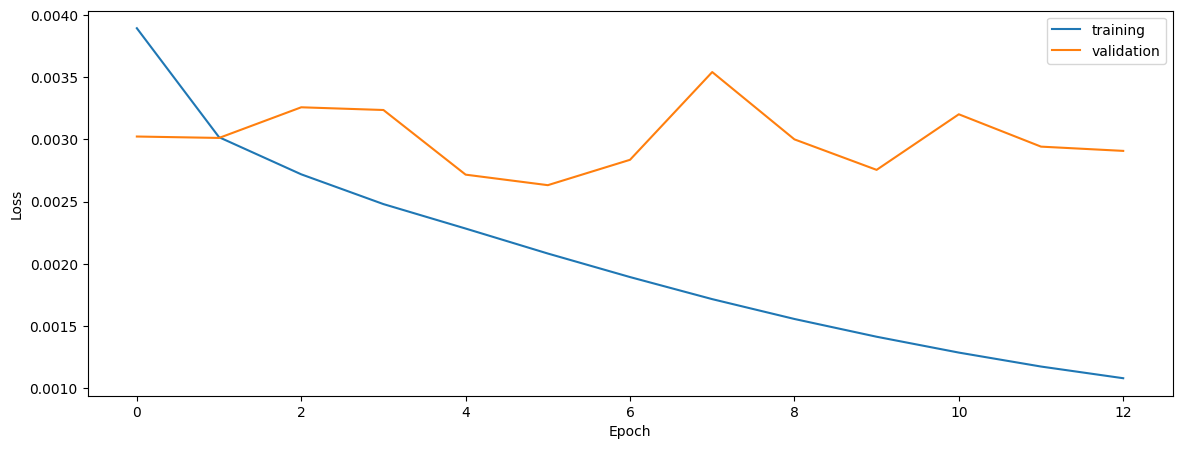

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.8929654618176756
0.833670631918856
0.8355038880257862


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

normalized
0.8926213919418916
0.8444703271220472
0.8431572168986167


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.8912203284536657
0.8415953023868005
0.8417234469784222


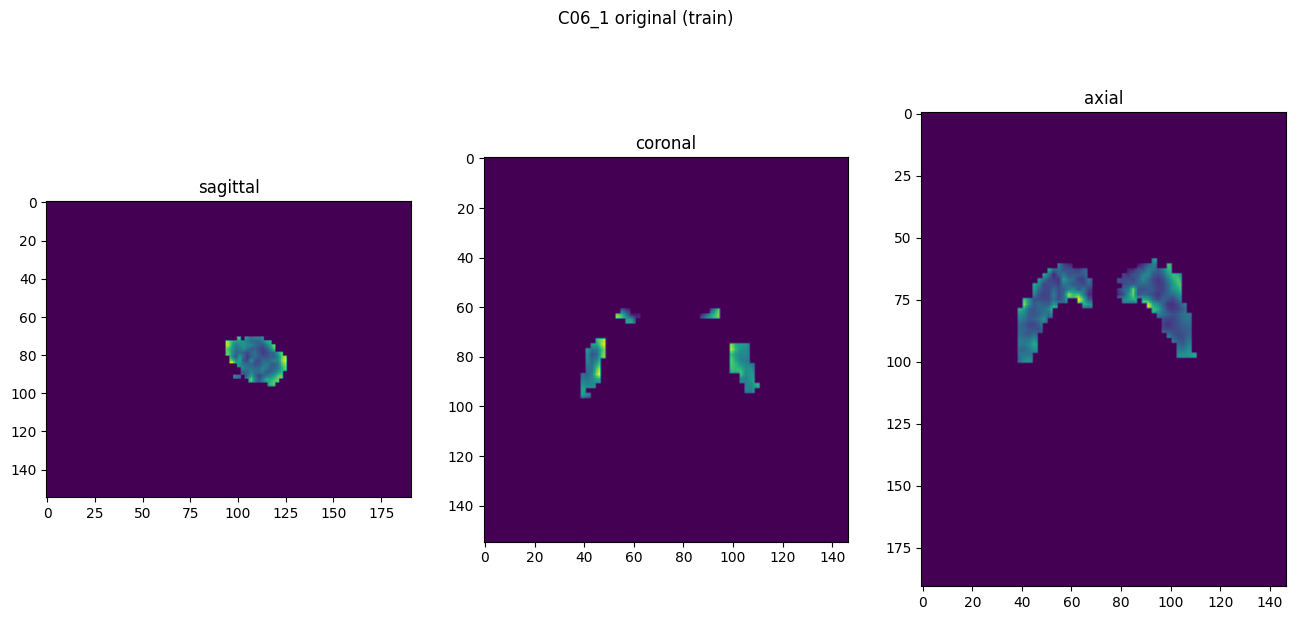

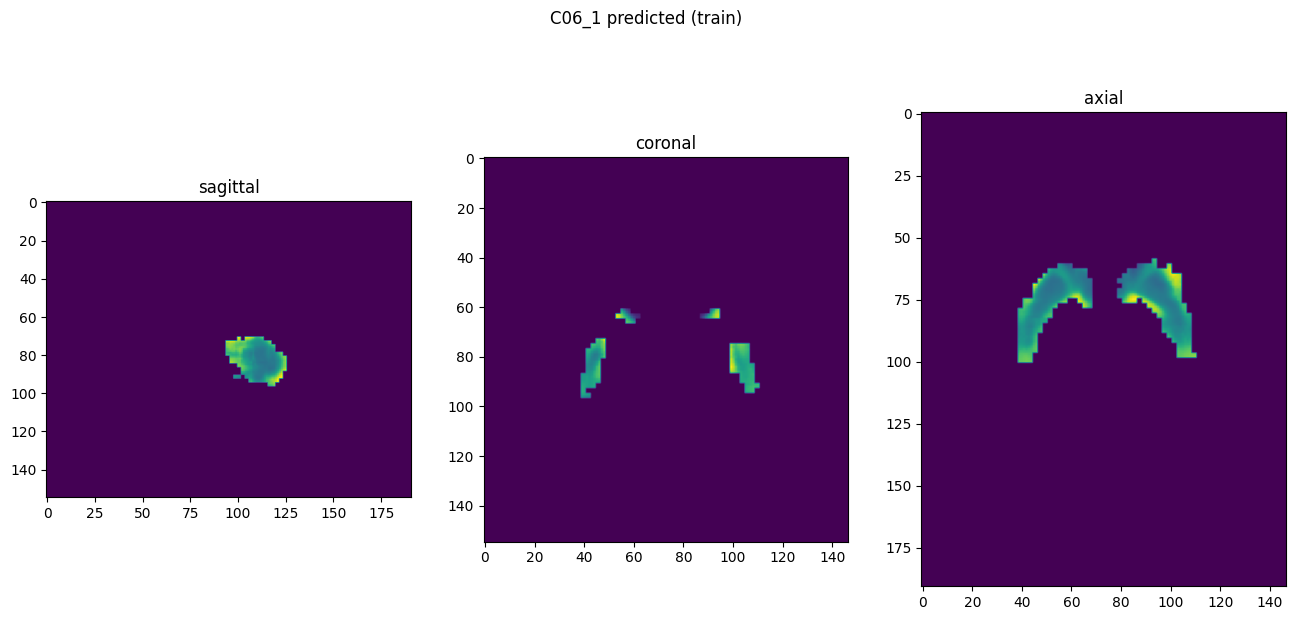

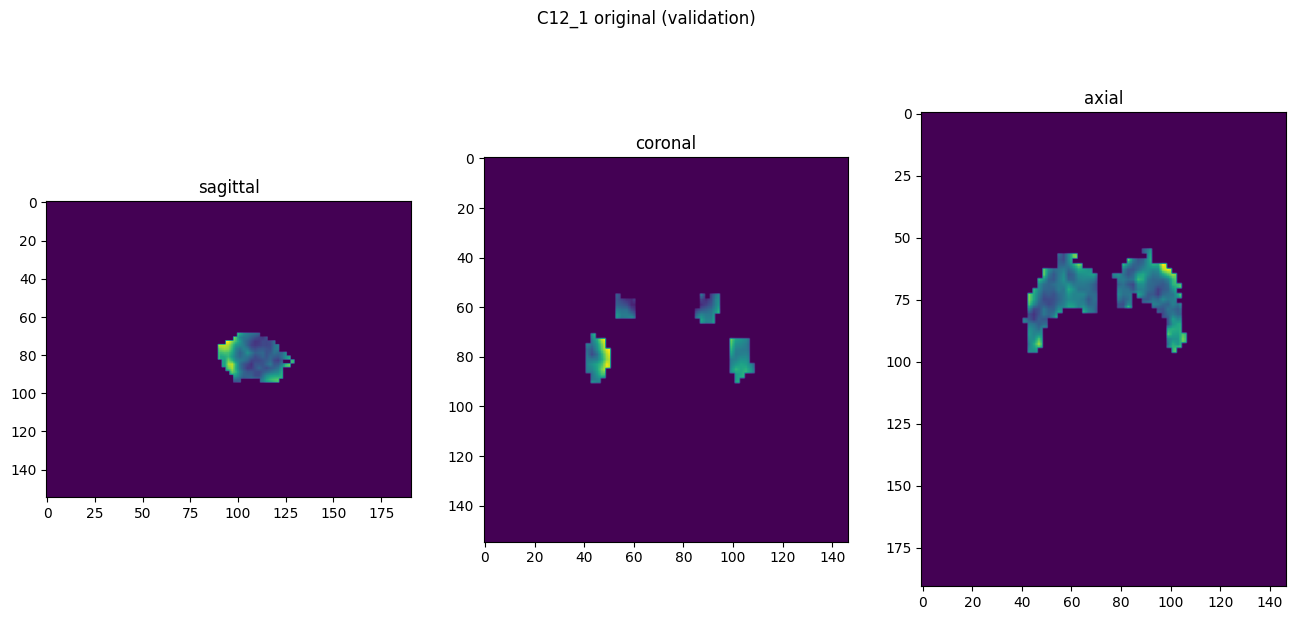

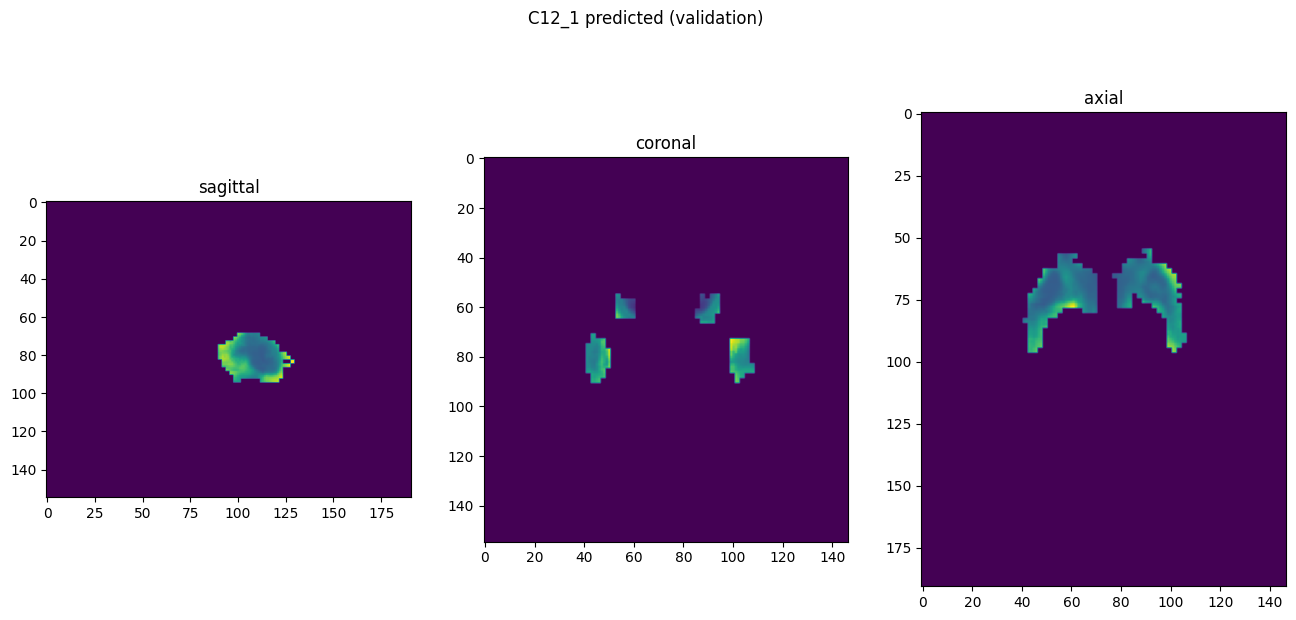

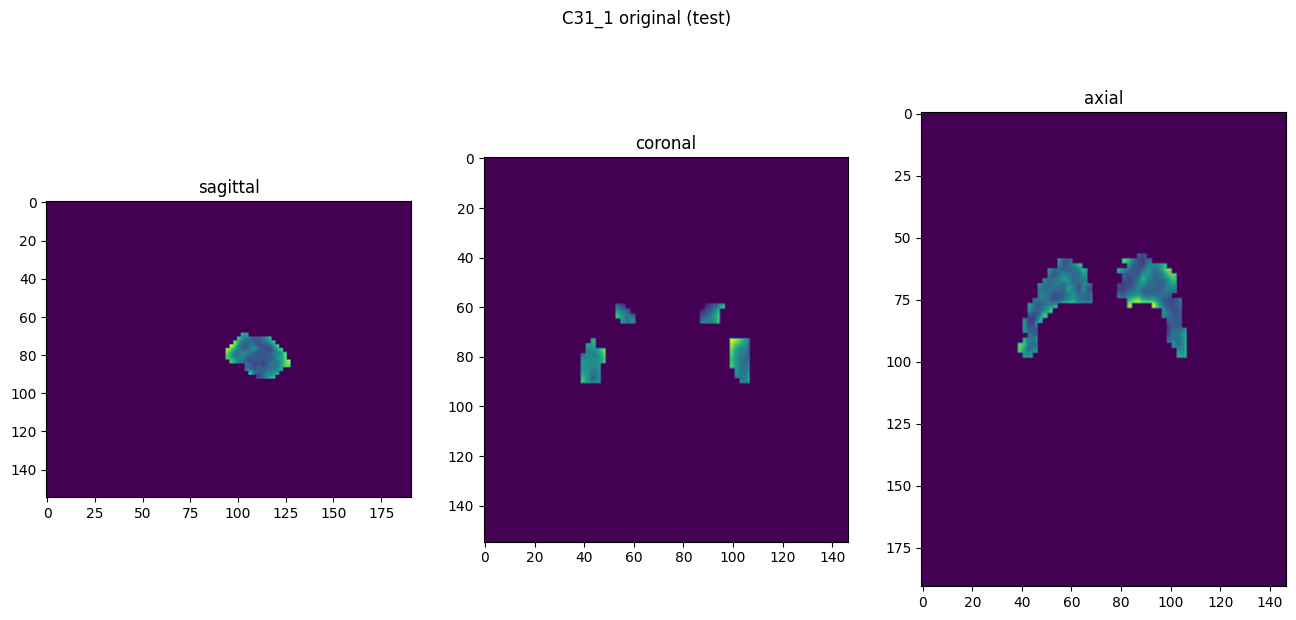

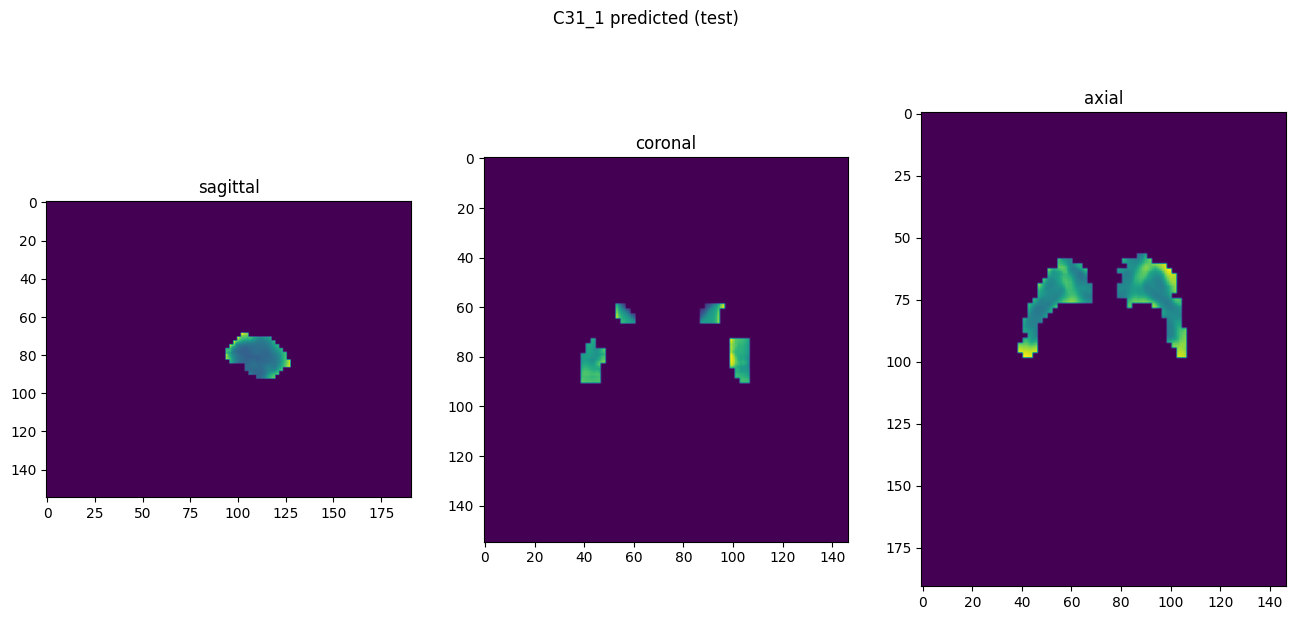

In [10]:
showResults(model, gen, threshold=None, background=False)